### Imports

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [2]:
from data import create_dataloader, split_data
from train import train
from evaluate import evaluate
from plots import training_plot, evaluation_confusion_matrix, class_bar_plot
from utils import set_seed

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

set_seed(42)
print("Random seed set to 42")

Using device: cuda
Random seed set to 42


# Simple Model

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)        # out: 6 x 60 x 60
        self.pool = nn.MaxPool2d(2, 2)           # after pool: 6 x 30 x 30
        self.conv2 = nn.Conv2d(6, 16, 5)         # out: 16 x 26 x 26
        # after pool: 16 x 13 x 13 -> flattened size = 16*13*13 = 2704
        self.fc1 = nn.Linear(16 * 13 * 13, 120)  # <-- updated input dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 50)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # 6x30x30
        x = self.pool(F.relu(self.conv2(x)))   # 16x13x13
        x = torch.flatten(x, 1)                # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()


net = Net().to(device)
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2704, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=50, bias=True)
)

### DataLoaders

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_subset, val_subset, class_names = split_data('train/train', train_size=0.8, transform=transform)

trainloader = create_dataloader(train_subset, batch_size=64, shuffle=True, num_workers=2)
valloader = create_dataloader(val_subset, batch_size=64, shuffle=False, num_workers=2)

### Training

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=0.001, weight_decay=1e-4)

model, train_loss, train_acc, val_loss, val_acc = train(net, trainloader, criterion, optimizer, epochs=10, device=device,
                                                        validation_loader=valloader, class_names=class_names)

Training Epoch [1/10]: 100%|██████████| 1101/1101 [00:54<00:00, 20.28it/s]


Loss: 3.1204 - Acc: 18.14%
Val   → Loss: 2.8258 - Acc: 24.35%


Training Epoch [2/10]: 100%|██████████| 1101/1101 [00:53<00:00, 20.52it/s]


Loss: 2.7143 - Acc: 27.42%
Val   → Loss: 2.6641 - Acc: 28.65%


Training Epoch [3/10]: 100%|██████████| 1101/1101 [01:03<00:00, 17.32it/s]


Loss: 2.5271 - Acc: 32.19%
Val   → Loss: 2.5948 - Acc: 30.73%


Training Epoch [4/10]: 100%|██████████| 1101/1101 [00:55<00:00, 19.91it/s]


Loss: 2.3975 - Acc: 35.18%
Val   → Loss: 2.5556 - Acc: 32.11%


Training Epoch [5/10]: 100%|██████████| 1101/1101 [01:04<00:00, 17.14it/s]


Loss: 2.2978 - Acc: 37.73%
Val   → Loss: 2.4660 - Acc: 33.73%


Training Epoch [6/10]: 100%|██████████| 1101/1101 [00:41<00:00, 26.27it/s]


Loss: 2.2141 - Acc: 39.75%
Val   → Loss: 2.4582 - Acc: 34.71%


Training Epoch [7/10]: 100%|██████████| 1101/1101 [00:42<00:00, 25.88it/s]


Loss: 2.1371 - Acc: 41.47%
Val   → Loss: 2.4367 - Acc: 35.01%


Training Epoch [8/10]: 100%|██████████| 1101/1101 [00:47<00:00, 23.02it/s]


Loss: 2.0678 - Acc: 43.02%
Val   → Loss: 2.4085 - Acc: 36.04%


Training Epoch [9/10]: 100%|██████████| 1101/1101 [00:46<00:00, 23.52it/s]


Loss: 2.0091 - Acc: 44.45%
Val   → Loss: 2.4634 - Acc: 35.37%


Training Epoch [10/10]: 100%|██████████| 1101/1101 [01:02<00:00, 17.53it/s]


Loss: 1.9415 - Acc: 46.19%
Val   → Loss: 2.5161 - Acc: 35.30%
Finished Training


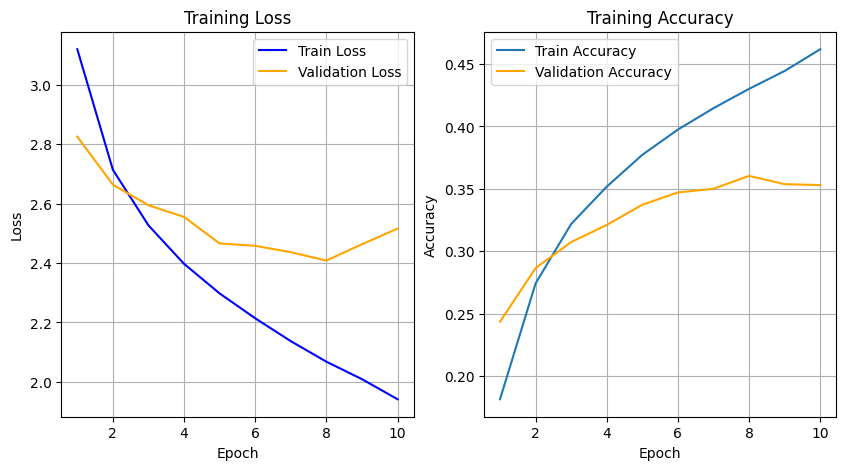

In [8]:
training_plot(epochs=10, train_loss=train_loss, train_acc=train_acc, val_loss=val_loss, val_acc=val_acc)

### Evaluation

In [10]:
y_true, y_pred = evaluate(model, valloader, classes=class_names, device=device)


Per-class Accuracy:
Accuracy for class 'acoustic       ': 11.5%
Accuracy for class 'antenna        ': 36.5%
Accuracy for class 'bacteria       ': 43.9%
Accuracy for class 'battery        ': 31.1%
Accuracy for class 'bean           ': 31.7%
Accuracy for class 'beetle         ': 59.8%
Accuracy for class 'bicycle        ': 64.1%
Accuracy for class 'birch          ': 25.2%
Accuracy for class 'bird           ': 9.3%
Accuracy for class 'bomb           ': 34.6%
Accuracy for class 'bread          ': 24.0%
Accuracy for class 'bridge         ': 35.7%
Accuracy for class 'camera         ': 43.1%
Accuracy for class 'carbon         ': 22.5%
Accuracy for class 'cat            ': 29.6%
Accuracy for class 'corn           ': 21.7%
Accuracy for class 'crab           ': 20.6%
Accuracy for class 'crocodilian    ': 32.9%
Accuracy for class 'echinoderm     ': 27.2%
Accuracy for class 'egg            ': 20.8%
Accuracy for class 'elephant       ': 53.1%
Accuracy for class 'fish           ': 24.5%
Accuracy for

### Plots

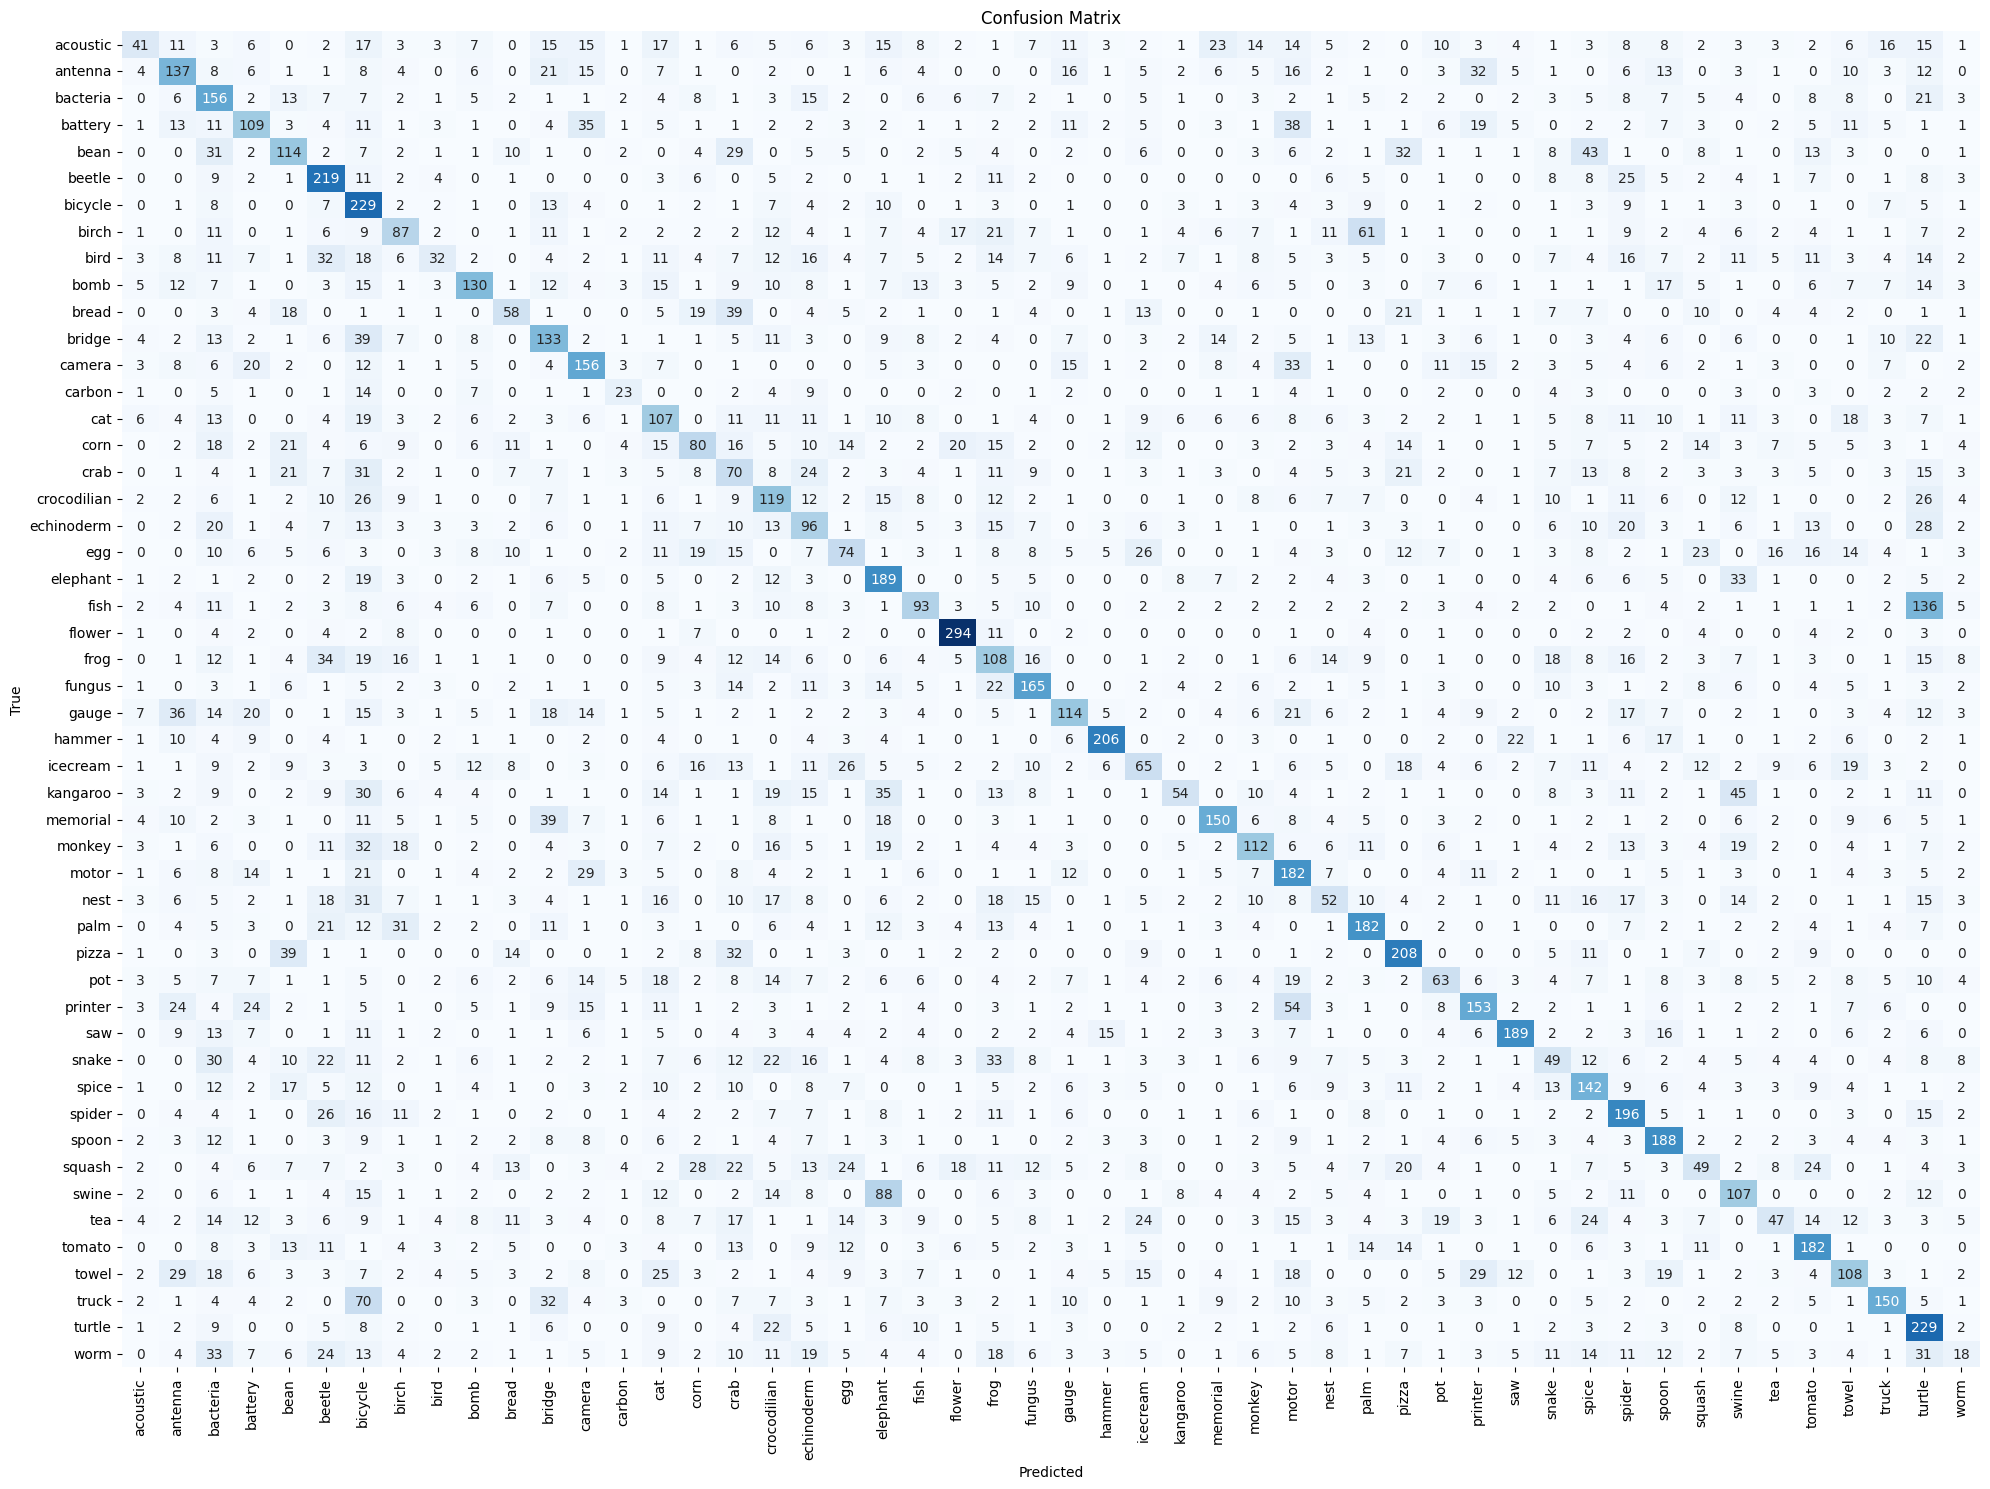

In [11]:
evaluation_confusion_matrix(y_true, y_pred, class_names)

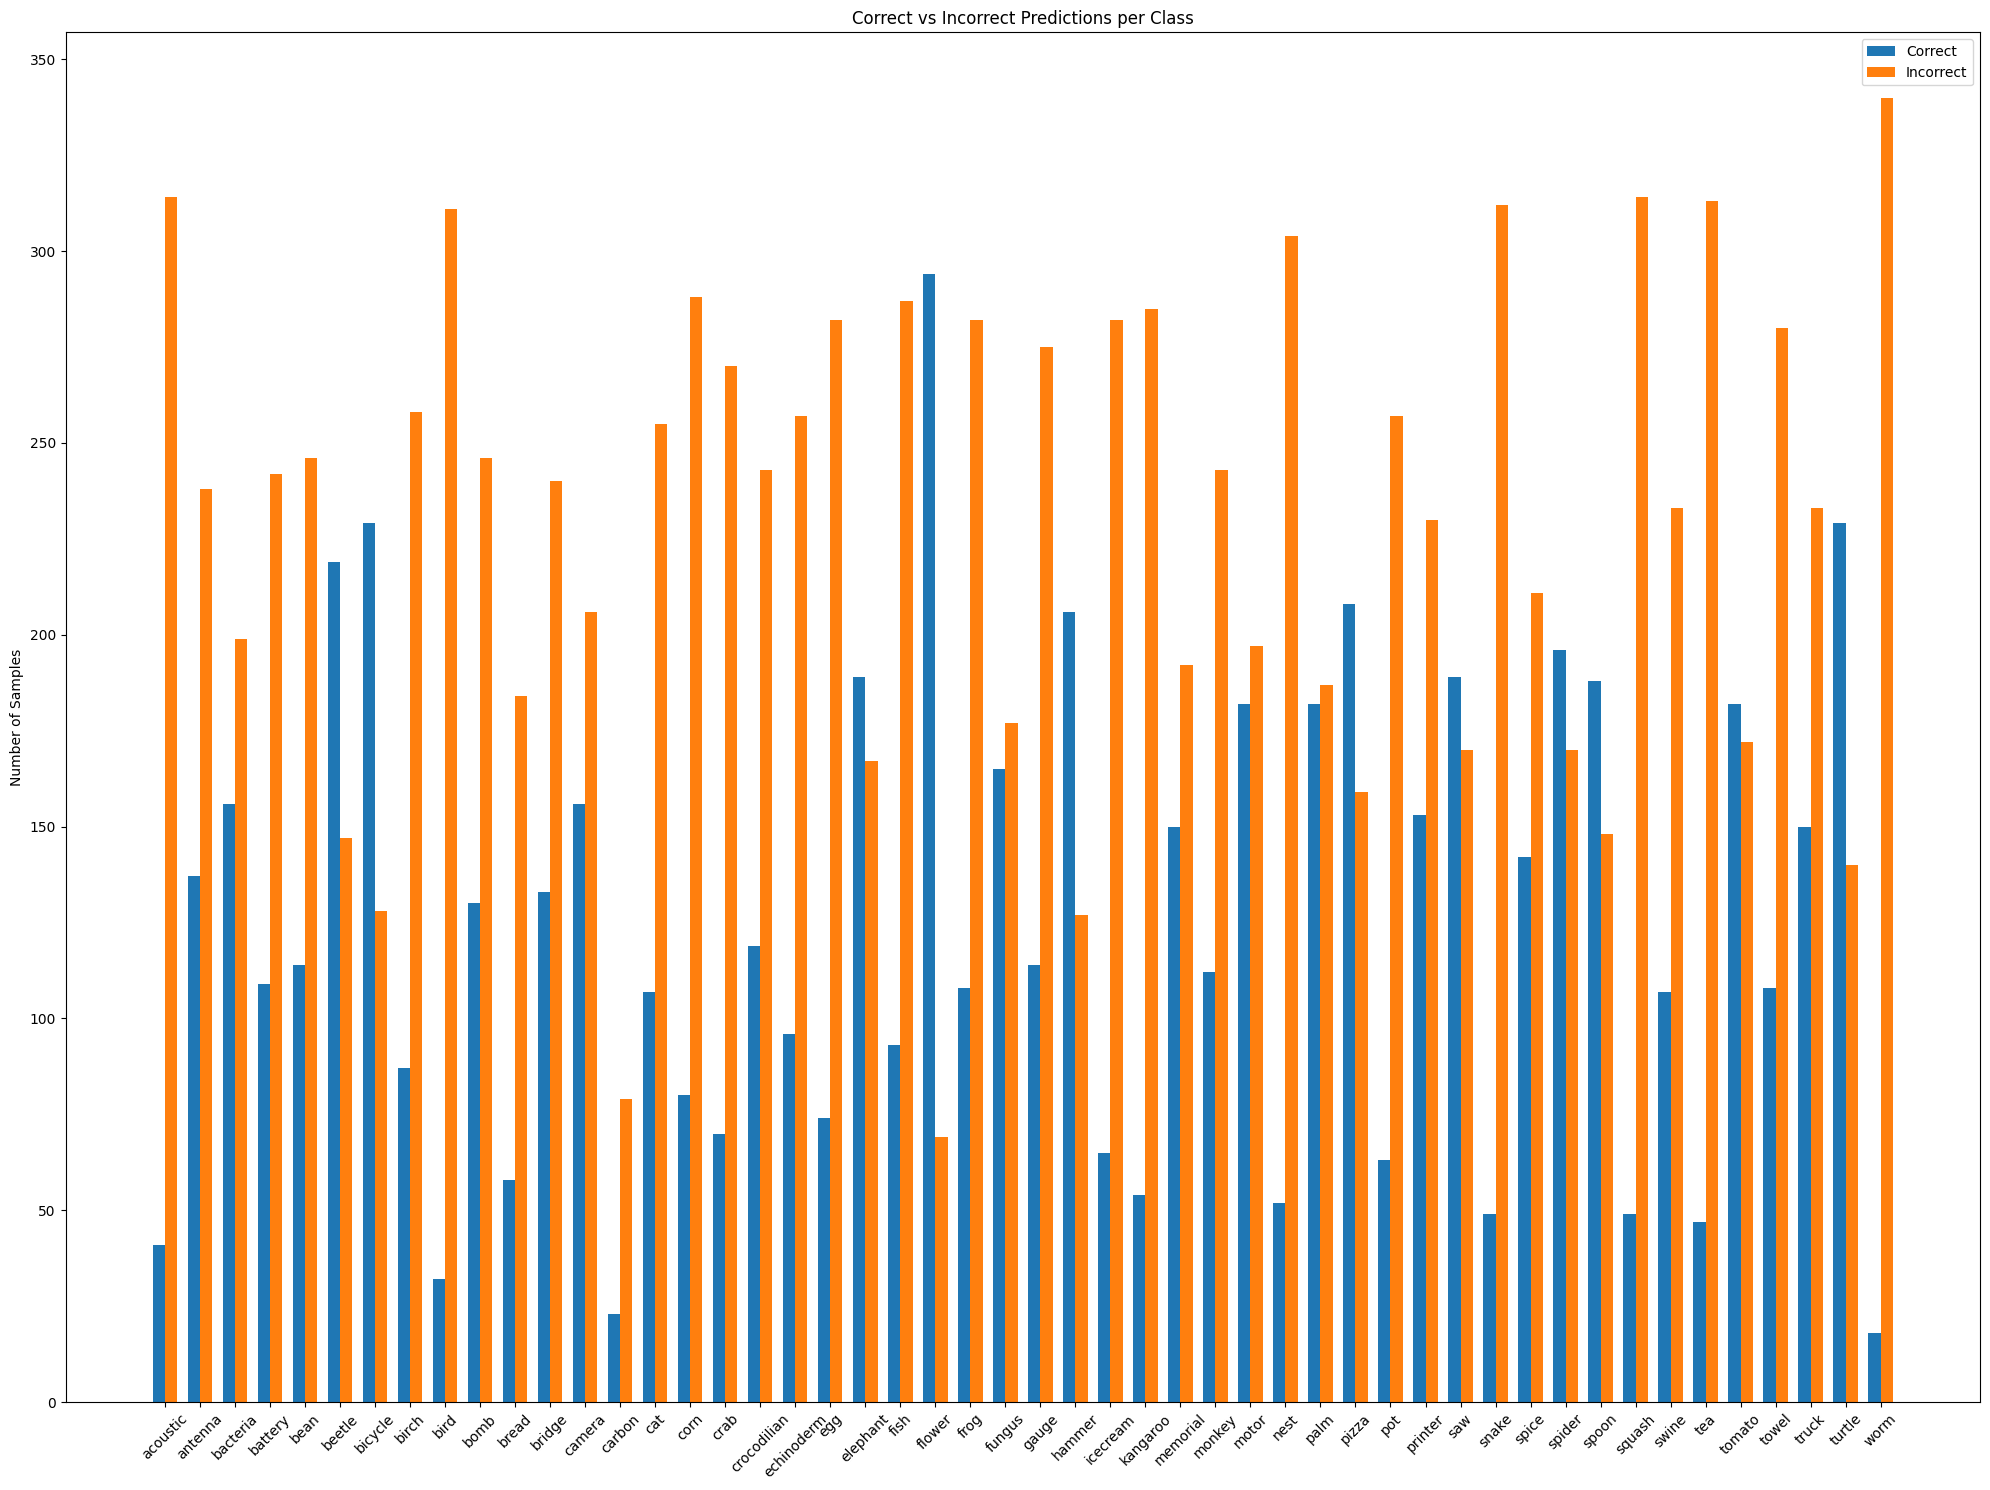

In [12]:
class_bar_plot(y_true, y_pred, class_names)

# BetterModel

In [5]:
class BetterNet(nn.Module):
    def __init__(self, num_classes=50):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [9]:
betternet = BetterNet().to(device)
betternet

BetterNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, af

#### Training

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(betternet.parameters(), lr=0.001, weight_decay=1e-4)

better_model, train_loss, train_acc, val_loss, val_acc = train(betternet, trainloader, criterion, optimizer, epochs=10, device=device, validation_loader=valloader, class_names=class_names)

Training Epoch [1/10]: 100%|██████████| 1101/1101 [00:40<00:00, 27.12it/s]


Training -> Loss: 3.1903 - Acc: 15.87%


Validating Epoch [1/10]: 100%|██████████| 276/276 [00:22<00:00, 12.38it/s]


Validation -> Loss: 2.7661 - Acc: 24.91%


Training Epoch [2/10]: 100%|██████████| 1101/1101 [00:41<00:00, 26.54it/s]


Training -> Loss: 2.7797 - Acc: 24.82%


Validating Epoch [2/10]: 100%|██████████| 276/276 [00:22<00:00, 12.22it/s]


Validation -> Loss: 2.4372 - Acc: 32.97%


Training Epoch [3/10]: 100%|██████████| 1101/1101 [00:37<00:00, 29.36it/s]


Training -> Loss: 2.5738 - Acc: 29.51%


Validating Epoch [3/10]: 100%|██████████| 276/276 [00:19<00:00, 13.99it/s]


Validation -> Loss: 2.2747 - Acc: 37.19%


Training Epoch [4/10]: 100%|██████████| 1101/1101 [00:39<00:00, 28.13it/s]


Training -> Loss: 2.4317 - Acc: 33.31%


Validating Epoch [4/10]: 100%|██████████| 276/276 [00:19<00:00, 14.38it/s]


Validation -> Loss: 2.1785 - Acc: 41.04%


Training Epoch [5/10]: 100%|██████████| 1101/1101 [00:37<00:00, 29.39it/s]


Training -> Loss: 2.3083 - Acc: 36.51%


Validating Epoch [5/10]: 100%|██████████| 276/276 [00:19<00:00, 14.38it/s]


Validation -> Loss: 2.0526 - Acc: 43.47%


Training Epoch [6/10]: 100%|██████████| 1101/1101 [00:38<00:00, 28.70it/s]


Training -> Loss: 2.2034 - Acc: 39.04%


Validating Epoch [6/10]: 100%|██████████| 276/276 [00:19<00:00, 14.26it/s]


Validation -> Loss: 1.9358 - Acc: 46.65%


Training Epoch [7/10]: 100%|██████████| 1101/1101 [00:39<00:00, 28.11it/s]


Training -> Loss: 2.1112 - Acc: 41.44%


Validating Epoch [7/10]: 100%|██████████| 276/276 [00:20<00:00, 13.32it/s]


Validation -> Loss: 1.8753 - Acc: 48.17%


Training Epoch [8/10]: 100%|██████████| 1101/1101 [00:38<00:00, 28.35it/s]


Training -> Loss: 2.0257 - Acc: 43.75%


Validating Epoch [8/10]: 100%|██████████| 276/276 [00:19<00:00, 14.26it/s]


Validation -> Loss: 1.7919 - Acc: 50.43%


Training Epoch [9/10]: 100%|██████████| 1101/1101 [00:45<00:00, 24.18it/s]


Training -> Loss: 1.9440 - Acc: 46.14%


Validating Epoch [9/10]: 100%|██████████| 276/276 [00:18<00:00, 14.92it/s]


Validation -> Loss: 1.7841 - Acc: 51.54%


Training Epoch [10/10]: 100%|██████████| 1101/1101 [00:39<00:00, 28.01it/s]


Training -> Loss: 1.8724 - Acc: 48.00%


Validating Epoch [10/10]: 100%|██████████| 276/276 [00:20<00:00, 13.32it/s]

Validation -> Loss: 1.7213 - Acc: 52.31%
Finished Training


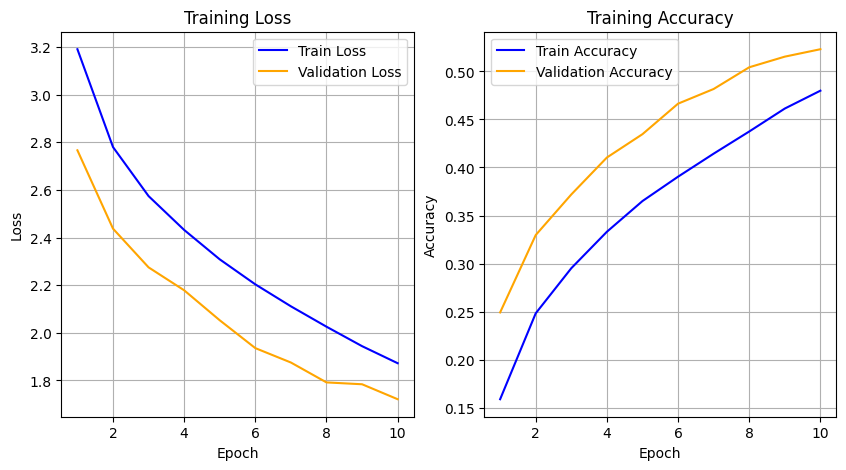

In [14]:
training_plot(epochs=10, train_loss=train_loss, train_acc=train_acc, val_loss=val_loss, val_acc=val_acc, title="")

#### Evaluating

In [15]:
y_true, y_pred = evaluate(better_model, valloader, classes=class_names, device=device)


Per-class Accuracy:
Accuracy for class 'acoustic       ': 44.8%
Accuracy for class 'antenna        ': 37.6%
Accuracy for class 'bacteria       ': 45.6%
Accuracy for class 'battery        ': 55.0%
Accuracy for class 'bean           ': 45.8%
Accuracy for class 'beetle         ': 62.3%
Accuracy for class 'bicycle        ': 76.2%
Accuracy for class 'birch          ': 44.6%
Accuracy for class 'bird           ': 28.3%
Accuracy for class 'bomb           ': 46.5%
Accuracy for class 'bread          ': 38.8%
Accuracy for class 'bridge         ': 58.7%
Accuracy for class 'camera         ': 62.7%
Accuracy for class 'carbon         ': 37.3%
Accuracy for class 'cat            ': 64.4%
Accuracy for class 'corn           ': 42.7%
Accuracy for class 'crab           ': 25.0%
Accuracy for class 'crocodilian    ': 47.2%
Accuracy for class 'echinoderm     ': 37.4%
Accuracy for class 'egg            ': 36.0%
Accuracy for class 'elephant       ': 67.7%
Accuracy for class 'fish           ': 41.6%
Accuracy fo

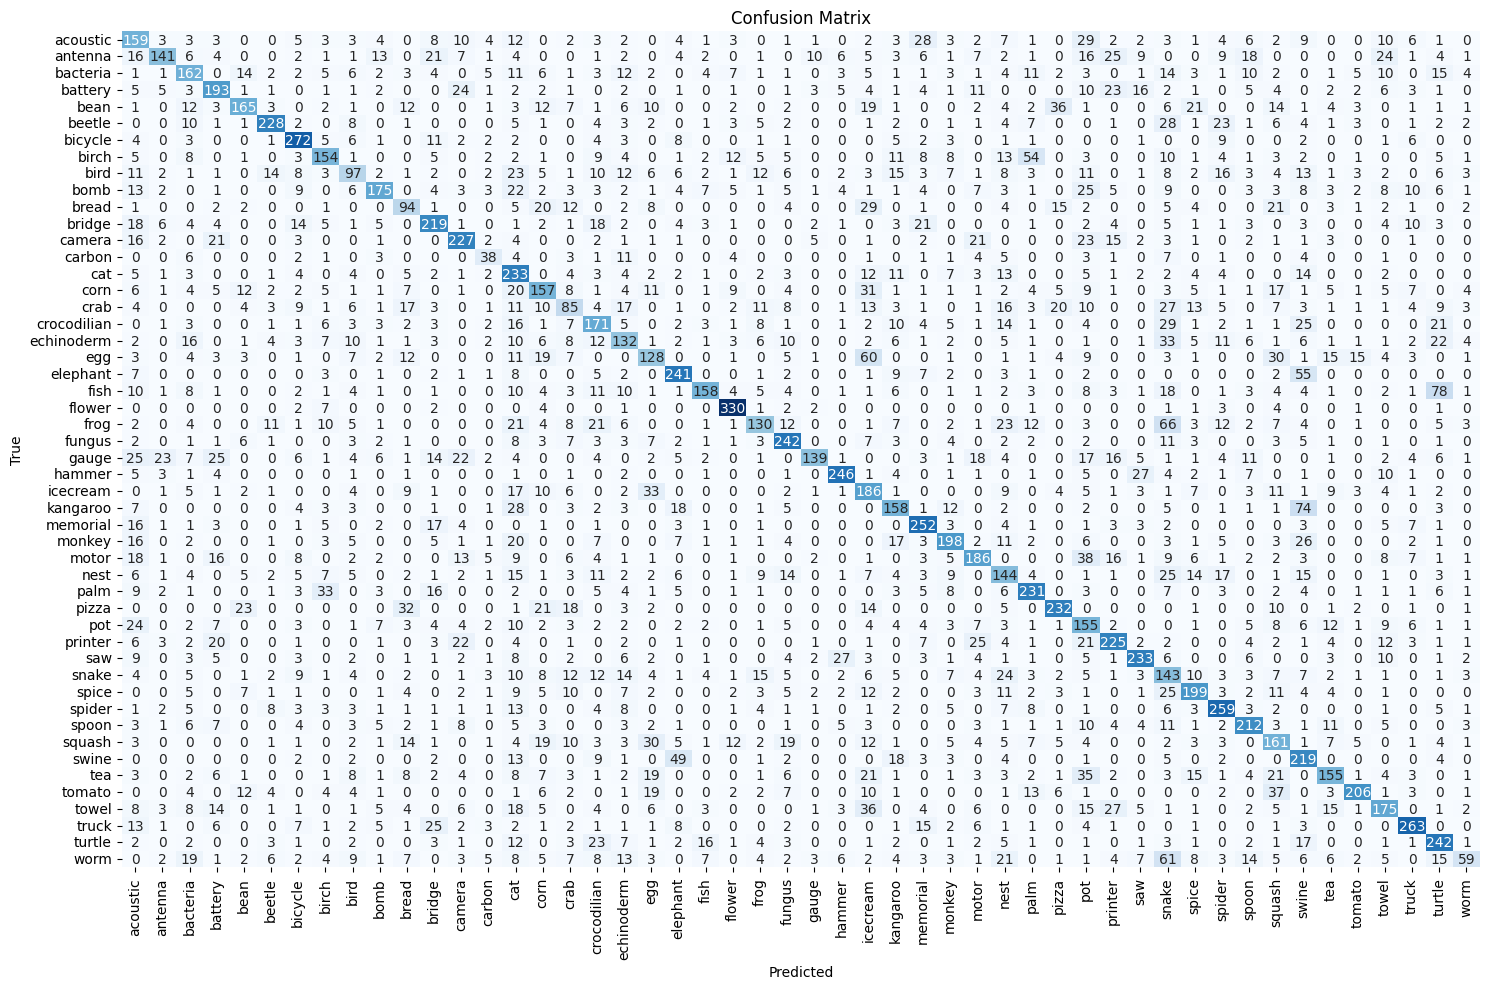

In [16]:
evaluation_confusion_matrix(y_true, y_pred, class_names)

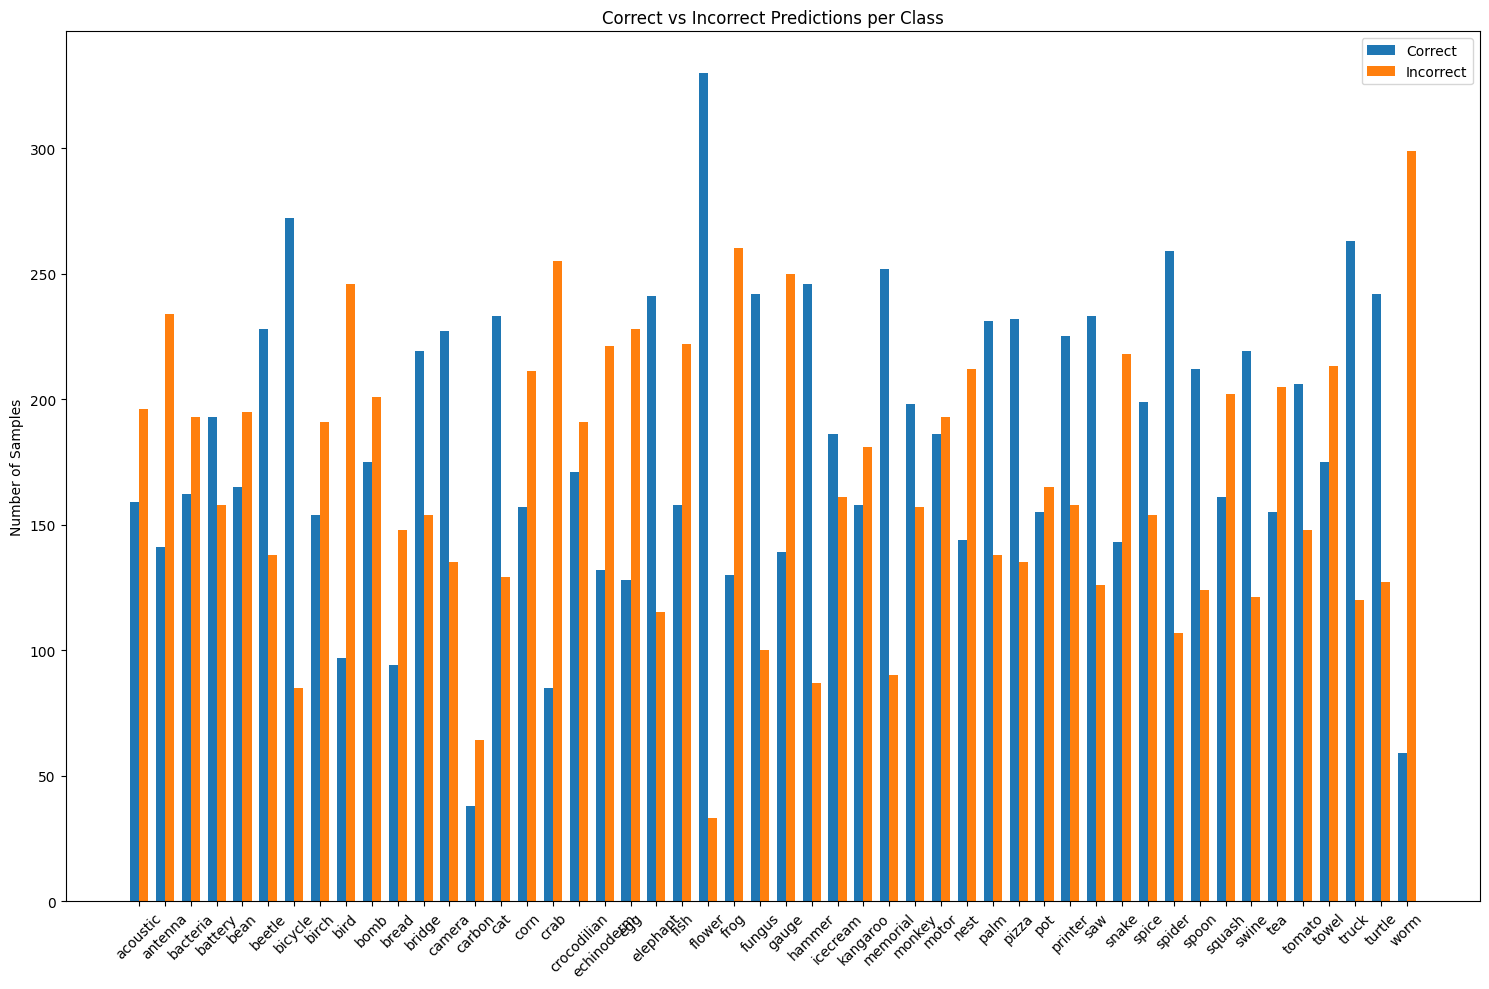

In [17]:
class_bar_plot(y_true, y_pred, class_names)

# Experimetns - BetterModel

### Data

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_subset, val_subset, class_names = split_data('train/train', train_size=0.8, transform=transform)

In [8]:
def run_experiment(
    model,
    train_loader,
    val_loader,
    class_names,
    device,
    criterion,
    learning_rate=0.001,
    weight_decay=1e-4,
    epochs=10,
    scheduler=None):

    # prepare model
    model_parameters = model.parameters()
    optimizer = torch.optim.AdamW(model_parameters, lr=learning_rate, weight_decay=weight_decay)

    # train the model
    model, train_loss, train_acc, val_loss, val_acc = train(
        model,
        train_loader,
        criterion,
        optimizer,
        epochs=epochs,
        device=device,
        validation_loader=val_loader,
        class_names=class_names,
        scheduler=scheduler
    )

    return model, train_loss, train_acc, val_loss, val_acc

In [9]:
BATCH_SIZE = [128, 256] # i checked 64 as the first test

criterion = nn.CrossEntropyLoss()

### Batchsize infulence on accuracy

In [11]:
batchsize_values = {}

for batchsize in BATCH_SIZE:
    trainloader = create_dataloader(train_subset, batch_size=batchsize, shuffle=True, num_workers=2)
    valloader = create_dataloader(val_subset, batch_size=batchsize, shuffle=False, num_workers=2)

    print(f"Running experiment with batchsize: {batchsize}")
    model = BetterNet().to(device)
    model, train_loss, train_acc, val_loss, val_acc = run_experiment(
        model=model,
        train_loader=trainloader,
        val_loader=valloader,
        class_names=class_names,
        device=device,
        criterion=criterion,
        learning_rate=0.001,
        weight_decay=1e-4,
        epochs=15
    )

    batchsize_values[batchsize] = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "model": model
    }

Running experiment with batchsize: 128


Training Epoch [1/15]: 100%|██████████| 551/551 [00:53<00:00, 10.32it/s]


Training -> Loss: 3.1224 - Acc: 17.39%


Validating Epoch [1/15]: 100%|██████████| 138/138 [00:22<00:00,  6.15it/s]


Validation -> Loss: 2.6549 - Acc: 27.73%


Training Epoch [2/15]: 100%|██████████| 551/551 [00:34<00:00, 16.18it/s]


Training -> Loss: 2.7037 - Acc: 26.52%


Validating Epoch [2/15]: 100%|██████████| 138/138 [00:17<00:00,  7.78it/s]


Validation -> Loss: 2.5062 - Acc: 31.47%


Training Epoch [3/15]: 100%|██████████| 551/551 [00:37<00:00, 14.83it/s]


Training -> Loss: 2.5297 - Acc: 30.59%


Validating Epoch [3/15]: 100%|██████████| 138/138 [00:18<00:00,  7.66it/s]


Validation -> Loss: 2.4386 - Acc: 34.53%


Training Epoch [4/15]: 100%|██████████| 551/551 [00:33<00:00, 16.68it/s]


Training -> Loss: 2.4116 - Acc: 33.87%


Validating Epoch [4/15]: 100%|██████████| 138/138 [00:18<00:00,  7.35it/s]


Validation -> Loss: 2.1684 - Acc: 40.83%


Training Epoch [5/15]: 100%|██████████| 551/551 [00:32<00:00, 16.93it/s]


Training -> Loss: 2.3078 - Acc: 36.20%


Validating Epoch [5/15]: 100%|██████████| 138/138 [00:17<00:00,  7.77it/s]


Validation -> Loss: 2.0944 - Acc: 43.06%


Training Epoch [6/15]: 100%|██████████| 551/551 [00:32<00:00, 17.00it/s]


Training -> Loss: 2.2150 - Acc: 38.59%


Validating Epoch [6/15]: 100%|██████████| 138/138 [00:17<00:00,  7.76it/s]


Validation -> Loss: 2.0146 - Acc: 45.23%


Training Epoch [7/15]: 100%|██████████| 551/551 [00:34<00:00, 15.94it/s]


Training -> Loss: 2.1388 - Acc: 40.78%


Validating Epoch [7/15]: 100%|██████████| 138/138 [00:17<00:00,  7.90it/s]


Validation -> Loss: 1.9705 - Acc: 45.70%


Training Epoch [8/15]: 100%|██████████| 551/551 [00:33<00:00, 16.61it/s]


Training -> Loss: 2.0618 - Acc: 42.88%


Validating Epoch [8/15]: 100%|██████████| 138/138 [00:17<00:00,  7.72it/s]


Validation -> Loss: 1.8579 - Acc: 48.93%


Training Epoch [9/15]: 100%|██████████| 551/551 [00:33<00:00, 16.46it/s]


Training -> Loss: 1.9891 - Acc: 44.64%


Validating Epoch [9/15]: 100%|██████████| 138/138 [00:17<00:00,  7.76it/s]


Validation -> Loss: 1.8804 - Acc: 48.42%


Training Epoch [10/15]: 100%|██████████| 551/551 [00:34<00:00, 16.05it/s]


Training -> Loss: 1.9294 - Acc: 46.18%


Validating Epoch [10/15]: 100%|██████████| 138/138 [00:20<00:00,  6.83it/s]


Validation -> Loss: 1.8353 - Acc: 50.49%


Training Epoch [11/15]: 100%|██████████| 551/551 [00:34<00:00, 16.06it/s]


Training -> Loss: 1.8633 - Acc: 47.82%


Validating Epoch [11/15]: 100%|██████████| 138/138 [00:17<00:00,  7.86it/s]


Validation -> Loss: 1.7630 - Acc: 51.12%


Training Epoch [12/15]: 100%|██████████| 551/551 [00:32<00:00, 16.89it/s]


Training -> Loss: 1.8127 - Acc: 49.34%


Validating Epoch [12/15]: 100%|██████████| 138/138 [00:17<00:00,  7.86it/s]


Validation -> Loss: 1.8088 - Acc: 50.55%


Training Epoch [13/15]: 100%|██████████| 551/551 [00:32<00:00, 17.00it/s]


Training -> Loss: 1.7524 - Acc: 50.75%


Validating Epoch [13/15]: 100%|██████████| 138/138 [00:18<00:00,  7.37it/s]


Validation -> Loss: 1.6780 - Acc: 53.55%


Training Epoch [14/15]: 100%|██████████| 551/551 [00:34<00:00, 15.82it/s]


Training -> Loss: 1.7049 - Acc: 51.78%


Validating Epoch [14/15]: 100%|██████████| 138/138 [00:17<00:00,  7.90it/s]


Validation -> Loss: 1.6723 - Acc: 53.80%


Training Epoch [15/15]: 100%|██████████| 551/551 [00:32<00:00, 16.84it/s]


Training -> Loss: 1.6464 - Acc: 53.63%


Validating Epoch [15/15]: 100%|██████████| 138/138 [00:18<00:00,  7.51it/s]


Validation -> Loss: 1.6312 - Acc: 55.09%
Finished Training
Running experiment with batchsize: 256


Training Epoch [1/15]: 100%|██████████| 276/276 [00:31<00:00,  8.74it/s]


Training -> Loss: 3.1068 - Acc: 17.86%


Validating Epoch [1/15]: 100%|██████████| 69/69 [00:18<00:00,  3.81it/s]


Validation -> Loss: 2.8591 - Acc: 23.83%


Training Epoch [2/15]: 100%|██████████| 276/276 [00:30<00:00,  9.02it/s]


Training -> Loss: 2.6458 - Acc: 28.44%


Validating Epoch [2/15]: 100%|██████████| 69/69 [00:18<00:00,  3.75it/s]


Validation -> Loss: 2.4362 - Acc: 33.32%


Training Epoch [3/15]: 100%|██████████| 276/276 [00:32<00:00,  8.58it/s]


Training -> Loss: 2.4714 - Acc: 32.15%


Validating Epoch [3/15]: 100%|██████████| 69/69 [00:17<00:00,  3.97it/s]


Validation -> Loss: 2.3863 - Acc: 35.50%


Training Epoch [4/15]: 100%|██████████| 276/276 [00:30<00:00,  8.94it/s]


Training -> Loss: 2.3403 - Acc: 35.94%


Validating Epoch [4/15]: 100%|██████████| 69/69 [00:17<00:00,  3.86it/s]


Validation -> Loss: 2.2695 - Acc: 37.94%


Training Epoch [5/15]: 100%|██████████| 276/276 [00:35<00:00,  7.72it/s]


Training -> Loss: 2.2502 - Acc: 37.79%


Validating Epoch [5/15]: 100%|██████████| 69/69 [00:18<00:00,  3.77it/s]


Validation -> Loss: 2.0480 - Acc: 43.31%


Training Epoch [6/15]: 100%|██████████| 276/276 [00:30<00:00,  8.97it/s]


Training -> Loss: 2.1602 - Acc: 40.31%


Validating Epoch [6/15]: 100%|██████████| 69/69 [00:18<00:00,  3.82it/s]


Validation -> Loss: 2.0040 - Acc: 45.18%


Training Epoch [7/15]: 100%|██████████| 276/276 [00:30<00:00,  8.93it/s]


Training -> Loss: 2.0920 - Acc: 42.30%


Validating Epoch [7/15]: 100%|██████████| 69/69 [00:16<00:00,  4.07it/s]


Validation -> Loss: 1.9477 - Acc: 45.91%


Training Epoch [8/15]: 100%|██████████| 276/276 [00:32<00:00,  8.59it/s]


Training -> Loss: 2.0224 - Acc: 43.82%


Validating Epoch [8/15]: 100%|██████████| 69/69 [00:17<00:00,  4.01it/s]


Validation -> Loss: 2.0004 - Acc: 46.04%


Training Epoch [9/15]: 100%|██████████| 276/276 [00:36<00:00,  7.59it/s]


Training -> Loss: 1.9565 - Acc: 45.37%


Validating Epoch [9/15]: 100%|██████████| 69/69 [00:19<00:00,  3.56it/s]


Validation -> Loss: 1.9098 - Acc: 48.09%


Training Epoch [10/15]: 100%|██████████| 276/276 [00:30<00:00,  8.95it/s]


Training -> Loss: 1.9008 - Acc: 46.84%


Validating Epoch [10/15]: 100%|██████████| 69/69 [00:17<00:00,  4.02it/s]


Validation -> Loss: 1.9292 - Acc: 48.15%


Training Epoch [11/15]: 100%|██████████| 276/276 [00:30<00:00,  9.08it/s]


Training -> Loss: 1.8514 - Acc: 48.11%


Validating Epoch [11/15]: 100%|██████████| 69/69 [00:17<00:00,  4.06it/s]


Validation -> Loss: 1.7655 - Acc: 51.54%


Training Epoch [12/15]: 100%|██████████| 276/276 [00:30<00:00,  9.04it/s]


Training -> Loss: 1.8048 - Acc: 49.33%


Validating Epoch [12/15]: 100%|██████████| 69/69 [00:16<00:00,  4.09it/s]


Validation -> Loss: 1.8419 - Acc: 49.32%


Training Epoch [13/15]: 100%|██████████| 276/276 [00:31<00:00,  8.83it/s]


Training -> Loss: 1.7663 - Acc: 50.35%


Validating Epoch [13/15]: 100%|██████████| 69/69 [00:17<00:00,  4.03it/s]


Validation -> Loss: 1.7381 - Acc: 51.98%


Training Epoch [14/15]: 100%|██████████| 276/276 [00:30<00:00,  9.18it/s]


Training -> Loss: 1.7197 - Acc: 51.35%


Validating Epoch [14/15]: 100%|██████████| 69/69 [00:17<00:00,  3.93it/s]


Validation -> Loss: 1.8704 - Acc: 49.55%


Training Epoch [15/15]: 100%|██████████| 276/276 [00:30<00:00,  8.92it/s]


Training -> Loss: 1.6696 - Acc: 52.66%


Validating Epoch [15/15]: 100%|██████████| 69/69 [00:18<00:00,  3.81it/s]

Validation -> Loss: 1.7489 - Acc: 52.19%
Finished Training


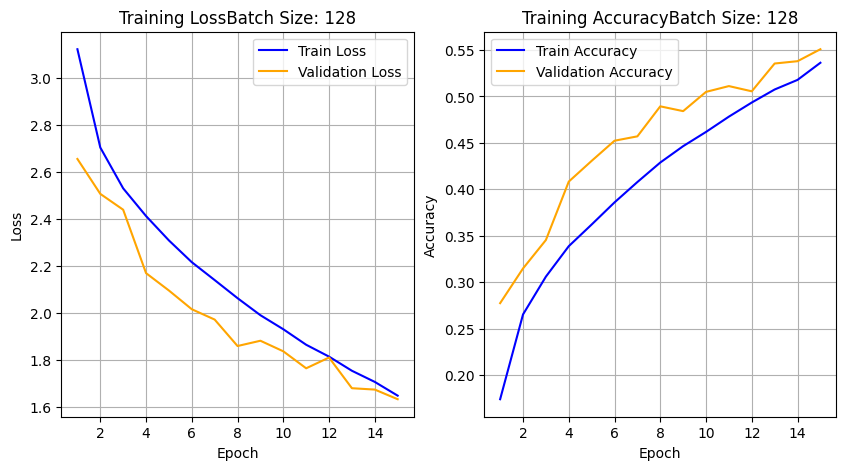


Per-class Accuracy:
Accuracy for class 'acoustic       ': 39.4%
Accuracy for class 'antenna        ': 52.0%
Accuracy for class 'bacteria       ': 43.4%
Accuracy for class 'battery        ': 54.1%
Accuracy for class 'bean           ': 57.5%
Accuracy for class 'beetle         ': 69.1%
Accuracy for class 'bicycle        ': 75.6%
Accuracy for class 'birch          ': 37.7%
Accuracy for class 'bird           ': 28.3%
Accuracy for class 'bomb           ': 49.2%
Accuracy for class 'bread          ': 36.4%
Accuracy for class 'bridge         ': 70.8%
Accuracy for class 'camera         ': 60.2%
Accuracy for class 'carbon         ': 34.3%
Accuracy for class 'cat            ': 57.5%
Accuracy for class 'corn           ': 37.0%
Accuracy for class 'crab           ': 37.1%
Accuracy for class 'crocodilian    ': 61.6%
Accuracy for class 'echinoderm     ': 38.2%
Accuracy for class 'egg            ': 34.6%
Accuracy for class 'elephant       ': 73.0%
Accuracy for class 'fish           ': 60.3%
Accuracy fo

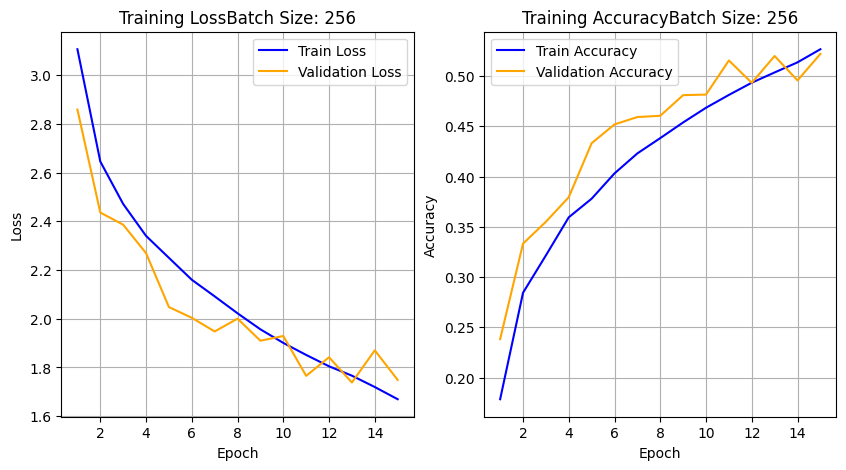


Per-class Accuracy:
Accuracy for class 'acoustic       ': 35.5%
Accuracy for class 'antenna        ': 42.9%
Accuracy for class 'bacteria       ': 47.3%
Accuracy for class 'battery        ': 56.7%
Accuracy for class 'bean           ': 47.5%
Accuracy for class 'beetle         ': 73.8%
Accuracy for class 'bicycle        ': 82.6%
Accuracy for class 'birch          ': 35.9%
Accuracy for class 'bird           ': 28.0%
Accuracy for class 'bomb           ': 60.1%
Accuracy for class 'bread          ': 26.4%
Accuracy for class 'bridge         ': 75.3%
Accuracy for class 'camera         ': 63.8%
Accuracy for class 'carbon         ': 36.3%
Accuracy for class 'cat            ': 39.2%
Accuracy for class 'corn           ': 31.2%
Accuracy for class 'crab           ': 40.9%
Accuracy for class 'crocodilian    ': 64.1%
Accuracy for class 'echinoderm     ': 32.6%
Accuracy for class 'egg            ': 22.8%
Accuracy for class 'elephant       ': 65.4%
Accuracy for class 'fish           ': 51.8%
Accuracy fo

In [12]:
for batchsize in BATCH_SIZE:
    train_loss = batchsize_values[batchsize]["train_loss"]
    train_acc = batchsize_values[batchsize]["train_acc"]
    val_loss = batchsize_values[batchsize]["val_loss"]
    val_acc = batchsize_values[batchsize]["val_acc"]

    valloader = create_dataloader(val_subset, batch_size=batchsize, shuffle=False, num_workers=2)

    training_plot(
        epochs=15,
        train_loss=train_loss,
        train_acc=train_acc,
        val_loss=val_loss,
        val_acc=val_acc,
        title=f"Batch Size: {batchsize}"
    )
    y_true, y_pred = evaluate(batchsize_values[batchsize]["model"], valloader, classes=class_names, device=device)


#### Conclusions 
- All the batch sizes gives similar results, around 52%+
- I think batch_size = 128 is the best one

### Agumentacja danych

In [22]:
train_transform = transforms.Compose([
    transforms.RandomCrop(64, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

raw_dataset = torchvision.datasets.ImageFolder(
    root='train/train',
    transform=None
)
class_names = raw_dataset.classes

train_size = int(0.8 * len(raw_dataset))
val_size = len(raw_dataset) - train_size
train_indices, val_indices = torch.utils.data.random_split(
    range(len(raw_dataset)), [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)


train_dataset = torchvision.datasets.ImageFolder(
    root='train/train',
    transform=train_transform
)
val_dataset = torchvision.datasets.ImageFolder(
    root='train/train',
    transform=val_transform
)


train_subset = torch.utils.data.Subset(train_dataset, train_indices)
val_subset = torch.utils.data.Subset(val_dataset, val_indices)

trainloader = create_dataloader(train_subset, batch_size=128, shuffle=True, num_workers=2)
valloader = create_dataloader(val_subset, batch_size=128, shuffle=False, num_workers=2)

In [23]:
model = BetterNet().to(device)
criterion = nn.CrossEntropyLoss()
model, train_loss, train_acc, val_loss, val_acc = run_experiment(
    model=model,
    train_loader=trainloader,
    val_loader=valloader,
    class_names=class_names,
    device=device,
    criterion=criterion,
    learning_rate=0.001,
    weight_decay=1e-4,
    epochs=15
)

Training Epoch [1/15]: 100%|██████████| 551/551 [01:28<00:00,  6.26it/s]


Training -> Loss: 3.3727 - Acc: 11.92%


Validating Epoch [1/15]: 100%|██████████| 138/138 [00:21<00:00,  6.39it/s]


Validation -> Loss: 2.9257 - Acc: 21.67%


Training Epoch [2/15]: 100%|██████████| 551/551 [01:28<00:00,  6.26it/s]


Training -> Loss: 3.0501 - Acc: 18.02%


Validating Epoch [2/15]: 100%|██████████| 138/138 [00:23<00:00,  5.98it/s]


Validation -> Loss: 2.6569 - Acc: 26.39%


Training Epoch [3/15]: 100%|██████████| 551/551 [01:34<00:00,  5.80it/s]


Training -> Loss: 2.8876 - Acc: 21.94%


Validating Epoch [3/15]: 100%|██████████| 138/138 [00:20<00:00,  6.70it/s]


Validation -> Loss: 2.6164 - Acc: 27.64%


Training Epoch [4/15]: 100%|██████████| 551/551 [01:31<00:00,  6.00it/s]


Training -> Loss: 2.7817 - Acc: 24.65%


Validating Epoch [4/15]: 100%|██████████| 138/138 [00:17<00:00,  8.09it/s]


Validation -> Loss: 2.5021 - Acc: 31.28%


Training Epoch [5/15]: 100%|██████████| 551/551 [01:31<00:00,  6.04it/s]


Training -> Loss: 2.7057 - Acc: 26.68%


Validating Epoch [5/15]: 100%|██████████| 138/138 [00:19<00:00,  7.18it/s]


Validation -> Loss: 2.3046 - Acc: 36.54%


Training Epoch [6/15]: 100%|██████████| 551/551 [01:29<00:00,  6.13it/s]


Training -> Loss: 2.6197 - Acc: 28.34%


Validating Epoch [6/15]: 100%|██████████| 138/138 [00:19<00:00,  7.23it/s]


Validation -> Loss: 2.2784 - Acc: 37.66%


Training Epoch [7/15]: 100%|██████████| 551/551 [01:25<00:00,  6.43it/s]


Training -> Loss: 2.5508 - Acc: 30.32%


Validating Epoch [7/15]: 100%|██████████| 138/138 [00:18<00:00,  7.62it/s]


Validation -> Loss: 2.1306 - Acc: 41.29%


Training Epoch [8/15]: 100%|██████████| 551/551 [01:25<00:00,  6.47it/s]


Training -> Loss: 2.4931 - Acc: 31.86%


Validating Epoch [8/15]: 100%|██████████| 138/138 [00:23<00:00,  5.88it/s]


Validation -> Loss: 2.1807 - Acc: 39.40%


Training Epoch [9/15]: 100%|██████████| 551/551 [01:33<00:00,  5.89it/s]


Training -> Loss: 2.4349 - Acc: 33.48%


Validating Epoch [9/15]: 100%|██████████| 138/138 [00:19<00:00,  7.10it/s]


Validation -> Loss: 2.0277 - Acc: 43.98%


Training Epoch [10/15]: 100%|██████████| 551/551 [01:23<00:00,  6.60it/s]


Training -> Loss: 2.3880 - Acc: 35.09%


Validating Epoch [10/15]: 100%|██████████| 138/138 [00:18<00:00,  7.53it/s]


Validation -> Loss: 2.0393 - Acc: 44.00%


Training Epoch [11/15]: 100%|██████████| 551/551 [01:34<00:00,  5.83it/s]


Training -> Loss: 2.3343 - Acc: 36.38%


Validating Epoch [11/15]: 100%|██████████| 138/138 [00:20<00:00,  6.58it/s]


Validation -> Loss: 1.9861 - Acc: 46.06%


Training Epoch [12/15]: 100%|██████████| 551/551 [01:29<00:00,  6.13it/s]


Training -> Loss: 2.2818 - Acc: 37.55%


Validating Epoch [12/15]: 100%|██████████| 138/138 [00:20<00:00,  6.89it/s]


Validation -> Loss: 1.9765 - Acc: 45.38%


Training Epoch [13/15]: 100%|██████████| 551/551 [01:40<00:00,  5.48it/s]


Training -> Loss: 2.2373 - Acc: 38.93%


Validating Epoch [13/15]: 100%|██████████| 138/138 [00:23<00:00,  5.92it/s]


Validation -> Loss: 1.9302 - Acc: 47.72%


Training Epoch [14/15]: 100%|██████████| 551/551 [01:31<00:00,  6.02it/s]


Training -> Loss: 2.1947 - Acc: 40.25%


Validating Epoch [14/15]: 100%|██████████| 138/138 [00:20<00:00,  6.69it/s]


Validation -> Loss: 1.8068 - Acc: 50.50%


Training Epoch [15/15]: 100%|██████████| 551/551 [01:36<00:00,  5.72it/s]


Training -> Loss: 2.1623 - Acc: 41.14%


Validating Epoch [15/15]: 100%|██████████| 138/138 [00:19<00:00,  7.00it/s]

Validation -> Loss: 1.8017 - Acc: 50.01%
Finished Training


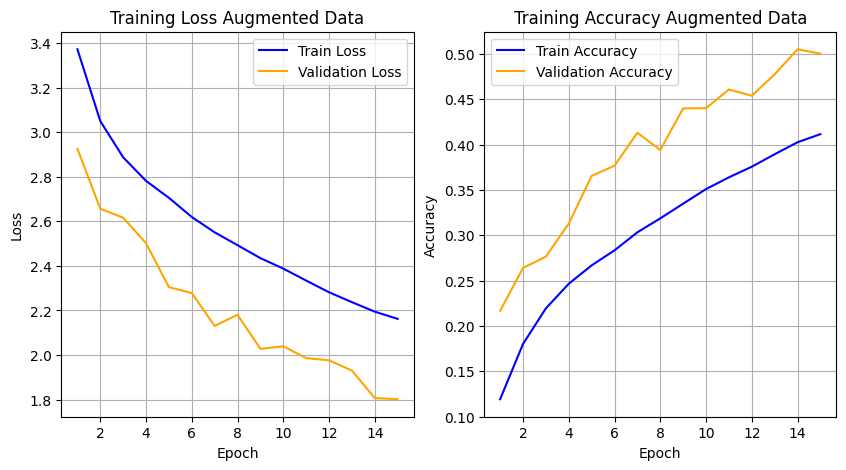


Per-class Accuracy:
Accuracy for class 'acoustic       ': 33.2%
Accuracy for class 'antenna        ': 42.7%
Accuracy for class 'bacteria       ': 39.7%
Accuracy for class 'battery        ': 55.0%
Accuracy for class 'bean           ': 31.4%
Accuracy for class 'beetle         ': 61.5%
Accuracy for class 'bicycle        ': 72.5%
Accuracy for class 'birch          ': 34.8%
Accuracy for class 'bird           ': 15.2%
Accuracy for class 'bomb           ': 49.5%
Accuracy for class 'bread          ': 28.1%
Accuracy for class 'bridge         ': 68.9%
Accuracy for class 'camera         ': 72.4%
Accuracy for class 'carbon         ': 13.7%
Accuracy for class 'cat            ': 55.0%
Accuracy for class 'corn           ': 27.2%
Accuracy for class 'crab           ': 21.8%
Accuracy for class 'crocodilian    ': 52.8%
Accuracy for class 'echinoderm     ': 30.0%
Accuracy for class 'egg            ': 30.9%
Accuracy for class 'elephant       ': 62.4%
Accuracy for class 'fish           ': 51.6%
Accuracy fo

In [25]:
training_plot(
    epochs=15,
    train_loss=train_loss,
    train_acc=train_acc,
    val_loss=val_loss,
    val_acc=val_acc,
    title=" Augmented Data"
)
y_true, y_pred = evaluate(model, valloader, classes=class_names, device=device)


#### Conclusion
- The training loss is constanlty dropping, so if we train it for more epochs we should get better results. We can se that the accuracy is increasing
- The final results with agumentation are slightly lower then normal, but this is a common practice, so I will use it for future tests

# Testing RandomApply - Data Agumentation, to have 50% of clean data and 50% of modified

In [ ]:
train_transform_random = transforms.Compose([
    transforms.RandomApply([
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip()
    ], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.ImageFolder(
    root='train/train',
    transform=train_transform_random
)
val_dataset = torchvision.datasets.ImageFolder(
    root='train/train',
    transform=val_transform
)


random_apply_train_subset = torch.utils.data.Subset(train_dataset, train_indices)
random_apply_val_subset = torch.utils.data.Subset(val_dataset, val_indices)

random_apply_trainloader = create_dataloader(random_apply_train_subset, batch_size=128, shuffle=True, num_workers=2)
random_apply_valloader = create_dataloader(random_apply_val_subset, batch_size=128, shuffle=False, num_workers=2)

Training Epoch [1/15]: 100%|██████████| 551/551 [00:58<00:00,  9.45it/s]


Training -> Loss: 3.2774 - Acc: 13.96%


Validating Epoch [1/15]: 100%|██████████| 138/138 [00:18<00:00,  7.44it/s]


Validation -> Loss: 2.9716 - Acc: 20.55%


Training Epoch [2/15]: 100%|██████████| 551/551 [00:56<00:00,  9.72it/s]


Training -> Loss: 2.8939 - Acc: 22.03%


Validating Epoch [2/15]: 100%|██████████| 138/138 [00:18<00:00,  7.44it/s]


Validation -> Loss: 2.5783 - Acc: 29.88%


Training Epoch [3/15]: 100%|██████████| 551/551 [00:57<00:00,  9.52it/s]


Training -> Loss: 2.7285 - Acc: 26.03%


Validating Epoch [3/15]: 100%|██████████| 138/138 [00:19<00:00,  7.24it/s]


Validation -> Loss: 2.3182 - Acc: 36.82%


Training Epoch [4/15]: 100%|██████████| 551/551 [00:58<00:00,  9.44it/s]


Training -> Loss: 2.6112 - Acc: 28.78%


Validating Epoch [4/15]: 100%|██████████| 138/138 [00:18<00:00,  7.56it/s]


Validation -> Loss: 2.3050 - Acc: 36.11%


Training Epoch [5/15]: 100%|██████████| 551/551 [00:57<00:00,  9.58it/s]


Training -> Loss: 2.5150 - Acc: 31.12%


Validating Epoch [5/15]: 100%|██████████| 138/138 [00:18<00:00,  7.47it/s]


Validation -> Loss: 2.1826 - Acc: 40.95%


Training Epoch [6/15]: 100%|██████████| 551/551 [00:57<00:00,  9.65it/s]


Training -> Loss: 2.4364 - Acc: 33.49%


Validating Epoch [6/15]: 100%|██████████| 138/138 [00:17<00:00,  7.70it/s]


Validation -> Loss: 2.1112 - Acc: 43.07%


Training Epoch [7/15]: 100%|██████████| 551/551 [00:57<00:00,  9.64it/s]


Training -> Loss: 2.3705 - Acc: 35.07%


Validating Epoch [7/15]: 100%|██████████| 138/138 [00:18<00:00,  7.52it/s]


Validation -> Loss: 2.0737 - Acc: 43.03%


Training Epoch [8/15]: 100%|██████████| 551/551 [00:57<00:00,  9.64it/s]


Training -> Loss: 2.3003 - Acc: 37.02%


Validating Epoch [8/15]: 100%|██████████| 138/138 [00:19<00:00,  7.11it/s]


Validation -> Loss: 1.9747 - Acc: 46.26%


Training Epoch [9/15]: 100%|██████████| 551/551 [00:58<00:00,  9.48it/s]


Training -> Loss: 2.2373 - Acc: 38.57%


Validating Epoch [9/15]: 100%|██████████| 138/138 [00:18<00:00,  7.53it/s]


Validation -> Loss: 1.9023 - Acc: 47.80%


Training Epoch [10/15]: 100%|██████████| 551/551 [00:59<00:00,  9.24it/s]


Training -> Loss: 2.1843 - Acc: 40.03%


Validating Epoch [10/15]: 100%|██████████| 138/138 [00:22<00:00,  6.24it/s]


Validation -> Loss: 1.8750 - Acc: 48.59%


Training Epoch [11/15]: 100%|██████████| 551/551 [00:58<00:00,  9.43it/s]


Training -> Loss: 2.1407 - Acc: 41.00%


Validating Epoch [11/15]: 100%|██████████| 138/138 [00:19<00:00,  7.11it/s]


Validation -> Loss: 1.8049 - Acc: 50.45%


Training Epoch [12/15]: 100%|██████████| 551/551 [00:56<00:00,  9.70it/s]


Training -> Loss: 2.0885 - Acc: 42.67%


Validating Epoch [12/15]: 100%|██████████| 138/138 [00:17<00:00,  7.75it/s]


Validation -> Loss: 1.7332 - Acc: 52.28%


Training Epoch [13/15]: 100%|██████████| 551/551 [00:58<00:00,  9.34it/s]


Training -> Loss: 2.0429 - Acc: 43.92%


Validating Epoch [13/15]: 100%|██████████| 138/138 [00:17<00:00,  7.71it/s]


Validation -> Loss: 1.7161 - Acc: 52.69%


Training Epoch [14/15]: 100%|██████████| 551/551 [00:56<00:00,  9.78it/s]


Training -> Loss: 1.9949 - Acc: 45.13%


Validating Epoch [14/15]: 100%|██████████| 138/138 [00:17<00:00,  7.72it/s]


Validation -> Loss: 1.7349 - Acc: 52.03%


Training Epoch [15/15]: 100%|██████████| 551/551 [00:58<00:00,  9.38it/s]


Training -> Loss: 1.9426 - Acc: 46.63%


Validating Epoch [15/15]: 100%|██████████| 138/138 [00:20<00:00,  6.82it/s]


Validation -> Loss: 1.6793 - Acc: 53.52%
Finished Training


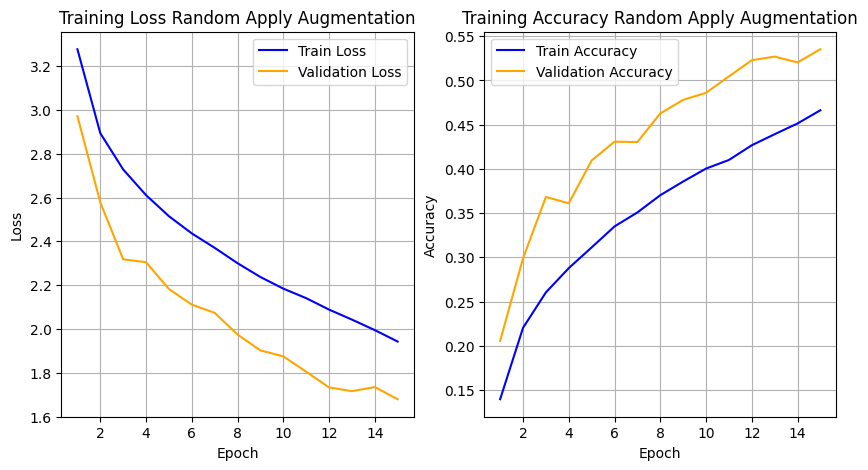


Per-class Accuracy:
Accuracy for class 'acoustic       ': 38.3%
Accuracy for class 'antenna        ': 49.3%
Accuracy for class 'bacteria       ': 54.1%
Accuracy for class 'battery        ': 53.0%
Accuracy for class 'bean           ': 48.3%
Accuracy for class 'beetle         ': 73.5%
Accuracy for class 'bicycle        ': 74.2%
Accuracy for class 'birch          ': 47.8%
Accuracy for class 'bird           ': 21.0%
Accuracy for class 'bomb           ': 47.9%
Accuracy for class 'bread          ': 30.6%
Accuracy for class 'bridge         ': 67.3%
Accuracy for class 'camera         ': 66.3%
Accuracy for class 'carbon         ': 16.7%
Accuracy for class 'cat            ': 54.1%
Accuracy for class 'corn           ': 34.0%
Accuracy for class 'crab           ': 30.6%
Accuracy for class 'crocodilian    ': 53.0%
Accuracy for class 'echinoderm     ': 38.2%
Accuracy for class 'egg            ': 53.7%
Accuracy for class 'elephant       ': 73.0%
Accuracy for class 'fish           ': 45.5%
Accuracy fo

In [29]:
model = BetterNet().to(device)
criterion = nn.CrossEntropyLoss()
model, train_loss, train_acc, val_loss, val_acc = run_experiment(
    model=model,
    train_loader=random_apply_trainloader,
    val_loader=random_apply_valloader,
    class_names=class_names,
    device=device,
    criterion=criterion,
    learning_rate=0.001,
    weight_decay=1e-4,
    epochs=15
)

training_plot(
    epochs=15,
    train_loss=train_loss,
    train_acc=train_acc,
    val_loss=val_loss,
    val_acc=val_acc,
    title=" Random Apply Augmentation"
)
y_true, y_pred = evaluate(model, random_apply_valloader, classes=class_names, device=device)

#### Conclusions
- Randomly applying augmentations to the images with a probability of 50% seems to improve model performance during training

# AVGPoolNet
Using avgpool instead of maxpool

In [32]:
class AVGPoolNet(nn.Module):
    def __init__(self, num_classes=50):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [33]:
ag_trainloader = create_dataloader(random_apply_train_subset, batch_size=128, shuffle=True, num_workers=2)
ag_valloader = create_dataloader(random_apply_val_subset, batch_size=128, shuffle=False, num_workers=2)

Training Epoch [1/15]: 100%|██████████| 551/551 [00:58<00:00,  9.41it/s]


Training -> Loss: 3.1944 - Acc: 16.45%


Validating Epoch [1/15]: 100%|██████████| 138/138 [00:18<00:00,  7.46it/s]


Validation -> Loss: 2.7852 - Acc: 24.51%


Training Epoch [2/15]: 100%|██████████| 551/551 [00:58<00:00,  9.36it/s]


Training -> Loss: 2.7929 - Acc: 24.77%


Validating Epoch [2/15]: 100%|██████████| 138/138 [00:17<00:00,  7.96it/s]


Validation -> Loss: 2.4728 - Acc: 33.52%


Training Epoch [3/15]: 100%|██████████| 551/551 [00:57<00:00,  9.51it/s]


Training -> Loss: 2.5889 - Acc: 29.79%


Validating Epoch [3/15]: 100%|██████████| 138/138 [00:19<00:00,  7.07it/s]


Validation -> Loss: 2.2749 - Acc: 37.39%


Training Epoch [4/15]: 100%|██████████| 551/551 [00:57<00:00,  9.55it/s]


Training -> Loss: 2.4472 - Acc: 33.14%


Validating Epoch [4/15]: 100%|██████████| 138/138 [00:19<00:00,  7.20it/s]


Validation -> Loss: 2.1488 - Acc: 41.29%


Training Epoch [5/15]: 100%|██████████| 551/551 [01:03<00:00,  8.66it/s]


Training -> Loss: 2.3283 - Acc: 36.07%


Validating Epoch [5/15]: 100%|██████████| 138/138 [00:17<00:00,  7.80it/s]


Validation -> Loss: 2.0026 - Acc: 44.46%


Training Epoch [6/15]: 100%|██████████| 551/551 [00:59<00:00,  9.34it/s]


Training -> Loss: 2.2511 - Acc: 38.08%


Validating Epoch [6/15]: 100%|██████████| 138/138 [00:22<00:00,  6.20it/s]


Validation -> Loss: 1.9243 - Acc: 47.44%


Training Epoch [7/15]: 100%|██████████| 551/551 [01:09<00:00,  7.96it/s]


Training -> Loss: 2.1740 - Acc: 40.20%


Validating Epoch [7/15]: 100%|██████████| 138/138 [00:21<00:00,  6.40it/s]


Validation -> Loss: 1.9339 - Acc: 46.11%


Training Epoch [8/15]: 100%|██████████| 551/551 [01:08<00:00,  8.08it/s]


Training -> Loss: 2.1106 - Acc: 41.98%


Validating Epoch [8/15]: 100%|██████████| 138/138 [00:18<00:00,  7.37it/s]


Validation -> Loss: 1.8818 - Acc: 48.52%


Training Epoch [9/15]: 100%|██████████| 551/551 [01:02<00:00,  8.84it/s]


Training -> Loss: 2.0569 - Acc: 43.17%


Validating Epoch [9/15]: 100%|██████████| 138/138 [00:18<00:00,  7.48it/s]


Validation -> Loss: 1.8489 - Acc: 49.10%


Training Epoch [10/15]: 100%|██████████| 551/551 [01:04<00:00,  8.53it/s]


Training -> Loss: 1.9985 - Acc: 44.67%


Validating Epoch [10/15]: 100%|██████████| 138/138 [00:21<00:00,  6.38it/s]


Validation -> Loss: 1.7632 - Acc: 51.04%


Training Epoch [11/15]: 100%|██████████| 551/551 [01:02<00:00,  8.88it/s]


Training -> Loss: 1.9563 - Acc: 45.95%


Validating Epoch [11/15]: 100%|██████████| 138/138 [00:18<00:00,  7.42it/s]


Validation -> Loss: 1.7246 - Acc: 52.01%


Training Epoch [12/15]: 100%|██████████| 551/551 [00:53<00:00, 10.25it/s]


Training -> Loss: 1.9168 - Acc: 47.03%


Validating Epoch [12/15]: 100%|██████████| 138/138 [00:18<00:00,  7.66it/s]


Validation -> Loss: 1.6992 - Acc: 53.51%


Training Epoch [13/15]: 100%|██████████| 551/551 [00:54<00:00, 10.16it/s]


Training -> Loss: 1.8738 - Acc: 48.21%


Validating Epoch [13/15]: 100%|██████████| 138/138 [00:18<00:00,  7.44it/s]


Validation -> Loss: 1.6860 - Acc: 53.49%


Training Epoch [14/15]: 100%|██████████| 551/551 [01:04<00:00,  8.49it/s]


Training -> Loss: 1.8316 - Acc: 49.21%


Validating Epoch [14/15]: 100%|██████████| 138/138 [00:21<00:00,  6.57it/s]


Validation -> Loss: 1.6027 - Acc: 55.73%


Training Epoch [15/15]: 100%|██████████| 551/551 [00:55<00:00,  9.97it/s]


Training -> Loss: 1.7862 - Acc: 50.43%


Validating Epoch [15/15]: 100%|██████████| 138/138 [00:19<00:00,  7.23it/s]


Validation -> Loss: 1.6051 - Acc: 55.67%
Finished Training


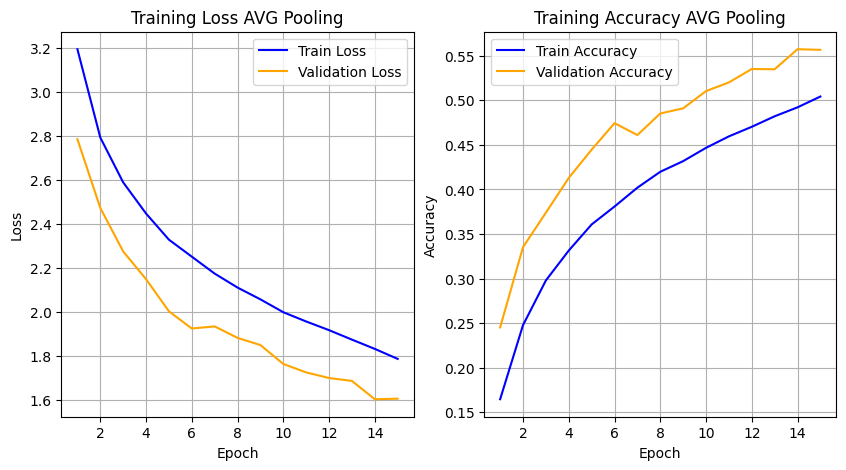


Per-class Accuracy:
Accuracy for class 'acoustic       ': 56.6%
Accuracy for class 'antenna        ': 58.7%
Accuracy for class 'bacteria       ': 41.7%
Accuracy for class 'battery        ': 63.8%
Accuracy for class 'bean           ': 36.9%
Accuracy for class 'beetle         ': 63.9%
Accuracy for class 'bicycle        ': 76.2%
Accuracy for class 'birch          ': 69.3%
Accuracy for class 'bird           ': 20.4%
Accuracy for class 'bomb           ': 51.9%
Accuracy for class 'bread          ': 28.5%
Accuracy for class 'bridge         ': 74.3%
Accuracy for class 'camera         ': 71.3%
Accuracy for class 'carbon         ': 24.5%
Accuracy for class 'cat            ': 59.7%
Accuracy for class 'corn           ': 48.1%
Accuracy for class 'crab           ': 32.6%
Accuracy for class 'crocodilian    ': 60.5%
Accuracy for class 'echinoderm     ': 41.1%
Accuracy for class 'egg            ': 25.6%
Accuracy for class 'elephant       ': 68.5%
Accuracy for class 'fish           ': 43.2%
Accuracy fo

In [35]:
model = AVGPoolNet().to(device)
criterion = nn.CrossEntropyLoss()
model, train_loss, train_acc, val_loss, val_acc = run_experiment(
    model=model,
    train_loader=ag_trainloader,
    val_loader=ag_valloader,
    class_names=class_names,
    device=device,
    criterion=criterion,
    learning_rate=0.001,
    weight_decay=1e-4,
    epochs=15
)

training_plot(
    epochs=15,
    train_loss=train_loss,
    train_acc=train_acc,
    val_loss=val_loss,
    val_acc=val_acc,
    title=" AVG Pooling"
)

y_true, y_pred = evaluate(model, ag_valloader, classes=class_names, device=device)

#### Conclusions
- Average pooling may achieve better results than max pooling — at least in my experiments, it yielded slightly better results

# Improved AVGPoolNet
- GeLU 
- AdaptiveAvgPool2d

In [52]:
class ImprovedAVGPoolNet(nn.Module):
    def __init__(self, num_classes=50):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 512),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

Training Epoch [1/15]: 100%|██████████| 551/551 [01:03<00:00,  8.69it/s]


Training -> Loss: 3.2928 - Acc: 12.99%


Validating Epoch [1/15]: 100%|██████████| 138/138 [00:20<00:00,  6.82it/s]


Validation -> Loss: 2.9709 - Acc: 19.82%


Training Epoch [2/15]: 100%|██████████| 551/551 [00:58<00:00,  9.42it/s]


Training -> Loss: 2.9751 - Acc: 19.25%


Validating Epoch [2/15]: 100%|██████████| 138/138 [00:18<00:00,  7.42it/s]


Validation -> Loss: 2.7155 - Acc: 24.90%


Training Epoch [3/15]: 100%|██████████| 551/551 [00:58<00:00,  9.37it/s]


Training -> Loss: 2.8177 - Acc: 23.01%


Validating Epoch [3/15]: 100%|██████████| 138/138 [00:18<00:00,  7.45it/s]


Validation -> Loss: 2.6634 - Acc: 26.71%


Training Epoch [4/15]: 100%|██████████| 551/551 [00:58<00:00,  9.37it/s]


Training -> Loss: 2.7140 - Acc: 25.72%


Validating Epoch [4/15]: 100%|██████████| 138/138 [00:19<00:00,  7.25it/s]


Validation -> Loss: 2.5861 - Acc: 29.25%


Training Epoch [5/15]: 100%|██████████| 551/551 [00:58<00:00,  9.42it/s]


Training -> Loss: 2.6328 - Acc: 27.53%


Validating Epoch [5/15]: 100%|██████████| 138/138 [00:18<00:00,  7.27it/s]


Validation -> Loss: 2.3803 - Acc: 34.45%


Training Epoch [6/15]: 100%|██████████| 551/551 [01:02<00:00,  8.86it/s]


Training -> Loss: 2.5616 - Acc: 29.68%


Validating Epoch [6/15]: 100%|██████████| 138/138 [00:19<00:00,  6.94it/s]


Validation -> Loss: 2.3372 - Acc: 35.36%


Training Epoch [7/15]: 100%|██████████| 551/551 [01:08<00:00,  8.05it/s]


Training -> Loss: 2.5057 - Acc: 30.86%


Validating Epoch [7/15]: 100%|██████████| 138/138 [00:20<00:00,  6.73it/s]


Validation -> Loss: 2.4164 - Acc: 33.78%


Training Epoch [8/15]: 100%|██████████| 551/551 [01:00<00:00,  9.14it/s]


Training -> Loss: 2.4522 - Acc: 32.44%


Validating Epoch [8/15]: 100%|██████████| 138/138 [00:19<00:00,  7.18it/s]


Validation -> Loss: 2.3452 - Acc: 35.45%


Training Epoch [9/15]: 100%|██████████| 551/551 [01:03<00:00,  8.61it/s]


Training -> Loss: 2.4150 - Acc: 33.31%


Validating Epoch [9/15]: 100%|██████████| 138/138 [00:22<00:00,  6.22it/s]


Validation -> Loss: 2.1935 - Acc: 39.20%


Training Epoch [10/15]: 100%|██████████| 551/551 [01:04<00:00,  8.57it/s]


Training -> Loss: 2.3682 - Acc: 34.50%


Validating Epoch [10/15]: 100%|██████████| 138/138 [00:22<00:00,  6.27it/s]


Validation -> Loss: 2.4328 - Acc: 33.93%


Training Epoch [11/15]: 100%|██████████| 551/551 [01:03<00:00,  8.67it/s]


Training -> Loss: 2.3354 - Acc: 35.42%


Validating Epoch [11/15]: 100%|██████████| 138/138 [00:18<00:00,  7.61it/s]


Validation -> Loss: 2.1256 - Acc: 41.22%


Training Epoch [12/15]: 100%|██████████| 551/551 [00:56<00:00,  9.76it/s]


Training -> Loss: 2.2953 - Acc: 36.36%


Validating Epoch [12/15]: 100%|██████████| 138/138 [00:21<00:00,  6.55it/s]


Validation -> Loss: 2.2184 - Acc: 38.46%


Training Epoch [13/15]: 100%|██████████| 551/551 [00:58<00:00,  9.36it/s]


Training -> Loss: 2.2750 - Acc: 36.71%


Validating Epoch [13/15]: 100%|██████████| 138/138 [00:19<00:00,  6.92it/s]


Validation -> Loss: 2.1174 - Acc: 41.24%


Training Epoch [14/15]: 100%|██████████| 551/551 [01:00<00:00,  9.09it/s]


Training -> Loss: 2.2321 - Acc: 38.08%


Validating Epoch [14/15]: 100%|██████████| 138/138 [00:19<00:00,  6.98it/s]


Validation -> Loss: 2.0072 - Acc: 44.05%


Training Epoch [15/15]: 100%|██████████| 551/551 [01:05<00:00,  8.36it/s]


Training -> Loss: 2.2125 - Acc: 38.63%


Validating Epoch [15/15]: 100%|██████████| 138/138 [00:21<00:00,  6.55it/s]


Validation -> Loss: 1.9971 - Acc: 44.58%
Finished Training


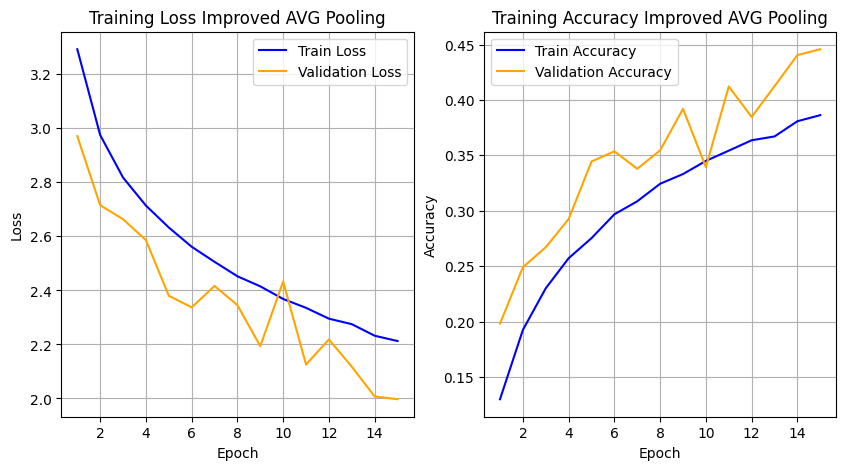


Per-class Accuracy:
Accuracy for class 'acoustic       ': 21.4%
Accuracy for class 'antenna        ': 52.5%
Accuracy for class 'bacteria       ': 37.7%
Accuracy for class 'battery        ': 43.3%
Accuracy for class 'bean           ': 36.9%
Accuracy for class 'beetle         ': 54.4%
Accuracy for class 'bicycle        ': 73.4%
Accuracy for class 'birch          ': 47.8%
Accuracy for class 'bird           ': 17.8%
Accuracy for class 'bomb           ': 40.4%
Accuracy for class 'bread          ': 25.2%
Accuracy for class 'bridge         ': 58.2%
Accuracy for class 'camera         ': 63.3%
Accuracy for class 'carbon         ': 28.4%
Accuracy for class 'cat            ': 47.5%
Accuracy for class 'corn           ': 28.5%
Accuracy for class 'crab           ': 27.1%
Accuracy for class 'crocodilian    ': 24.9%
Accuracy for class 'echinoderm     ': 26.1%
Accuracy for class 'egg            ': 36.5%
Accuracy for class 'elephant       ': 59.3%
Accuracy for class 'fish           ': 43.4%
Accuracy fo

In [53]:
model = ImprovedAVGPoolNet().to(device)
criterion = nn.CrossEntropyLoss()
model, train_loss, train_acc, val_loss, val_acc = run_experiment(
    model=model,
    train_loader=ag_trainloader,
    val_loader=ag_valloader,
    class_names=class_names,
    device=device,
    criterion=criterion,
    learning_rate=0.001,
    weight_decay=1e-4,
    epochs=15
)

training_plot(
    epochs=15,
    train_loss=train_loss,
    train_acc=train_acc,
    val_loss=val_loss,
    val_acc=val_acc,
    title=" Improved AVG Pooling"
)

y_true, y_pred = evaluate(model, ag_valloader, classes=class_names, device=device)

### 100 Epochs Trainings
- Additionally i will add scheduler to modify LR

In [56]:
def train_and_save_model(
    model,
    train_loader,
    criterion,
    optimizer,
    device,
    epochs,
    validation_loader,
    scheduler=None,
    save_path_acc="best_model_acc.pth",
    save_path_loss="best_model_loss.pth"
):
    epoch_acc = []
    epoch_loss = []

    val_acc_list = []
    val_loss_list = []

    best_val_acc = 0.0
    lowest_val_loss = float('inf')

    best_acc_model_wts = model.state_dict()
    best_loss_model_wts = model.state_dict()

    for epoch in range(epochs):
        batch_acc = []
        running_loss = 0.0

        model.train()
        for i, data in tqdm(enumerate(train_loader, 0), desc=f"Training Epoch [{epoch+1}/{epochs}]", total=len(train_loader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            accuracy = accuracy_score(
                labels.cpu().numpy(),
                torch.argmax(outputs, dim=1).cpu().numpy()
            )
            batch_acc.append(accuracy)

        avg_loss = running_loss / len(train_loader)
        avg_acc = sum(batch_acc) / len(batch_acc)

        print(f"Training -> Loss: {avg_loss:.4f} - Acc: {avg_acc * 100:.2f}%")

        epoch_loss.append(avg_loss)
        epoch_acc.append(avg_acc)

        model.eval()
        val_labels = []
        val_preds = []
        val_loss = 0.0

        with torch.no_grad():
            for data in tqdm(validation_loader, desc=f"Validating Epoch [{epoch+1}/{epochs}]", total=len(validation_loader)):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predictions = torch.max(outputs, 1)
                val_preds.extend(predictions.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss /= len(validation_loader)
        val_acc = accuracy_score(val_labels, val_preds)

        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

        print(f"Validation -> Loss: {val_loss:.4f} - Acc: {val_acc * 100:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_acc_model_wts = model.state_dict()
            print(f"New best ACC model found! Saved at epoch {epoch+1} to {save_path_acc}.")

        if val_loss < lowest_val_loss:
            lowest_val_loss = val_loss
            best_loss_model_wts = model.state_dict()
            print(f"New best LOSS model found! Saved at epoch {epoch+1} to {save_path_loss}.")

        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

    print("Finished Training")

    # saving
    torch.save(best_acc_model_wts, save_path_acc)
    torch.save(best_loss_model_wts, save_path_loss)
    print(f"Best ACC model saved to {save_path_acc}")
    print(f"Best LOSS model saved to {save_path_loss}")


    model.load_state_dict(best_acc_model_wts)

    return model, epoch_loss, epoch_acc, val_loss_list, val_acc_list


Training Improved AVG Pooling model


Training Epoch [1/100]: 100%|██████████| 551/551 [01:01<00:00,  9.01it/s]


Training -> Loss: 3.2768 - Acc: 13.32%


Validating Epoch [1/100]: 100%|██████████| 138/138 [00:18<00:00,  7.31it/s]


Validation -> Loss: 2.9841 - Acc: 18.60%
New best ACC model found! Saved at epoch 1 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 1 to iavg_best_model_loss.pth.


Training Epoch [2/100]: 100%|██████████| 551/551 [00:58<00:00,  9.35it/s]


Training -> Loss: 2.9579 - Acc: 19.75%


Validating Epoch [2/100]: 100%|██████████| 138/138 [00:18<00:00,  7.35it/s]


Validation -> Loss: 2.7498 - Acc: 24.60%
New best ACC model found! Saved at epoch 2 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 2 to iavg_best_model_loss.pth.


Training Epoch [3/100]: 100%|██████████| 551/551 [00:58<00:00,  9.44it/s]


Training -> Loss: 2.8081 - Acc: 23.26%


Validating Epoch [3/100]: 100%|██████████| 138/138 [00:19<00:00,  7.01it/s]


Validation -> Loss: 2.5251 - Acc: 30.18%
New best ACC model found! Saved at epoch 3 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 3 to iavg_best_model_loss.pth.


Training Epoch [4/100]: 100%|██████████| 551/551 [01:00<00:00,  9.18it/s]


Training -> Loss: 2.7062 - Acc: 25.91%


Validating Epoch [4/100]: 100%|██████████| 138/138 [00:19<00:00,  7.10it/s]


Validation -> Loss: 2.4764 - Acc: 32.30%
New best ACC model found! Saved at epoch 4 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 4 to iavg_best_model_loss.pth.


Training Epoch [5/100]: 100%|██████████| 551/551 [00:58<00:00,  9.39it/s]


Training -> Loss: 2.6198 - Acc: 28.19%


Validating Epoch [5/100]: 100%|██████████| 138/138 [00:19<00:00,  7.16it/s]


Validation -> Loss: 2.4899 - Acc: 31.73%


Training Epoch [6/100]: 100%|██████████| 551/551 [00:58<00:00,  9.43it/s]


Training -> Loss: 2.5568 - Acc: 29.83%


Validating Epoch [6/100]: 100%|██████████| 138/138 [00:19<00:00,  7.03it/s]


Validation -> Loss: 2.2884 - Acc: 37.17%
New best ACC model found! Saved at epoch 6 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 6 to iavg_best_model_loss.pth.


Training Epoch [7/100]: 100%|██████████| 551/551 [00:58<00:00,  9.40it/s]


Training -> Loss: 2.4921 - Acc: 31.36%


Validating Epoch [7/100]: 100%|██████████| 138/138 [00:18<00:00,  7.55it/s]


Validation -> Loss: 2.2674 - Acc: 37.95%
New best ACC model found! Saved at epoch 7 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 7 to iavg_best_model_loss.pth.


Training Epoch [8/100]: 100%|██████████| 551/551 [00:58<00:00,  9.43it/s]


Training -> Loss: 2.4369 - Acc: 32.87%


Validating Epoch [8/100]: 100%|██████████| 138/138 [00:19<00:00,  7.17it/s]


Validation -> Loss: 2.2353 - Acc: 38.29%
New best ACC model found! Saved at epoch 8 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 8 to iavg_best_model_loss.pth.


Training Epoch [9/100]: 100%|██████████| 551/551 [01:00<00:00,  9.11it/s]


Training -> Loss: 2.4033 - Acc: 33.79%


Validating Epoch [9/100]: 100%|██████████| 138/138 [00:18<00:00,  7.46it/s]


Validation -> Loss: 2.2031 - Acc: 38.77%
New best ACC model found! Saved at epoch 9 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 9 to iavg_best_model_loss.pth.


Training Epoch [10/100]: 100%|██████████| 551/551 [01:00<00:00,  9.12it/s]


Training -> Loss: 2.3491 - Acc: 34.86%


Validating Epoch [10/100]: 100%|██████████| 138/138 [00:18<00:00,  7.43it/s]


Validation -> Loss: 2.1143 - Acc: 41.95%
New best ACC model found! Saved at epoch 10 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 10 to iavg_best_model_loss.pth.


Training Epoch [11/100]: 100%|██████████| 551/551 [00:59<00:00,  9.33it/s]


Training -> Loss: 2.3113 - Acc: 36.33%


Validating Epoch [11/100]: 100%|██████████| 138/138 [00:19<00:00,  7.22it/s]


Validation -> Loss: 2.1107 - Acc: 40.82%
New best LOSS model found! Saved at epoch 11 to iavg_best_model_loss.pth.


Training Epoch [12/100]: 100%|██████████| 551/551 [00:59<00:00,  9.24it/s]


Training -> Loss: 2.2820 - Acc: 36.84%


Validating Epoch [12/100]: 100%|██████████| 138/138 [00:18<00:00,  7.37it/s]


Validation -> Loss: 2.0721 - Acc: 42.69%
New best ACC model found! Saved at epoch 12 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 12 to iavg_best_model_loss.pth.


Training Epoch [13/100]: 100%|██████████| 551/551 [00:58<00:00,  9.42it/s]


Training -> Loss: 2.2424 - Acc: 37.59%


Validating Epoch [13/100]: 100%|██████████| 138/138 [00:19<00:00,  7.21it/s]


Validation -> Loss: 2.0790 - Acc: 42.23%


Training Epoch [14/100]: 100%|██████████| 551/551 [00:58<00:00,  9.41it/s]


Training -> Loss: 2.2171 - Acc: 38.58%


Validating Epoch [14/100]: 100%|██████████| 138/138 [00:19<00:00,  7.11it/s]


Validation -> Loss: 2.0394 - Acc: 43.71%
New best ACC model found! Saved at epoch 14 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 14 to iavg_best_model_loss.pth.


Training Epoch [15/100]: 100%|██████████| 551/551 [00:59<00:00,  9.34it/s]


Training -> Loss: 2.1930 - Acc: 39.06%


Validating Epoch [15/100]: 100%|██████████| 138/138 [00:18<00:00,  7.35it/s]


Validation -> Loss: 1.9997 - Acc: 44.63%
New best ACC model found! Saved at epoch 15 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 15 to iavg_best_model_loss.pth.


Training Epoch [16/100]: 100%|██████████| 551/551 [00:59<00:00,  9.31it/s]


Training -> Loss: 2.1657 - Acc: 39.65%


Validating Epoch [16/100]: 100%|██████████| 138/138 [00:19<00:00,  7.15it/s]


Validation -> Loss: 1.9952 - Acc: 44.20%
New best LOSS model found! Saved at epoch 16 to iavg_best_model_loss.pth.


Training Epoch [17/100]: 100%|██████████| 551/551 [00:59<00:00,  9.24it/s]


Training -> Loss: 2.1448 - Acc: 40.31%


Validating Epoch [17/100]: 100%|██████████| 138/138 [00:19<00:00,  7.02it/s]


Validation -> Loss: 1.9568 - Acc: 45.86%
New best ACC model found! Saved at epoch 17 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 17 to iavg_best_model_loss.pth.


Training Epoch [18/100]: 100%|██████████| 551/551 [00:59<00:00,  9.22it/s]


Training -> Loss: 2.1266 - Acc: 40.95%


Validating Epoch [18/100]: 100%|██████████| 138/138 [00:18<00:00,  7.47it/s]


Validation -> Loss: 1.9895 - Acc: 44.99%


Training Epoch [19/100]: 100%|██████████| 551/551 [01:00<00:00,  9.12it/s]


Training -> Loss: 2.1079 - Acc: 41.30%


Validating Epoch [19/100]: 100%|██████████| 138/138 [00:19<00:00,  7.25it/s]


Validation -> Loss: 1.8897 - Acc: 47.65%
New best ACC model found! Saved at epoch 19 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 19 to iavg_best_model_loss.pth.


Training Epoch [20/100]: 100%|██████████| 551/551 [01:02<00:00,  8.79it/s]


Training -> Loss: 2.0833 - Acc: 41.81%


Validating Epoch [20/100]: 100%|██████████| 138/138 [00:19<00:00,  6.98it/s]


Validation -> Loss: 1.9204 - Acc: 46.53%


Training Epoch [21/100]: 100%|██████████| 551/551 [01:00<00:00,  9.03it/s]


Training -> Loss: 2.0692 - Acc: 42.17%


Validating Epoch [21/100]: 100%|██████████| 138/138 [00:19<00:00,  7.20it/s]


Validation -> Loss: 1.8748 - Acc: 47.76%
New best ACC model found! Saved at epoch 21 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 21 to iavg_best_model_loss.pth.


Training Epoch [22/100]: 100%|██████████| 551/551 [01:03<00:00,  8.73it/s]


Training -> Loss: 2.0500 - Acc: 42.50%


Validating Epoch [22/100]: 100%|██████████| 138/138 [00:18<00:00,  7.32it/s]


Validation -> Loss: 1.8607 - Acc: 48.34%
New best ACC model found! Saved at epoch 22 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 22 to iavg_best_model_loss.pth.


Training Epoch [23/100]: 100%|██████████| 551/551 [00:58<00:00,  9.35it/s]


Training -> Loss: 2.0385 - Acc: 43.14%


Validating Epoch [23/100]: 100%|██████████| 138/138 [00:19<00:00,  6.93it/s]


Validation -> Loss: 1.8857 - Acc: 47.57%


Training Epoch [24/100]: 100%|██████████| 551/551 [01:00<00:00,  9.16it/s]


Training -> Loss: 2.0225 - Acc: 43.41%


Validating Epoch [24/100]: 100%|██████████| 138/138 [00:18<00:00,  7.46it/s]


Validation -> Loss: 1.8121 - Acc: 49.96%
New best ACC model found! Saved at epoch 24 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 24 to iavg_best_model_loss.pth.


Training Epoch [25/100]: 100%|██████████| 551/551 [00:58<00:00,  9.43it/s]


Training -> Loss: 2.0036 - Acc: 43.88%


Validating Epoch [25/100]: 100%|██████████| 138/138 [00:19<00:00,  7.23it/s]


Validation -> Loss: 1.8098 - Acc: 49.88%
New best LOSS model found! Saved at epoch 25 to iavg_best_model_loss.pth.


Training Epoch [26/100]: 100%|██████████| 551/551 [00:57<00:00,  9.56it/s]


Training -> Loss: 1.9912 - Acc: 44.29%


Validating Epoch [26/100]: 100%|██████████| 138/138 [00:19<00:00,  7.15it/s]


Validation -> Loss: 1.8413 - Acc: 48.49%


Training Epoch [27/100]: 100%|██████████| 551/551 [00:59<00:00,  9.27it/s]


Training -> Loss: 1.9794 - Acc: 44.54%


Validating Epoch [27/100]: 100%|██████████| 138/138 [00:18<00:00,  7.46it/s]


Validation -> Loss: 1.7962 - Acc: 50.18%
New best ACC model found! Saved at epoch 27 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 27 to iavg_best_model_loss.pth.


Training Epoch [28/100]: 100%|██████████| 551/551 [00:58<00:00,  9.50it/s]


Training -> Loss: 1.9704 - Acc: 44.65%


Validating Epoch [28/100]: 100%|██████████| 138/138 [00:18<00:00,  7.28it/s]


Validation -> Loss: 1.8050 - Acc: 49.57%


Training Epoch [29/100]: 100%|██████████| 551/551 [00:59<00:00,  9.22it/s]


Training -> Loss: 1.9621 - Acc: 45.13%


Validating Epoch [29/100]: 100%|██████████| 138/138 [00:19<00:00,  7.18it/s]


Validation -> Loss: 1.7859 - Acc: 50.33%
New best ACC model found! Saved at epoch 29 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 29 to iavg_best_model_loss.pth.


Training Epoch [30/100]: 100%|██████████| 551/551 [00:58<00:00,  9.45it/s]


Training -> Loss: 1.9455 - Acc: 45.46%


Validating Epoch [30/100]: 100%|██████████| 138/138 [00:18<00:00,  7.27it/s]


Validation -> Loss: 1.7916 - Acc: 50.05%


Training Epoch [31/100]: 100%|██████████| 551/551 [00:59<00:00,  9.32it/s]


Training -> Loss: 1.9384 - Acc: 45.58%


Validating Epoch [31/100]: 100%|██████████| 138/138 [00:18<00:00,  7.44it/s]


Validation -> Loss: 1.7587 - Acc: 51.27%
New best ACC model found! Saved at epoch 31 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 31 to iavg_best_model_loss.pth.


Training Epoch [32/100]: 100%|██████████| 551/551 [00:58<00:00,  9.44it/s]


Training -> Loss: 1.9239 - Acc: 45.86%


Validating Epoch [32/100]: 100%|██████████| 138/138 [00:18<00:00,  7.27it/s]


Validation -> Loss: 1.7346 - Acc: 51.75%
New best ACC model found! Saved at epoch 32 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 32 to iavg_best_model_loss.pth.


Training Epoch [33/100]: 100%|██████████| 551/551 [01:02<00:00,  8.85it/s]


Training -> Loss: 1.9200 - Acc: 45.92%


Validating Epoch [33/100]: 100%|██████████| 138/138 [00:19<00:00,  7.24it/s]


Validation -> Loss: 1.7453 - Acc: 51.28%


Training Epoch [34/100]: 100%|██████████| 551/551 [00:58<00:00,  9.45it/s]


Training -> Loss: 1.9088 - Acc: 46.41%


Validating Epoch [34/100]: 100%|██████████| 138/138 [00:20<00:00,  6.85it/s]


Validation -> Loss: 1.6892 - Acc: 52.84%
New best ACC model found! Saved at epoch 34 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 34 to iavg_best_model_loss.pth.


Training Epoch [35/100]: 100%|██████████| 551/551 [00:59<00:00,  9.19it/s]


Training -> Loss: 1.8935 - Acc: 46.98%


Validating Epoch [35/100]: 100%|██████████| 138/138 [00:20<00:00,  6.80it/s]


Validation -> Loss: 1.6816 - Acc: 53.04%
New best ACC model found! Saved at epoch 35 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 35 to iavg_best_model_loss.pth.


Training Epoch [36/100]: 100%|██████████| 551/551 [00:59<00:00,  9.22it/s]


Training -> Loss: 1.8831 - Acc: 46.98%


Validating Epoch [36/100]: 100%|██████████| 138/138 [00:19<00:00,  7.25it/s]


Validation -> Loss: 1.7244 - Acc: 52.28%


Training Epoch [37/100]: 100%|██████████| 551/551 [00:59<00:00,  9.22it/s]


Training -> Loss: 1.8802 - Acc: 47.02%


Validating Epoch [37/100]: 100%|██████████| 138/138 [00:19<00:00,  7.16it/s]


Validation -> Loss: 1.6915 - Acc: 52.53%


Training Epoch [38/100]: 100%|██████████| 551/551 [01:00<00:00,  9.18it/s]


Training -> Loss: 1.8722 - Acc: 47.25%


Validating Epoch [38/100]: 100%|██████████| 138/138 [00:19<00:00,  6.92it/s]


Validation -> Loss: 1.6693 - Acc: 53.39%
New best ACC model found! Saved at epoch 38 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 38 to iavg_best_model_loss.pth.


Training Epoch [39/100]: 100%|██████████| 551/551 [01:00<00:00,  9.08it/s]


Training -> Loss: 1.8562 - Acc: 47.55%


Validating Epoch [39/100]: 100%|██████████| 138/138 [00:18<00:00,  7.43it/s]


Validation -> Loss: 1.7294 - Acc: 51.60%


Training Epoch [40/100]: 100%|██████████| 551/551 [00:58<00:00,  9.39it/s]


Training -> Loss: 1.8561 - Acc: 47.85%


Validating Epoch [40/100]: 100%|██████████| 138/138 [00:19<00:00,  7.07it/s]


Validation -> Loss: 1.6785 - Acc: 53.30%


Training Epoch [41/100]: 100%|██████████| 551/551 [00:58<00:00,  9.38it/s]


Training -> Loss: 1.8427 - Acc: 48.24%


Validating Epoch [41/100]: 100%|██████████| 138/138 [00:18<00:00,  7.38it/s]


Validation -> Loss: 1.6634 - Acc: 53.52%
New best ACC model found! Saved at epoch 41 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 41 to iavg_best_model_loss.pth.


Training Epoch [42/100]: 100%|██████████| 551/551 [00:59<00:00,  9.33it/s]


Training -> Loss: 1.8396 - Acc: 48.09%


Validating Epoch [42/100]: 100%|██████████| 138/138 [00:18<00:00,  7.37it/s]


Validation -> Loss: 1.7228 - Acc: 52.10%


Training Epoch [43/100]: 100%|██████████| 551/551 [00:58<00:00,  9.45it/s]


Training -> Loss: 1.8318 - Acc: 48.37%


Validating Epoch [43/100]: 100%|██████████| 138/138 [00:19<00:00,  7.06it/s]


Validation -> Loss: 1.6776 - Acc: 53.01%


Training Epoch [44/100]: 100%|██████████| 551/551 [00:59<00:00,  9.30it/s]


Training -> Loss: 1.8219 - Acc: 48.72%


Validating Epoch [44/100]: 100%|██████████| 138/138 [00:19<00:00,  6.99it/s]


Validation -> Loss: 1.6870 - Acc: 52.77%


Training Epoch [45/100]: 100%|██████████| 551/551 [00:58<00:00,  9.36it/s]


Training -> Loss: 1.8134 - Acc: 48.99%


Validating Epoch [45/100]: 100%|██████████| 138/138 [00:19<00:00,  7.05it/s]


Validation -> Loss: 1.6654 - Acc: 53.54%
New best ACC model found! Saved at epoch 45 to iavg_best_model_acc.pth.


Training Epoch [46/100]: 100%|██████████| 551/551 [00:59<00:00,  9.21it/s]


Training -> Loss: 1.8155 - Acc: 48.95%


Validating Epoch [46/100]: 100%|██████████| 138/138 [00:19<00:00,  7.24it/s]


Validation -> Loss: 1.6322 - Acc: 54.62%
New best ACC model found! Saved at epoch 46 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 46 to iavg_best_model_loss.pth.


Training Epoch [47/100]: 100%|██████████| 551/551 [00:59<00:00,  9.30it/s]


Training -> Loss: 1.8053 - Acc: 49.16%


Validating Epoch [47/100]: 100%|██████████| 138/138 [00:18<00:00,  7.38it/s]


Validation -> Loss: 1.6178 - Acc: 54.92%
New best ACC model found! Saved at epoch 47 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 47 to iavg_best_model_loss.pth.


Training Epoch [48/100]: 100%|██████████| 551/551 [00:57<00:00,  9.55it/s]


Training -> Loss: 1.7956 - Acc: 49.44%


Validating Epoch [48/100]: 100%|██████████| 138/138 [00:18<00:00,  7.41it/s]


Validation -> Loss: 1.6337 - Acc: 54.71%


Training Epoch [49/100]: 100%|██████████| 551/551 [00:58<00:00,  9.43it/s]


Training -> Loss: 1.7959 - Acc: 49.30%


Validating Epoch [49/100]: 100%|██████████| 138/138 [00:19<00:00,  7.05it/s]


Validation -> Loss: 1.6441 - Acc: 54.21%


Training Epoch [50/100]: 100%|██████████| 551/551 [01:02<00:00,  8.82it/s]


Training -> Loss: 1.7815 - Acc: 49.69%


Validating Epoch [50/100]: 100%|██████████| 138/138 [00:19<00:00,  7.25it/s]


Validation -> Loss: 1.6806 - Acc: 53.13%


Training Epoch [51/100]: 100%|██████████| 551/551 [00:58<00:00,  9.44it/s]


Training -> Loss: 1.7818 - Acc: 49.88%


Validating Epoch [51/100]: 100%|██████████| 138/138 [00:19<00:00,  7.11it/s]


Validation -> Loss: 1.6246 - Acc: 54.38%


Training Epoch [52/100]: 100%|██████████| 551/551 [01:00<00:00,  9.15it/s]


Training -> Loss: 1.7730 - Acc: 50.09%


Validating Epoch [52/100]: 100%|██████████| 138/138 [00:19<00:00,  7.20it/s]


Validation -> Loss: 1.6125 - Acc: 54.97%
New best ACC model found! Saved at epoch 52 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 52 to iavg_best_model_loss.pth.


Training Epoch [53/100]: 100%|██████████| 551/551 [00:58<00:00,  9.36it/s]


Training -> Loss: 1.7727 - Acc: 50.22%


Validating Epoch [53/100]: 100%|██████████| 138/138 [00:18<00:00,  7.32it/s]


Validation -> Loss: 1.6642 - Acc: 53.80%


Training Epoch [54/100]: 100%|██████████| 551/551 [00:59<00:00,  9.26it/s]


Training -> Loss: 1.7684 - Acc: 50.01%


Validating Epoch [54/100]: 100%|██████████| 138/138 [00:18<00:00,  7.29it/s]


Validation -> Loss: 1.5976 - Acc: 55.27%
New best ACC model found! Saved at epoch 54 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 54 to iavg_best_model_loss.pth.


Training Epoch [55/100]: 100%|██████████| 551/551 [01:01<00:00,  8.90it/s]


Training -> Loss: 1.7526 - Acc: 50.68%


Validating Epoch [55/100]: 100%|██████████| 138/138 [00:19<00:00,  7.12it/s]


Validation -> Loss: 1.5998 - Acc: 55.13%


Training Epoch [56/100]: 100%|██████████| 551/551 [01:00<00:00,  9.08it/s]


Training -> Loss: 1.7535 - Acc: 50.37%


Validating Epoch [56/100]: 100%|██████████| 138/138 [00:20<00:00,  6.87it/s]


Validation -> Loss: 1.6027 - Acc: 55.18%


Training Epoch [57/100]: 100%|██████████| 551/551 [01:00<00:00,  9.05it/s]


Training -> Loss: 1.7508 - Acc: 50.64%


Validating Epoch [57/100]: 100%|██████████| 138/138 [00:19<00:00,  7.09it/s]


Validation -> Loss: 1.6013 - Acc: 55.26%


Training Epoch [58/100]: 100%|██████████| 551/551 [00:59<00:00,  9.22it/s]


Training -> Loss: 1.7418 - Acc: 50.81%


Validating Epoch [58/100]: 100%|██████████| 138/138 [00:19<00:00,  6.96it/s]


Validation -> Loss: 1.5977 - Acc: 55.34%
New best ACC model found! Saved at epoch 58 to iavg_best_model_acc.pth.


Training Epoch [59/100]: 100%|██████████| 551/551 [00:59<00:00,  9.20it/s]


Training -> Loss: 1.7392 - Acc: 50.73%


Validating Epoch [59/100]: 100%|██████████| 138/138 [00:19<00:00,  7.05it/s]


Validation -> Loss: 1.6187 - Acc: 54.63%


Training Epoch [60/100]: 100%|██████████| 551/551 [00:58<00:00,  9.36it/s]


Training -> Loss: 1.7351 - Acc: 51.08%


Validating Epoch [60/100]: 100%|██████████| 138/138 [00:19<00:00,  7.09it/s]


Validation -> Loss: 1.5884 - Acc: 55.82%
New best ACC model found! Saved at epoch 60 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 60 to iavg_best_model_loss.pth.


Training Epoch [61/100]: 100%|██████████| 551/551 [00:59<00:00,  9.23it/s]


Training -> Loss: 1.7271 - Acc: 50.98%


Validating Epoch [61/100]: 100%|██████████| 138/138 [00:18<00:00,  7.32it/s]


Validation -> Loss: 1.6004 - Acc: 54.93%


Training Epoch [62/100]: 100%|██████████| 551/551 [01:01<00:00,  9.00it/s]


Training -> Loss: 1.7256 - Acc: 51.27%


Validating Epoch [62/100]: 100%|██████████| 138/138 [00:20<00:00,  6.89it/s]


Validation -> Loss: 1.5767 - Acc: 56.05%
New best ACC model found! Saved at epoch 62 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 62 to iavg_best_model_loss.pth.


Training Epoch [63/100]: 100%|██████████| 551/551 [01:00<00:00,  9.18it/s]


Training -> Loss: 1.7230 - Acc: 51.14%


Validating Epoch [63/100]: 100%|██████████| 138/138 [00:18<00:00,  7.27it/s]


Validation -> Loss: 1.5672 - Acc: 56.19%
New best ACC model found! Saved at epoch 63 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 63 to iavg_best_model_loss.pth.


Training Epoch [64/100]: 100%|██████████| 551/551 [01:00<00:00,  9.15it/s]


Training -> Loss: 1.7162 - Acc: 51.68%


Validating Epoch [64/100]: 100%|██████████| 138/138 [00:19<00:00,  7.13it/s]


Validation -> Loss: 1.5765 - Acc: 56.20%
New best ACC model found! Saved at epoch 64 to iavg_best_model_acc.pth.


Training Epoch [65/100]: 100%|██████████| 551/551 [00:59<00:00,  9.25it/s]


Training -> Loss: 1.7115 - Acc: 51.56%


Validating Epoch [65/100]: 100%|██████████| 138/138 [00:18<00:00,  7.38it/s]


Validation -> Loss: 1.6067 - Acc: 55.02%


Training Epoch [66/100]: 100%|██████████| 551/551 [00:59<00:00,  9.23it/s]


Training -> Loss: 1.7061 - Acc: 51.59%


Validating Epoch [66/100]: 100%|██████████| 138/138 [00:19<00:00,  7.04it/s]


Validation -> Loss: 1.6101 - Acc: 54.95%


Training Epoch [67/100]: 100%|██████████| 551/551 [00:58<00:00,  9.35it/s]


Training -> Loss: 1.7002 - Acc: 51.99%


Validating Epoch [67/100]: 100%|██████████| 138/138 [00:19<00:00,  6.93it/s]


Validation -> Loss: 1.5716 - Acc: 56.20%


Training Epoch [68/100]: 100%|██████████| 551/551 [01:00<00:00,  9.14it/s]


Training -> Loss: 1.7056 - Acc: 51.80%


Validating Epoch [68/100]: 100%|██████████| 138/138 [00:18<00:00,  7.39it/s]


Validation -> Loss: 1.5752 - Acc: 55.96%


Training Epoch [69/100]: 100%|██████████| 551/551 [00:59<00:00,  9.20it/s]


Training -> Loss: 1.6940 - Acc: 52.01%


Validating Epoch [69/100]: 100%|██████████| 138/138 [00:18<00:00,  7.34it/s]


Validation -> Loss: 1.5851 - Acc: 55.77%


Training Epoch [70/100]: 100%|██████████| 551/551 [00:59<00:00,  9.26it/s]


Training -> Loss: 1.6294 - Acc: 53.72%


Validating Epoch [70/100]: 100%|██████████| 138/138 [00:19<00:00,  7.19it/s]


Validation -> Loss: 1.5018 - Acc: 58.40%
New best ACC model found! Saved at epoch 70 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 70 to iavg_best_model_loss.pth.


Training Epoch [71/100]: 100%|██████████| 551/551 [01:00<00:00,  9.17it/s]


Training -> Loss: 1.6166 - Acc: 54.02%


Validating Epoch [71/100]: 100%|██████████| 138/138 [00:19<00:00,  7.21it/s]


Validation -> Loss: 1.4969 - Acc: 58.37%
New best LOSS model found! Saved at epoch 71 to iavg_best_model_loss.pth.


Training Epoch [72/100]: 100%|██████████| 551/551 [00:58<00:00,  9.47it/s]


Training -> Loss: 1.6107 - Acc: 54.27%


Validating Epoch [72/100]: 100%|██████████| 138/138 [00:19<00:00,  7.06it/s]


Validation -> Loss: 1.4935 - Acc: 58.39%
New best LOSS model found! Saved at epoch 72 to iavg_best_model_loss.pth.


Training Epoch [73/100]: 100%|██████████| 551/551 [01:00<00:00,  9.08it/s]


Training -> Loss: 1.6001 - Acc: 54.57%


Validating Epoch [73/100]: 100%|██████████| 138/138 [00:19<00:00,  7.08it/s]


Validation -> Loss: 1.4901 - Acc: 58.46%
New best ACC model found! Saved at epoch 73 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 73 to iavg_best_model_loss.pth.


Training Epoch [74/100]: 100%|██████████| 551/551 [01:05<00:00,  8.38it/s]


Training -> Loss: 1.6006 - Acc: 54.39%


Validating Epoch [74/100]: 100%|██████████| 138/138 [00:18<00:00,  7.30it/s]


Validation -> Loss: 1.4984 - Acc: 58.41%


Training Epoch [75/100]: 100%|██████████| 551/551 [00:58<00:00,  9.45it/s]


Training -> Loss: 1.5980 - Acc: 54.60%


Validating Epoch [75/100]: 100%|██████████| 138/138 [00:19<00:00,  7.00it/s]


Validation -> Loss: 1.4923 - Acc: 58.30%


Training Epoch [76/100]: 100%|██████████| 551/551 [01:00<00:00,  9.15it/s]


Training -> Loss: 1.6036 - Acc: 54.37%


Validating Epoch [76/100]: 100%|██████████| 138/138 [00:19<00:00,  7.09it/s]


Validation -> Loss: 1.4901 - Acc: 58.41%


Training Epoch [77/100]: 100%|██████████| 551/551 [00:59<00:00,  9.32it/s]


Training -> Loss: 1.5934 - Acc: 54.84%


Validating Epoch [77/100]: 100%|██████████| 138/138 [00:18<00:00,  7.40it/s]


Validation -> Loss: 1.4863 - Acc: 58.55%
New best ACC model found! Saved at epoch 77 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 77 to iavg_best_model_loss.pth.


Training Epoch [78/100]: 100%|██████████| 551/551 [00:59<00:00,  9.30it/s]


Training -> Loss: 1.5883 - Acc: 54.86%


Validating Epoch [78/100]: 100%|██████████| 138/138 [00:19<00:00,  7.15it/s]


Validation -> Loss: 1.4828 - Acc: 58.62%
New best ACC model found! Saved at epoch 78 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 78 to iavg_best_model_loss.pth.


Training Epoch [79/100]: 100%|██████████| 551/551 [01:00<00:00,  9.14it/s]


Training -> Loss: 1.5902 - Acc: 54.81%


Validating Epoch [79/100]: 100%|██████████| 138/138 [00:19<00:00,  7.01it/s]


Validation -> Loss: 1.4857 - Acc: 58.61%


Training Epoch [80/100]: 100%|██████████| 551/551 [00:59<00:00,  9.31it/s]


Training -> Loss: 1.5911 - Acc: 54.28%


Validating Epoch [80/100]: 100%|██████████| 138/138 [00:18<00:00,  7.27it/s]


Validation -> Loss: 1.4814 - Acc: 58.65%
New best ACC model found! Saved at epoch 80 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 80 to iavg_best_model_loss.pth.


Training Epoch [81/100]: 100%|██████████| 551/551 [01:00<00:00,  9.15it/s]


Training -> Loss: 1.5880 - Acc: 54.98%


Validating Epoch [81/100]: 100%|██████████| 138/138 [00:18<00:00,  7.28it/s]


Validation -> Loss: 1.4832 - Acc: 58.62%


Training Epoch [82/100]: 100%|██████████| 551/551 [00:59<00:00,  9.34it/s]


Training -> Loss: 1.5781 - Acc: 55.20%


Validating Epoch [82/100]: 100%|██████████| 138/138 [00:18<00:00,  7.33it/s]


Validation -> Loss: 1.4812 - Acc: 58.74%
New best ACC model found! Saved at epoch 82 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 82 to iavg_best_model_loss.pth.


Training Epoch [83/100]: 100%|██████████| 551/551 [00:59<00:00,  9.25it/s]


Training -> Loss: 1.5914 - Acc: 54.67%


Validating Epoch [83/100]: 100%|██████████| 138/138 [00:19<00:00,  7.16it/s]


Validation -> Loss: 1.4851 - Acc: 58.72%


Training Epoch [84/100]: 100%|██████████| 551/551 [00:59<00:00,  9.24it/s]


Training -> Loss: 1.5828 - Acc: 54.87%


Validating Epoch [84/100]: 100%|██████████| 138/138 [00:19<00:00,  7.01it/s]


Validation -> Loss: 1.4790 - Acc: 58.70%
New best LOSS model found! Saved at epoch 84 to iavg_best_model_loss.pth.


Training Epoch [85/100]: 100%|██████████| 551/551 [01:00<00:00,  9.13it/s]


Training -> Loss: 1.5779 - Acc: 55.11%


Validating Epoch [85/100]: 100%|██████████| 138/138 [00:19<00:00,  6.94it/s]


Validation -> Loss: 1.4804 - Acc: 58.60%


Training Epoch [86/100]: 100%|██████████| 551/551 [01:00<00:00,  9.04it/s]


Training -> Loss: 1.5778 - Acc: 55.06%


Validating Epoch [86/100]: 100%|██████████| 138/138 [00:19<00:00,  7.25it/s]


Validation -> Loss: 1.4795 - Acc: 58.76%
New best ACC model found! Saved at epoch 86 to iavg_best_model_acc.pth.


Training Epoch [87/100]: 100%|██████████| 551/551 [00:59<00:00,  9.29it/s]


Training -> Loss: 1.5798 - Acc: 55.00%


Validating Epoch [87/100]: 100%|██████████| 138/138 [00:19<00:00,  7.23it/s]


Validation -> Loss: 1.4863 - Acc: 58.67%


Training Epoch [88/100]: 100%|██████████| 551/551 [00:59<00:00,  9.19it/s]


Training -> Loss: 1.5777 - Acc: 55.36%


Validating Epoch [88/100]: 100%|██████████| 138/138 [00:19<00:00,  6.98it/s]


Validation -> Loss: 1.4784 - Acc: 58.70%
New best LOSS model found! Saved at epoch 88 to iavg_best_model_loss.pth.


Training Epoch [89/100]: 100%|██████████| 551/551 [01:00<00:00,  9.09it/s]


Training -> Loss: 1.5712 - Acc: 55.40%


Validating Epoch [89/100]: 100%|██████████| 138/138 [00:19<00:00,  7.25it/s]


Validation -> Loss: 1.4802 - Acc: 58.81%
New best ACC model found! Saved at epoch 89 to iavg_best_model_acc.pth.


Training Epoch [90/100]: 100%|██████████| 551/551 [01:01<00:00,  8.90it/s]


Training -> Loss: 1.5767 - Acc: 55.03%


Validating Epoch [90/100]: 100%|██████████| 138/138 [00:19<00:00,  7.00it/s]


Validation -> Loss: 1.4838 - Acc: 58.53%


Training Epoch [91/100]: 100%|██████████| 551/551 [01:00<00:00,  9.07it/s]


Training -> Loss: 1.5747 - Acc: 55.17%


Validating Epoch [91/100]: 100%|██████████| 138/138 [00:19<00:00,  6.97it/s]


Validation -> Loss: 1.4834 - Acc: 58.46%


Training Epoch [92/100]: 100%|██████████| 551/551 [00:59<00:00,  9.24it/s]


Training -> Loss: 1.5743 - Acc: 55.28%


Validating Epoch [92/100]: 100%|██████████| 138/138 [00:20<00:00,  6.90it/s]


Validation -> Loss: 1.4765 - Acc: 58.90%
New best ACC model found! Saved at epoch 92 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 92 to iavg_best_model_loss.pth.


Training Epoch [93/100]: 100%|██████████| 551/551 [00:59<00:00,  9.19it/s]


Training -> Loss: 1.5694 - Acc: 55.27%


Validating Epoch [93/100]: 100%|██████████| 138/138 [00:19<00:00,  7.04it/s]


Validation -> Loss: 1.4765 - Acc: 58.75%
New best LOSS model found! Saved at epoch 93 to iavg_best_model_loss.pth.


Training Epoch [94/100]: 100%|██████████| 551/551 [00:58<00:00,  9.35it/s]


Training -> Loss: 1.5639 - Acc: 55.56%


Validating Epoch [94/100]: 100%|██████████| 138/138 [00:19<00:00,  7.10it/s]


Validation -> Loss: 1.4771 - Acc: 58.71%


Training Epoch [95/100]: 100%|██████████| 551/551 [00:59<00:00,  9.21it/s]


Training -> Loss: 1.5670 - Acc: 55.34%


Validating Epoch [95/100]: 100%|██████████| 138/138 [00:19<00:00,  7.14it/s]


Validation -> Loss: 1.4772 - Acc: 58.54%


Training Epoch [96/100]: 100%|██████████| 551/551 [01:00<00:00,  9.15it/s]


Training -> Loss: 1.5704 - Acc: 55.05%


Validating Epoch [96/100]: 100%|██████████| 138/138 [00:19<00:00,  7.03it/s]


Validation -> Loss: 1.4792 - Acc: 58.51%


Training Epoch [97/100]: 100%|██████████| 551/551 [01:00<00:00,  9.13it/s]


Training -> Loss: 1.5710 - Acc: 55.33%


Validating Epoch [97/100]: 100%|██████████| 138/138 [00:19<00:00,  7.03it/s]


Validation -> Loss: 1.4789 - Acc: 58.62%


Training Epoch [98/100]: 100%|██████████| 551/551 [00:58<00:00,  9.35it/s]


Training -> Loss: 1.5703 - Acc: 55.16%


Validating Epoch [98/100]: 100%|██████████| 138/138 [00:19<00:00,  7.09it/s]


Validation -> Loss: 1.4788 - Acc: 58.86%


Training Epoch [99/100]: 100%|██████████| 551/551 [01:01<00:00,  9.03it/s]


Training -> Loss: 1.5561 - Acc: 55.59%


Validating Epoch [99/100]: 100%|██████████| 138/138 [00:18<00:00,  7.35it/s]


Validation -> Loss: 1.4743 - Acc: 58.89%
New best LOSS model found! Saved at epoch 99 to iavg_best_model_loss.pth.


Training Epoch [100/100]: 100%|██████████| 551/551 [01:00<00:00,  9.04it/s]


Training -> Loss: 1.5577 - Acc: 55.67%


Validating Epoch [100/100]: 100%|██████████| 138/138 [00:19<00:00,  7.25it/s]


Validation -> Loss: 1.4733 - Acc: 58.92%
New best ACC model found! Saved at epoch 100 to iavg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 100 to iavg_best_model_loss.pth.
Finished Training
Best ACC model saved to iavg_best_model_acc.pth
Best LOSS model saved to iavg_best_model_loss.pth


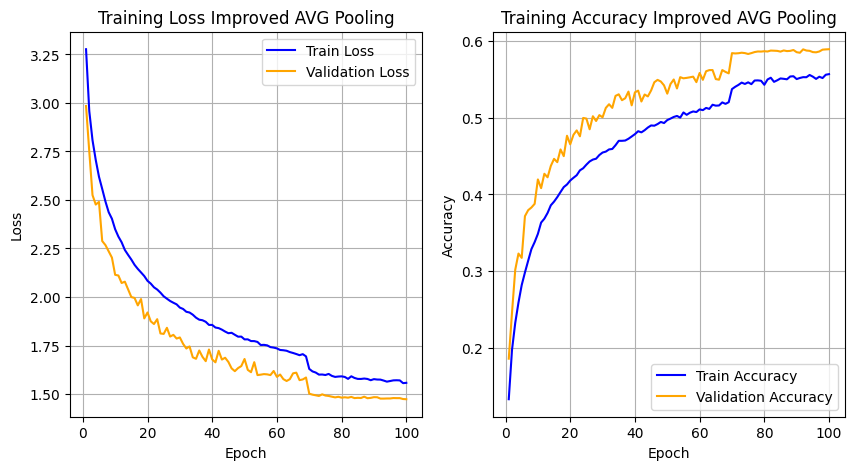


Per-class Accuracy:
Accuracy for class 'acoustic       ': 36.9%
Accuracy for class 'antenna        ': 54.4%
Accuracy for class 'bacteria       ': 56.3%
Accuracy for class 'battery        ': 53.0%
Accuracy for class 'bean           ': 54.4%
Accuracy for class 'beetle         ': 68.9%
Accuracy for class 'bicycle        ': 75.6%
Accuracy for class 'birch          ': 60.3%
Accuracy for class 'bird           ': 29.7%
Accuracy for class 'bomb           ': 54.8%
Accuracy for class 'bread          ': 42.6%
Accuracy for class 'bridge         ': 69.4%
Accuracy for class 'camera         ': 74.9%
Accuracy for class 'carbon         ': 40.2%
Accuracy for class 'cat            ': 66.9%
Accuracy for class 'corn           ': 46.2%
Accuracy for class 'crab           ': 41.5%
Accuracy for class 'crocodilian    ': 53.3%
Accuracy for class 'echinoderm     ': 36.8%
Accuracy for class 'egg            ': 48.6%
Accuracy for class 'elephant       ': 76.4%
Accuracy for class 'fish           ': 48.4%
Accuracy fo

Training Epoch [1/100]: 100%|██████████| 551/551 [01:00<00:00,  9.04it/s]


Training -> Loss: 3.1817 - Acc: 16.28%


Validating Epoch [1/100]: 100%|██████████| 138/138 [00:19<00:00,  7.19it/s]


Validation -> Loss: 2.6728 - Acc: 27.74%
New best ACC model found! Saved at epoch 1 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 1 to avg_best_model_loss.pth.


Training Epoch [2/100]: 100%|██████████| 551/551 [01:00<00:00,  9.17it/s]


Training -> Loss: 2.7728 - Acc: 25.23%


Validating Epoch [2/100]: 100%|██████████| 138/138 [00:19<00:00,  7.15it/s]


Validation -> Loss: 2.5650 - Acc: 30.37%
New best ACC model found! Saved at epoch 2 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 2 to avg_best_model_loss.pth.


Training Epoch [3/100]: 100%|██████████| 551/551 [01:04<00:00,  8.57it/s]


Training -> Loss: 2.5612 - Acc: 30.25%


Validating Epoch [3/100]: 100%|██████████| 138/138 [00:19<00:00,  6.93it/s]


Validation -> Loss: 2.2130 - Acc: 39.49%
New best ACC model found! Saved at epoch 3 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 3 to avg_best_model_loss.pth.


Training Epoch [4/100]: 100%|██████████| 551/551 [01:00<00:00,  9.11it/s]


Training -> Loss: 2.4152 - Acc: 33.86%


Validating Epoch [4/100]: 100%|██████████| 138/138 [00:18<00:00,  7.45it/s]


Validation -> Loss: 2.1264 - Acc: 41.22%
New best ACC model found! Saved at epoch 4 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 4 to avg_best_model_loss.pth.


Training Epoch [5/100]: 100%|██████████| 551/551 [00:59<00:00,  9.19it/s]


Training -> Loss: 2.3036 - Acc: 36.90%


Validating Epoch [5/100]: 100%|██████████| 138/138 [00:19<00:00,  7.00it/s]


Validation -> Loss: 2.0522 - Acc: 43.66%
New best ACC model found! Saved at epoch 5 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 5 to avg_best_model_loss.pth.


Training Epoch [6/100]: 100%|██████████| 551/551 [01:00<00:00,  9.05it/s]


Training -> Loss: 2.2229 - Acc: 38.89%


Validating Epoch [6/100]: 100%|██████████| 138/138 [00:19<00:00,  6.94it/s]


Validation -> Loss: 1.9321 - Acc: 46.90%
New best ACC model found! Saved at epoch 6 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 6 to avg_best_model_loss.pth.


Training Epoch [7/100]: 100%|██████████| 551/551 [00:59<00:00,  9.27it/s]


Training -> Loss: 2.1524 - Acc: 40.75%


Validating Epoch [7/100]: 100%|██████████| 138/138 [00:19<00:00,  6.95it/s]


Validation -> Loss: 1.8988 - Acc: 47.65%
New best ACC model found! Saved at epoch 7 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 7 to avg_best_model_loss.pth.


Training Epoch [8/100]: 100%|██████████| 551/551 [01:01<00:00,  9.02it/s]


Training -> Loss: 2.0856 - Acc: 42.63%


Validating Epoch [8/100]: 100%|██████████| 138/138 [00:18<00:00,  7.39it/s]


Validation -> Loss: 1.8180 - Acc: 49.93%
New best ACC model found! Saved at epoch 8 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 8 to avg_best_model_loss.pth.


Training Epoch [9/100]: 100%|██████████| 551/551 [00:59<00:00,  9.28it/s]


Training -> Loss: 2.0362 - Acc: 43.95%


Validating Epoch [9/100]: 100%|██████████| 138/138 [00:19<00:00,  7.03it/s]


Validation -> Loss: 1.8349 - Acc: 49.84%


Training Epoch [10/100]: 100%|██████████| 551/551 [01:00<00:00,  9.14it/s]


Training -> Loss: 1.9828 - Acc: 45.37%


Validating Epoch [10/100]: 100%|██████████| 138/138 [00:20<00:00,  6.87it/s]


Validation -> Loss: 1.7287 - Acc: 52.27%
New best ACC model found! Saved at epoch 10 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 10 to avg_best_model_loss.pth.


Training Epoch [11/100]: 100%|██████████| 551/551 [01:00<00:00,  9.14it/s]


Training -> Loss: 1.9336 - Acc: 46.69%


Validating Epoch [11/100]: 100%|██████████| 138/138 [00:19<00:00,  7.17it/s]


Validation -> Loss: 1.8724 - Acc: 49.18%


Training Epoch [12/100]: 100%|██████████| 551/551 [00:59<00:00,  9.22it/s]


Training -> Loss: 1.8831 - Acc: 47.84%


Validating Epoch [12/100]: 100%|██████████| 138/138 [00:19<00:00,  7.09it/s]


Validation -> Loss: 1.6960 - Acc: 53.60%
New best ACC model found! Saved at epoch 12 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 12 to avg_best_model_loss.pth.


Training Epoch [13/100]: 100%|██████████| 551/551 [01:00<00:00,  9.09it/s]


Training -> Loss: 1.8595 - Acc: 48.56%


Validating Epoch [13/100]: 100%|██████████| 138/138 [00:19<00:00,  7.07it/s]


Validation -> Loss: 1.6119 - Acc: 55.31%
New best ACC model found! Saved at epoch 13 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 13 to avg_best_model_loss.pth.


Training Epoch [14/100]: 100%|██████████| 551/551 [01:01<00:00,  8.89it/s]


Training -> Loss: 1.8095 - Acc: 49.87%


Validating Epoch [14/100]: 100%|██████████| 138/138 [00:22<00:00,  6.27it/s]


Validation -> Loss: 1.6301 - Acc: 54.96%


Training Epoch [15/100]: 100%|██████████| 551/551 [01:04<00:00,  8.54it/s]


Training -> Loss: 1.7746 - Acc: 50.75%


Validating Epoch [15/100]: 100%|██████████| 138/138 [00:18<00:00,  7.41it/s]


Validation -> Loss: 1.6009 - Acc: 55.55%
New best ACC model found! Saved at epoch 15 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 15 to avg_best_model_loss.pth.


Training Epoch [16/100]: 100%|██████████| 551/551 [01:02<00:00,  8.86it/s]


Training -> Loss: 1.7410 - Acc: 51.51%


Validating Epoch [16/100]: 100%|██████████| 138/138 [00:20<00:00,  6.84it/s]


Validation -> Loss: 1.5467 - Acc: 57.63%
New best ACC model found! Saved at epoch 16 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 16 to avg_best_model_loss.pth.


Training Epoch [17/100]: 100%|██████████| 551/551 [00:59<00:00,  9.24it/s]


Training -> Loss: 1.7126 - Acc: 52.30%


Validating Epoch [17/100]: 100%|██████████| 138/138 [00:19<00:00,  6.98it/s]


Validation -> Loss: 1.5404 - Acc: 57.10%
New best LOSS model found! Saved at epoch 17 to avg_best_model_loss.pth.


Training Epoch [18/100]: 100%|██████████| 551/551 [01:00<00:00,  9.04it/s]


Training -> Loss: 1.6842 - Acc: 52.85%


Validating Epoch [18/100]: 100%|██████████| 138/138 [00:19<00:00,  7.23it/s]


Validation -> Loss: 1.5820 - Acc: 56.21%


Training Epoch [19/100]: 100%|██████████| 551/551 [01:01<00:00,  9.01it/s]


Training -> Loss: 1.6533 - Acc: 53.78%


Validating Epoch [19/100]: 100%|██████████| 138/138 [00:20<00:00,  6.79it/s]


Validation -> Loss: 1.5082 - Acc: 58.14%
New best ACC model found! Saved at epoch 19 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 19 to avg_best_model_loss.pth.


Training Epoch [20/100]: 100%|██████████| 551/551 [00:59<00:00,  9.20it/s]


Training -> Loss: 1.6275 - Acc: 54.55%


Validating Epoch [20/100]: 100%|██████████| 138/138 [00:19<00:00,  7.13it/s]


Validation -> Loss: 1.5378 - Acc: 57.80%


Training Epoch [21/100]: 100%|██████████| 551/551 [01:00<00:00,  9.10it/s]


Training -> Loss: 1.6104 - Acc: 54.93%


Validating Epoch [21/100]: 100%|██████████| 138/138 [00:19<00:00,  7.18it/s]


Validation -> Loss: 1.5009 - Acc: 58.76%
New best ACC model found! Saved at epoch 21 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 21 to avg_best_model_loss.pth.


Training Epoch [22/100]: 100%|██████████| 551/551 [01:00<00:00,  9.08it/s]


Training -> Loss: 1.5820 - Acc: 55.82%


Validating Epoch [22/100]: 100%|██████████| 138/138 [00:19<00:00,  7.20it/s]


Validation -> Loss: 1.4628 - Acc: 59.63%
New best ACC model found! Saved at epoch 22 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 22 to avg_best_model_loss.pth.


Training Epoch [23/100]: 100%|██████████| 551/551 [01:02<00:00,  8.75it/s]


Training -> Loss: 1.5578 - Acc: 56.22%


Validating Epoch [23/100]: 100%|██████████| 138/138 [00:19<00:00,  6.97it/s]


Validation -> Loss: 1.4219 - Acc: 60.67%
New best ACC model found! Saved at epoch 23 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 23 to avg_best_model_loss.pth.


Training Epoch [24/100]: 100%|██████████| 551/551 [01:00<00:00,  9.10it/s]


Training -> Loss: 1.5362 - Acc: 56.74%


Validating Epoch [24/100]: 100%|██████████| 138/138 [00:19<00:00,  7.00it/s]


Validation -> Loss: 1.4444 - Acc: 60.39%


Training Epoch [25/100]: 100%|██████████| 551/551 [00:59<00:00,  9.19it/s]


Training -> Loss: 1.5166 - Acc: 57.49%


Validating Epoch [25/100]: 100%|██████████| 138/138 [00:19<00:00,  7.19it/s]


Validation -> Loss: 1.4381 - Acc: 60.65%


Training Epoch [26/100]: 100%|██████████| 551/551 [00:59<00:00,  9.31it/s]


Training -> Loss: 1.4929 - Acc: 57.91%


Validating Epoch [26/100]: 100%|██████████| 138/138 [00:19<00:00,  7.10it/s]


Validation -> Loss: 1.4111 - Acc: 61.12%
New best ACC model found! Saved at epoch 26 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 26 to avg_best_model_loss.pth.


Training Epoch [27/100]: 100%|██████████| 551/551 [00:59<00:00,  9.25it/s]


Training -> Loss: 1.4744 - Acc: 58.26%


Validating Epoch [27/100]: 100%|██████████| 138/138 [00:19<00:00,  6.96it/s]


Validation -> Loss: 1.4192 - Acc: 61.32%
New best ACC model found! Saved at epoch 27 to avg_best_model_acc.pth.


Training Epoch [28/100]: 100%|██████████| 551/551 [00:59<00:00,  9.30it/s]


Training -> Loss: 1.4516 - Acc: 58.96%


Validating Epoch [28/100]: 100%|██████████| 138/138 [00:18<00:00,  7.30it/s]


Validation -> Loss: 1.3853 - Acc: 62.10%
New best ACC model found! Saved at epoch 28 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 28 to avg_best_model_loss.pth.


Training Epoch [29/100]: 100%|██████████| 551/551 [00:59<00:00,  9.24it/s]


Training -> Loss: 1.4341 - Acc: 59.37%


Validating Epoch [29/100]: 100%|██████████| 138/138 [00:19<00:00,  6.95it/s]


Validation -> Loss: 1.3954 - Acc: 61.35%


Training Epoch [30/100]: 100%|██████████| 551/551 [01:02<00:00,  8.86it/s]


Training -> Loss: 1.4179 - Acc: 59.90%


Validating Epoch [30/100]: 100%|██████████| 138/138 [00:19<00:00,  6.90it/s]


Validation -> Loss: 1.3508 - Acc: 62.81%
New best ACC model found! Saved at epoch 30 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 30 to avg_best_model_loss.pth.


Training Epoch [31/100]: 100%|██████████| 551/551 [01:01<00:00,  8.96it/s]


Training -> Loss: 1.4137 - Acc: 59.99%


Validating Epoch [31/100]: 100%|██████████| 138/138 [00:20<00:00,  6.83it/s]


Validation -> Loss: 1.3591 - Acc: 62.89%
New best ACC model found! Saved at epoch 31 to avg_best_model_acc.pth.


Training Epoch [32/100]: 100%|██████████| 551/551 [01:00<00:00,  9.04it/s]


Training -> Loss: 1.3838 - Acc: 60.62%


Validating Epoch [32/100]: 100%|██████████| 138/138 [00:18<00:00,  7.33it/s]


Validation -> Loss: 1.3907 - Acc: 62.19%


Training Epoch [33/100]: 100%|██████████| 551/551 [01:01<00:00,  9.01it/s]


Training -> Loss: 1.3788 - Acc: 60.97%


Validating Epoch [33/100]: 100%|██████████| 138/138 [00:18<00:00,  7.30it/s]


Validation -> Loss: 1.3324 - Acc: 63.46%
New best ACC model found! Saved at epoch 33 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 33 to avg_best_model_loss.pth.


Training Epoch [34/100]: 100%|██████████| 551/551 [01:00<00:00,  9.16it/s]


Training -> Loss: 1.3615 - Acc: 61.30%


Validating Epoch [34/100]: 100%|██████████| 138/138 [00:19<00:00,  6.94it/s]


Validation -> Loss: 1.3119 - Acc: 64.02%
New best ACC model found! Saved at epoch 34 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 34 to avg_best_model_loss.pth.


Training Epoch [35/100]: 100%|██████████| 551/551 [01:03<00:00,  8.72it/s]


Training -> Loss: 1.3521 - Acc: 61.50%


Validating Epoch [35/100]: 100%|██████████| 138/138 [00:19<00:00,  6.96it/s]


Validation -> Loss: 1.3213 - Acc: 64.14%
New best ACC model found! Saved at epoch 35 to avg_best_model_acc.pth.


Training Epoch [36/100]: 100%|██████████| 551/551 [01:00<00:00,  9.06it/s]


Training -> Loss: 1.3280 - Acc: 62.13%


Validating Epoch [36/100]: 100%|██████████| 138/138 [00:19<00:00,  7.07it/s]


Validation -> Loss: 1.3293 - Acc: 63.66%


Training Epoch [37/100]: 100%|██████████| 551/551 [01:00<00:00,  9.18it/s]


Training -> Loss: 1.3261 - Acc: 62.33%


Validating Epoch [37/100]: 100%|██████████| 138/138 [00:19<00:00,  7.04it/s]


Validation -> Loss: 1.3104 - Acc: 64.13%
New best LOSS model found! Saved at epoch 37 to avg_best_model_loss.pth.


Training Epoch [38/100]: 100%|██████████| 551/551 [01:00<00:00,  9.13it/s]


Training -> Loss: 1.3192 - Acc: 62.49%


Validating Epoch [38/100]: 100%|██████████| 138/138 [00:19<00:00,  7.13it/s]


Validation -> Loss: 1.3074 - Acc: 63.99%
New best LOSS model found! Saved at epoch 38 to avg_best_model_loss.pth.


Training Epoch [39/100]: 100%|██████████| 551/551 [01:00<00:00,  9.09it/s]


Training -> Loss: 1.2910 - Acc: 63.25%


Validating Epoch [39/100]: 100%|██████████| 138/138 [00:19<00:00,  7.07it/s]


Validation -> Loss: 1.3140 - Acc: 63.95%


Training Epoch [40/100]: 100%|██████████| 551/551 [00:59<00:00,  9.33it/s]


Training -> Loss: 1.2922 - Acc: 63.17%


Validating Epoch [40/100]: 100%|██████████| 138/138 [00:19<00:00,  7.01it/s]


Validation -> Loss: 1.3188 - Acc: 64.07%


Training Epoch [41/100]: 100%|██████████| 551/551 [01:00<00:00,  9.04it/s]


Training -> Loss: 1.2783 - Acc: 63.53%


Validating Epoch [41/100]: 100%|██████████| 138/138 [00:19<00:00,  6.92it/s]


Validation -> Loss: 1.3349 - Acc: 63.72%


Training Epoch [42/100]: 100%|██████████| 551/551 [01:01<00:00,  9.02it/s]


Training -> Loss: 1.2679 - Acc: 63.74%


Validating Epoch [42/100]: 100%|██████████| 138/138 [00:19<00:00,  7.25it/s]


Validation -> Loss: 1.2973 - Acc: 64.95%
New best ACC model found! Saved at epoch 42 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 42 to avg_best_model_loss.pth.


Training Epoch [43/100]: 100%|██████████| 551/551 [01:00<00:00,  9.04it/s]


Training -> Loss: 1.2609 - Acc: 63.90%


Validating Epoch [43/100]: 100%|██████████| 138/138 [00:20<00:00,  6.88it/s]


Validation -> Loss: 1.2757 - Acc: 65.33%
New best ACC model found! Saved at epoch 43 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 43 to avg_best_model_loss.pth.


Training Epoch [44/100]: 100%|██████████| 551/551 [01:02<00:00,  8.87it/s]


Training -> Loss: 1.2453 - Acc: 64.34%


Validating Epoch [44/100]: 100%|██████████| 138/138 [00:20<00:00,  6.81it/s]


Validation -> Loss: 1.2942 - Acc: 64.91%


Training Epoch [45/100]: 100%|██████████| 551/551 [01:01<00:00,  8.97it/s]


Training -> Loss: 1.2398 - Acc: 64.38%


Validating Epoch [45/100]: 100%|██████████| 138/138 [00:19<00:00,  7.10it/s]


Validation -> Loss: 1.3003 - Acc: 64.65%


Training Epoch [46/100]: 100%|██████████| 551/551 [00:59<00:00,  9.25it/s]


Training -> Loss: 1.2249 - Acc: 64.66%


Validating Epoch [46/100]: 100%|██████████| 138/138 [00:19<00:00,  7.15it/s]


Validation -> Loss: 1.2889 - Acc: 64.71%


Training Epoch [47/100]: 100%|██████████| 551/551 [00:59<00:00,  9.21it/s]


Training -> Loss: 1.2238 - Acc: 64.83%


Validating Epoch [47/100]: 100%|██████████| 138/138 [00:19<00:00,  6.99it/s]


Validation -> Loss: 1.2796 - Acc: 65.29%


Training Epoch [48/100]: 100%|██████████| 551/551 [01:00<00:00,  9.12it/s]


Training -> Loss: 1.2119 - Acc: 65.12%


Validating Epoch [48/100]: 100%|██████████| 138/138 [00:19<00:00,  6.99it/s]


Validation -> Loss: 1.2770 - Acc: 65.10%


Training Epoch [49/100]: 100%|██████████| 551/551 [01:00<00:00,  9.06it/s]


Training -> Loss: 1.1950 - Acc: 65.49%


Validating Epoch [49/100]: 100%|██████████| 138/138 [00:19<00:00,  7.25it/s]


Validation -> Loss: 1.3165 - Acc: 64.04%


Training Epoch [50/100]: 100%|██████████| 551/551 [01:00<00:00,  9.07it/s]


Training -> Loss: 1.1174 - Acc: 67.58%


Validating Epoch [50/100]: 100%|██████████| 138/138 [00:19<00:00,  7.00it/s]


Validation -> Loss: 1.2037 - Acc: 67.07%
New best ACC model found! Saved at epoch 50 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 50 to avg_best_model_loss.pth.


Training Epoch [51/100]: 100%|██████████| 551/551 [01:02<00:00,  8.86it/s]


Training -> Loss: 1.0934 - Acc: 68.44%


Validating Epoch [51/100]: 100%|██████████| 138/138 [00:20<00:00,  6.84it/s]


Validation -> Loss: 1.2039 - Acc: 67.28%
New best ACC model found! Saved at epoch 51 to avg_best_model_acc.pth.


Training Epoch [52/100]: 100%|██████████| 551/551 [01:01<00:00,  8.99it/s]


Training -> Loss: 1.0771 - Acc: 68.61%


Validating Epoch [52/100]: 100%|██████████| 138/138 [00:19<00:00,  7.10it/s]


Validation -> Loss: 1.2045 - Acc: 67.26%


Training Epoch [53/100]: 100%|██████████| 551/551 [00:59<00:00,  9.20it/s]


Training -> Loss: 1.0688 - Acc: 68.94%


Validating Epoch [53/100]: 100%|██████████| 138/138 [00:19<00:00,  7.23it/s]


Validation -> Loss: 1.1952 - Acc: 67.70%
New best ACC model found! Saved at epoch 53 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 53 to avg_best_model_loss.pth.


Training Epoch [54/100]: 100%|██████████| 551/551 [01:00<00:00,  9.03it/s]


Training -> Loss: 1.0690 - Acc: 68.97%


Validating Epoch [54/100]: 100%|██████████| 138/138 [00:21<00:00,  6.53it/s]


Validation -> Loss: 1.1944 - Acc: 67.66%
New best LOSS model found! Saved at epoch 54 to avg_best_model_loss.pth.


Training Epoch [55/100]: 100%|██████████| 551/551 [01:02<00:00,  8.78it/s]


Training -> Loss: 1.0547 - Acc: 69.30%


Validating Epoch [55/100]: 100%|██████████| 138/138 [00:19<00:00,  7.08it/s]


Validation -> Loss: 1.1939 - Acc: 67.72%
New best ACC model found! Saved at epoch 55 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 55 to avg_best_model_loss.pth.


Training Epoch [56/100]: 100%|██████████| 551/551 [01:00<00:00,  9.10it/s]


Training -> Loss: 1.0556 - Acc: 69.27%


Validating Epoch [56/100]: 100%|██████████| 138/138 [00:21<00:00,  6.35it/s]


Validation -> Loss: 1.1901 - Acc: 67.91%
New best ACC model found! Saved at epoch 56 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 56 to avg_best_model_loss.pth.


Training Epoch [57/100]: 100%|██████████| 551/551 [00:59<00:00,  9.31it/s]


Training -> Loss: 1.0421 - Acc: 69.58%


Validating Epoch [57/100]: 100%|██████████| 138/138 [00:19<00:00,  7.21it/s]


Validation -> Loss: 1.1876 - Acc: 67.99%
New best ACC model found! Saved at epoch 57 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 57 to avg_best_model_loss.pth.


Training Epoch [58/100]: 100%|██████████| 551/551 [01:00<00:00,  9.17it/s]


Training -> Loss: 1.0462 - Acc: 69.37%


Validating Epoch [58/100]: 100%|██████████| 138/138 [00:19<00:00,  7.07it/s]


Validation -> Loss: 1.1894 - Acc: 67.72%


Training Epoch [59/100]: 100%|██████████| 551/551 [01:01<00:00,  9.01it/s]


Training -> Loss: 1.0356 - Acc: 69.87%


Validating Epoch [59/100]: 100%|██████████| 138/138 [00:19<00:00,  6.93it/s]


Validation -> Loss: 1.1844 - Acc: 67.81%
New best LOSS model found! Saved at epoch 59 to avg_best_model_loss.pth.


Training Epoch [60/100]: 100%|██████████| 551/551 [01:00<00:00,  9.16it/s]


Training -> Loss: 1.0353 - Acc: 69.94%


Validating Epoch [60/100]: 100%|██████████| 138/138 [00:18<00:00,  7.31it/s]


Validation -> Loss: 1.1823 - Acc: 68.18%
New best ACC model found! Saved at epoch 60 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 60 to avg_best_model_loss.pth.


Training Epoch [61/100]: 100%|██████████| 551/551 [01:01<00:00,  8.97it/s]


Training -> Loss: 1.0289 - Acc: 70.06%


Validating Epoch [61/100]: 100%|██████████| 138/138 [00:19<00:00,  6.96it/s]


Validation -> Loss: 1.1861 - Acc: 68.00%


Training Epoch [62/100]: 100%|██████████| 551/551 [00:59<00:00,  9.20it/s]


Training -> Loss: 1.0270 - Acc: 69.97%


Validating Epoch [62/100]: 100%|██████████| 138/138 [00:19<00:00,  7.13it/s]


Validation -> Loss: 1.1830 - Acc: 68.15%


Training Epoch [63/100]: 100%|██████████| 551/551 [00:59<00:00,  9.19it/s]


Training -> Loss: 1.0212 - Acc: 70.10%


Validating Epoch [63/100]: 100%|██████████| 138/138 [00:19<00:00,  7.20it/s]


Validation -> Loss: 1.1871 - Acc: 68.04%


Training Epoch [64/100]: 100%|██████████| 551/551 [00:59<00:00,  9.29it/s]


Training -> Loss: 1.0283 - Acc: 70.07%


Validating Epoch [64/100]: 100%|██████████| 138/138 [00:19<00:00,  7.13it/s]


Validation -> Loss: 1.1840 - Acc: 68.33%
New best ACC model found! Saved at epoch 64 to avg_best_model_acc.pth.


Training Epoch [65/100]: 100%|██████████| 551/551 [01:01<00:00,  8.99it/s]


Training -> Loss: 1.0215 - Acc: 70.30%


Validating Epoch [65/100]: 100%|██████████| 138/138 [00:21<00:00,  6.55it/s]


Validation -> Loss: 1.1808 - Acc: 68.39%
New best ACC model found! Saved at epoch 65 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 65 to avg_best_model_loss.pth.


Training Epoch [66/100]: 100%|██████████| 551/551 [01:01<00:00,  8.95it/s]


Training -> Loss: 1.0213 - Acc: 70.22%


Validating Epoch [66/100]: 100%|██████████| 138/138 [00:19<00:00,  7.25it/s]


Validation -> Loss: 1.1812 - Acc: 68.31%


Training Epoch [67/100]: 100%|██████████| 551/551 [01:00<00:00,  9.10it/s]


Training -> Loss: 1.0154 - Acc: 70.25%


Validating Epoch [67/100]: 100%|██████████| 138/138 [00:19<00:00,  7.17it/s]


Validation -> Loss: 1.1833 - Acc: 68.25%


Training Epoch [68/100]: 100%|██████████| 551/551 [01:00<00:00,  9.15it/s]


Training -> Loss: 1.0110 - Acc: 70.38%


Validating Epoch [68/100]: 100%|██████████| 138/138 [00:19<00:00,  7.12it/s]


Validation -> Loss: 1.1831 - Acc: 68.08%


Training Epoch [69/100]: 100%|██████████| 551/551 [01:00<00:00,  9.13it/s]


Training -> Loss: 1.0074 - Acc: 70.68%


Validating Epoch [69/100]: 100%|██████████| 138/138 [00:19<00:00,  6.92it/s]


Validation -> Loss: 1.1889 - Acc: 67.97%


Training Epoch [70/100]: 100%|██████████| 551/551 [01:05<00:00,  8.47it/s]


Training -> Loss: 1.0005 - Acc: 70.56%


Validating Epoch [70/100]: 100%|██████████| 138/138 [00:29<00:00,  4.69it/s]


Validation -> Loss: 1.1847 - Acc: 68.04%


Training Epoch [71/100]: 100%|██████████| 551/551 [01:02<00:00,  8.82it/s]


Training -> Loss: 1.0018 - Acc: 70.73%


Validating Epoch [71/100]: 100%|██████████| 138/138 [00:19<00:00,  7.25it/s]


Validation -> Loss: 1.1767 - Acc: 68.35%
New best LOSS model found! Saved at epoch 71 to avg_best_model_loss.pth.


Training Epoch [72/100]: 100%|██████████| 551/551 [01:00<00:00,  9.08it/s]


Training -> Loss: 1.0017 - Acc: 70.77%


Validating Epoch [72/100]: 100%|██████████| 138/138 [00:19<00:00,  7.10it/s]


Validation -> Loss: 1.1813 - Acc: 68.30%


Training Epoch [73/100]: 100%|██████████| 551/551 [01:00<00:00,  9.17it/s]


Training -> Loss: 1.0057 - Acc: 70.65%


Validating Epoch [73/100]: 100%|██████████| 138/138 [00:19<00:00,  7.01it/s]


Validation -> Loss: 1.1789 - Acc: 68.31%


Training Epoch [74/100]: 100%|██████████| 551/551 [01:00<00:00,  9.12it/s]


Training -> Loss: 1.0050 - Acc: 70.73%


Validating Epoch [74/100]: 100%|██████████| 138/138 [00:19<00:00,  7.15it/s]


Validation -> Loss: 1.1764 - Acc: 68.44%
New best ACC model found! Saved at epoch 74 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 74 to avg_best_model_loss.pth.


Training Epoch [75/100]: 100%|██████████| 551/551 [01:00<00:00,  9.10it/s]


Training -> Loss: 0.9961 - Acc: 71.02%


Validating Epoch [75/100]: 100%|██████████| 138/138 [00:19<00:00,  7.25it/s]


Validation -> Loss: 1.1857 - Acc: 68.14%


Training Epoch [76/100]: 100%|██████████| 551/551 [01:01<00:00,  9.03it/s]


Training -> Loss: 0.9950 - Acc: 70.86%


Validating Epoch [76/100]: 100%|██████████| 138/138 [00:19<00:00,  7.15it/s]


Validation -> Loss: 1.1756 - Acc: 68.24%
New best LOSS model found! Saved at epoch 76 to avg_best_model_loss.pth.


Training Epoch [77/100]: 100%|██████████| 551/551 [01:00<00:00,  9.11it/s]


Training -> Loss: 0.9854 - Acc: 71.13%


Validating Epoch [77/100]: 100%|██████████| 138/138 [00:20<00:00,  6.77it/s]


Validation -> Loss: 1.1798 - Acc: 68.26%


Training Epoch [78/100]: 100%|██████████| 551/551 [01:00<00:00,  9.06it/s]


Training -> Loss: 0.9778 - Acc: 71.30%


Validating Epoch [78/100]: 100%|██████████| 138/138 [00:19<00:00,  7.09it/s]


Validation -> Loss: 1.1767 - Acc: 68.39%


Training Epoch [79/100]: 100%|██████████| 551/551 [01:00<00:00,  9.05it/s]


Training -> Loss: 0.9863 - Acc: 70.99%


Validating Epoch [79/100]: 100%|██████████| 138/138 [00:19<00:00,  7.06it/s]


Validation -> Loss: 1.1810 - Acc: 68.24%


Training Epoch [80/100]: 100%|██████████| 551/551 [01:00<00:00,  9.17it/s]


Training -> Loss: 0.9772 - Acc: 71.40%


Validating Epoch [80/100]: 100%|██████████| 138/138 [00:19<00:00,  6.97it/s]


Validation -> Loss: 1.1724 - Acc: 68.56%
New best ACC model found! Saved at epoch 80 to avg_best_model_acc.pth.
New best LOSS model found! Saved at epoch 80 to avg_best_model_loss.pth.


Training Epoch [81/100]: 100%|██████████| 551/551 [01:00<00:00,  9.12it/s]


Training -> Loss: 0.9816 - Acc: 71.33%


Validating Epoch [81/100]: 100%|██████████| 138/138 [00:19<00:00,  7.17it/s]


Validation -> Loss: 1.1745 - Acc: 68.37%


Training Epoch [82/100]: 100%|██████████| 551/551 [01:01<00:00,  8.90it/s]


Training -> Loss: 0.9838 - Acc: 71.26%


Validating Epoch [82/100]: 100%|██████████| 138/138 [00:21<00:00,  6.34it/s]


Validation -> Loss: 1.1755 - Acc: 68.55%


Training Epoch [83/100]: 100%|██████████| 551/551 [01:01<00:00,  8.99it/s]


Training -> Loss: 0.9868 - Acc: 71.00%


Validating Epoch [83/100]: 100%|██████████| 138/138 [00:20<00:00,  6.68it/s]


Validation -> Loss: 1.1781 - Acc: 68.37%


Training Epoch [84/100]: 100%|██████████| 551/551 [01:02<00:00,  8.89it/s]


Training -> Loss: 0.9732 - Acc: 71.47%


Validating Epoch [84/100]: 100%|██████████| 138/138 [00:20<00:00,  6.87it/s]


Validation -> Loss: 1.1794 - Acc: 68.24%


Training Epoch [85/100]: 100%|██████████| 551/551 [01:01<00:00,  8.99it/s]


Training -> Loss: 0.9791 - Acc: 71.33%


Validating Epoch [85/100]: 100%|██████████| 138/138 [00:19<00:00,  7.17it/s]


Validation -> Loss: 1.1823 - Acc: 68.31%


Training Epoch [86/100]: 100%|██████████| 551/551 [01:00<00:00,  9.13it/s]


Training -> Loss: 0.9752 - Acc: 71.39%


Validating Epoch [86/100]: 100%|██████████| 138/138 [00:18<00:00,  7.26it/s]


Validation -> Loss: 1.1703 - Acc: 68.41%
New best LOSS model found! Saved at epoch 86 to avg_best_model_loss.pth.


Training Epoch [87/100]: 100%|██████████| 551/551 [01:00<00:00,  9.12it/s]


Training -> Loss: 0.9770 - Acc: 71.42%


Validating Epoch [87/100]: 100%|██████████| 138/138 [00:19<00:00,  7.04it/s]


Validation -> Loss: 1.1751 - Acc: 68.41%


Training Epoch [88/100]: 100%|██████████| 551/551 [01:00<00:00,  9.13it/s]


Training -> Loss: 0.9708 - Acc: 71.32%


Validating Epoch [88/100]: 100%|██████████| 138/138 [00:19<00:00,  6.97it/s]


Validation -> Loss: 1.1720 - Acc: 68.51%


Training Epoch [89/100]: 100%|██████████| 551/551 [01:00<00:00,  9.07it/s]


Training -> Loss: 0.9722 - Acc: 71.58%


Validating Epoch [89/100]: 100%|██████████| 138/138 [00:19<00:00,  7.16it/s]


Validation -> Loss: 1.1744 - Acc: 68.49%


Training Epoch [90/100]: 100%|██████████| 551/551 [00:59<00:00,  9.22it/s]


Training -> Loss: 0.9710 - Acc: 71.67%


Validating Epoch [90/100]: 100%|██████████| 138/138 [00:19<00:00,  6.95it/s]


Validation -> Loss: 1.1802 - Acc: 68.64%
New best ACC model found! Saved at epoch 90 to avg_best_model_acc.pth.


Training Epoch [91/100]: 100%|██████████| 551/551 [00:59<00:00,  9.24it/s]


Training -> Loss: 0.9682 - Acc: 71.72%


Validating Epoch [91/100]: 100%|██████████| 138/138 [00:19<00:00,  7.00it/s]


Validation -> Loss: 1.1769 - Acc: 68.55%


Training Epoch [92/100]: 100%|██████████| 551/551 [01:01<00:00,  8.89it/s]


Training -> Loss: 0.9602 - Acc: 71.79%


Validating Epoch [92/100]: 100%|██████████| 138/138 [00:19<00:00,  7.17it/s]


Validation -> Loss: 1.1761 - Acc: 68.45%


Training Epoch [93/100]: 100%|██████████| 551/551 [01:00<00:00,  9.12it/s]


Training -> Loss: 0.9573 - Acc: 71.90%


Validating Epoch [93/100]: 100%|██████████| 138/138 [00:19<00:00,  7.23it/s]


Validation -> Loss: 1.1728 - Acc: 68.72%
New best ACC model found! Saved at epoch 93 to avg_best_model_acc.pth.


Training Epoch [94/100]: 100%|██████████| 551/551 [01:00<00:00,  9.04it/s]


Training -> Loss: 0.9552 - Acc: 72.02%


Validating Epoch [94/100]: 100%|██████████| 138/138 [00:18<00:00,  7.39it/s]


Validation -> Loss: 1.1703 - Acc: 68.48%
New best LOSS model found! Saved at epoch 94 to avg_best_model_loss.pth.


Training Epoch [95/100]: 100%|██████████| 551/551 [01:04<00:00,  8.52it/s]


Training -> Loss: 0.9597 - Acc: 71.88%


Validating Epoch [95/100]: 100%|██████████| 138/138 [00:19<00:00,  6.93it/s]


Validation -> Loss: 1.1702 - Acc: 68.64%
New best LOSS model found! Saved at epoch 95 to avg_best_model_loss.pth.


Training Epoch [96/100]: 100%|██████████| 551/551 [01:03<00:00,  8.62it/s]


Training -> Loss: 0.9544 - Acc: 72.04%


Validating Epoch [96/100]: 100%|██████████| 138/138 [00:20<00:00,  6.83it/s]


Validation -> Loss: 1.1726 - Acc: 68.61%


Training Epoch [97/100]: 100%|██████████| 551/551 [01:00<00:00,  9.08it/s]


Training -> Loss: 0.9497 - Acc: 72.17%


Validating Epoch [97/100]: 100%|██████████| 138/138 [00:19<00:00,  7.05it/s]


Validation -> Loss: 1.1691 - Acc: 68.64%
New best LOSS model found! Saved at epoch 97 to avg_best_model_loss.pth.


Training Epoch [98/100]: 100%|██████████| 551/551 [01:00<00:00,  9.04it/s]


Training -> Loss: 0.9581 - Acc: 71.94%


Validating Epoch [98/100]: 100%|██████████| 138/138 [00:19<00:00,  7.17it/s]


Validation -> Loss: 1.1739 - Acc: 68.58%


Training Epoch [99/100]: 100%|██████████| 551/551 [01:02<00:00,  8.82it/s]


Training -> Loss: 0.9490 - Acc: 72.05%


Validating Epoch [99/100]: 100%|██████████| 138/138 [00:18<00:00,  7.30it/s]


Validation -> Loss: 1.1743 - Acc: 68.66%


Training Epoch [100/100]: 100%|██████████| 551/551 [01:02<00:00,  8.76it/s]


Training -> Loss: 0.9464 - Acc: 72.23%


Validating Epoch [100/100]: 100%|██████████| 138/138 [00:19<00:00,  7.15it/s]


Validation -> Loss: 1.1699 - Acc: 68.69%
Finished Training
Best ACC model saved to avg_best_model_acc.pth
Best LOSS model saved to avg_best_model_loss.pth


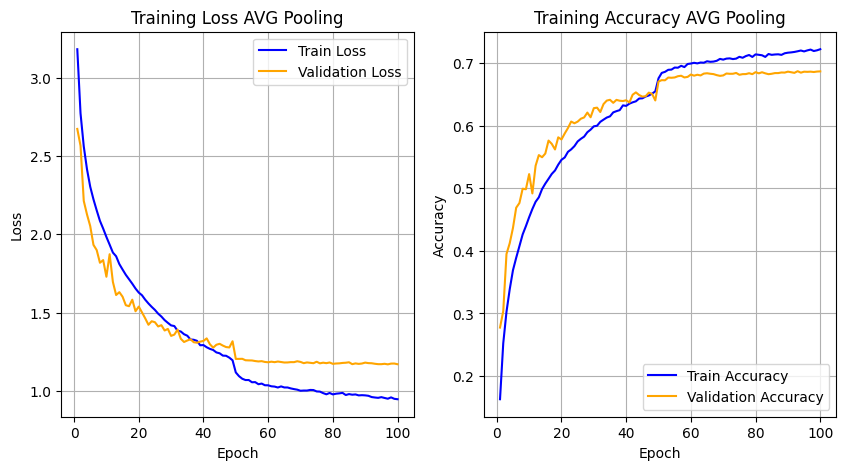


Per-class Accuracy:
Accuracy for class 'acoustic       ': 56.6%
Accuracy for class 'antenna        ': 64.0%
Accuracy for class 'bacteria       ': 71.8%
Accuracy for class 'battery        ': 65.2%
Accuracy for class 'bean           ': 61.9%
Accuracy for class 'beetle         ': 77.9%
Accuracy for class 'bicycle        ': 83.2%
Accuracy for class 'birch          ': 70.7%
Accuracy for class 'bird           ': 51.0%
Accuracy for class 'bomb           ': 69.7%
Accuracy for class 'bread          ': 53.7%
Accuracy for class 'bridge         ': 76.7%
Accuracy for class 'camera         ': 79.6%
Accuracy for class 'carbon         ': 54.9%
Accuracy for class 'cat            ': 71.5%
Accuracy for class 'corn           ': 51.4%
Accuracy for class 'crab           ': 53.8%
Accuracy for class 'crocodilian    ': 62.7%
Accuracy for class 'echinoderm     ': 60.9%
Accuracy for class 'egg            ': 59.3%
Accuracy for class 'elephant       ': 78.9%
Accuracy for class 'fish           ': 62.1%
Accuracy fo

In [61]:
EPOCHS = 100

print("Training Improved AVG Pooling model")

iavg_model = ImprovedAVGPoolNet().to(device)
criterion = nn.CrossEntropyLoss()
iavg_optimizer = torch.optim.AdamW(iavg_model.parameters(), lr=0.001, weight_decay=1e-4)
iavg_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(iavg_optimizer, mode='min', factor=0.1, patience=5)
iavg_model, iavg_train_loss, iavg_train_acc, iavg_val_loss, iavg_val_acc = train_and_save_model(
    model=iavg_model,
    train_loader=ag_trainloader,
    criterion=criterion,
    optimizer=iavg_optimizer,
    device=device,
    epochs=EPOCHS,
    validation_loader=ag_valloader,
    save_path_acc="iavg_best_model_acc.pth",
    save_path_loss="iavg_best_model_loss.pth",
    scheduler=iavg_scheduler
)

training_plot(
    epochs=EPOCHS,
    train_loss=iavg_train_loss,
    train_acc=iavg_train_acc,
    val_loss=iavg_val_loss,
    val_acc=iavg_val_acc,
    title=" Improved AVG Pooling"
)

y_true, y_pred = evaluate(iavg_model, ag_valloader, classes=class_names, device=device)


print("Training AVG Pooling model")

avg_model = AVGPoolNet().to(device)
avg_optimizer = torch.optim.AdamW(avg_model.parameters(), lr=0.001, weight_decay=1e-4)
avg_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(avg_optimizer, mode='min', factor=0.1, patience=5)
avg_model, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc = train_and_save_model(
    model=avg_model,
    train_loader=ag_trainloader,
    criterion=criterion,
    optimizer=avg_optimizer,
    device=device,
    epochs=EPOCHS,
    validation_loader=ag_valloader,
    save_path_acc="avg_best_model_acc.pth",
    save_path_loss="avg_best_model_loss.pth",
    scheduler=avg_scheduler
)

training_plot(
    epochs=EPOCHS,
    train_loss=avg_train_loss,
    train_acc=avg_train_acc,
    val_loss=avg_val_loss,
    val_acc=avg_val_acc,
    title=" AVG Pooling"
)
y_true, y_pred = evaluate(avg_model, ag_valloader, classes=class_names, device=device)

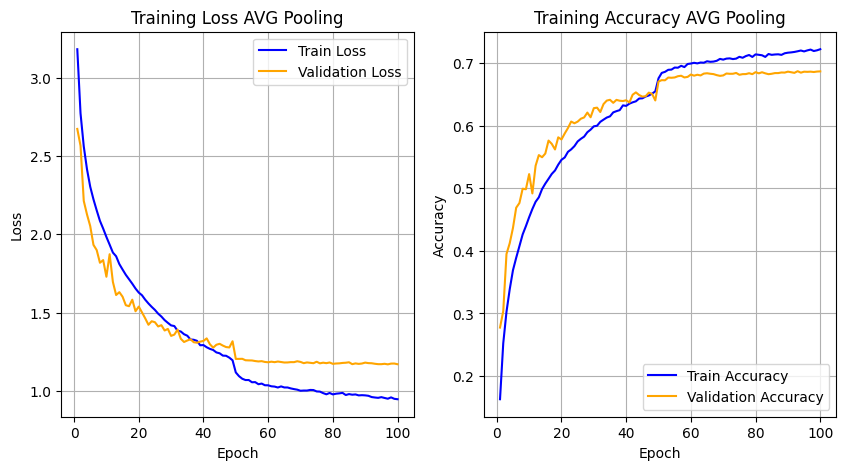


Per-class Accuracy:
Accuracy for class 'acoustic       ': 56.6%
Accuracy for class 'antenna        ': 64.0%
Accuracy for class 'bacteria       ': 71.8%
Accuracy for class 'battery        ': 65.2%
Accuracy for class 'bean           ': 61.9%
Accuracy for class 'beetle         ': 77.9%
Accuracy for class 'bicycle        ': 83.2%
Accuracy for class 'birch          ': 70.7%
Accuracy for class 'bird           ': 51.0%
Accuracy for class 'bomb           ': 69.7%
Accuracy for class 'bread          ': 53.7%
Accuracy for class 'bridge         ': 76.7%
Accuracy for class 'camera         ': 79.6%
Accuracy for class 'carbon         ': 54.9%
Accuracy for class 'cat            ': 71.5%
Accuracy for class 'corn           ': 51.4%
Accuracy for class 'crab           ': 53.8%
Accuracy for class 'crocodilian    ': 62.7%
Accuracy for class 'echinoderm     ': 60.9%
Accuracy for class 'egg            ': 59.3%
Accuracy for class 'elephant       ': 78.9%
Accuracy for class 'fish           ': 62.1%
Accuracy fo

In [62]:
training_plot(
    epochs=EPOCHS,
    train_loss=avg_train_loss,
    train_acc=avg_train_acc,
    val_loss=avg_val_loss,
    val_acc=avg_val_acc,
    title=" AVG Pooling"
)
y_true, y_pred = evaluate(avg_model, ag_valloader, classes=class_names, device=device)

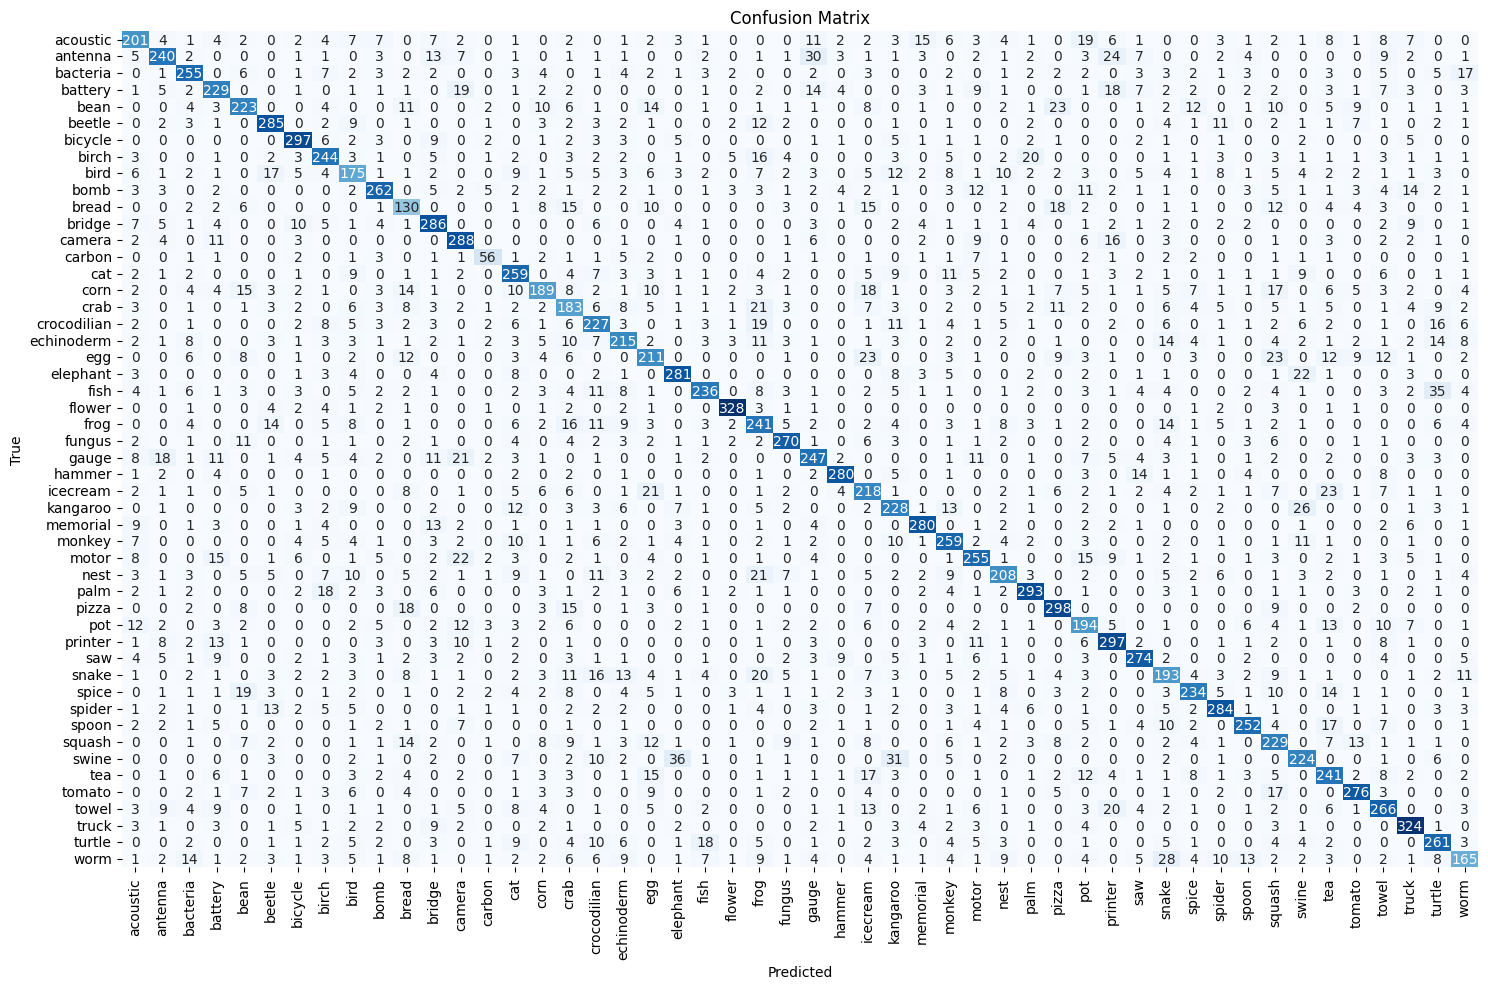

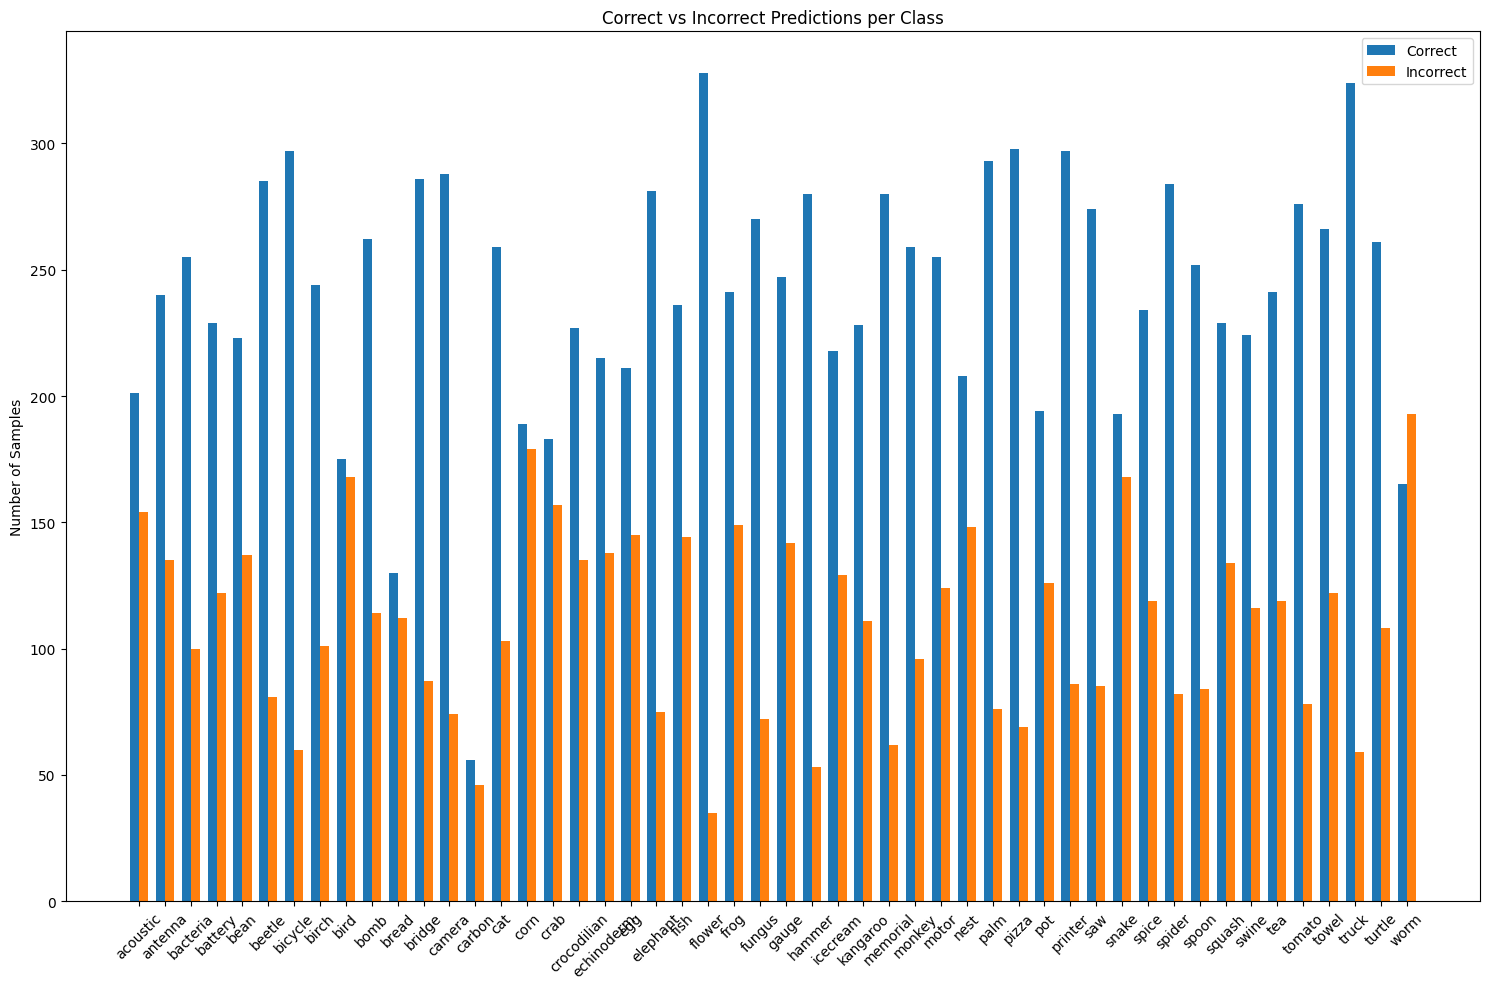

In [63]:
evaluation_confusion_matrix(y_true, y_pred, class_names)
class_bar_plot(y_true, y_pred, class_names)

# BlockNet

### Early Stopping in training
- I noticed that after running for 100 epochs, some models started to overfit — the validation loss stopped decreasing while the training loss continued to go down. To address this, I improved the training function by adding early stopping

In [ ]:
def train_and_save_model_early_stopping(
    model,
    train_loader,
    criterion,
    optimizer,
    device,
    epochs,
    validation_loader,
    scheduler=None,
    save_path_acc="best_model_acc.pth",
    save_path_loss="best_model_loss.pth",
    early_stop_patience=10,
    enable_early_stop=True
):
    epoch_acc = []
    epoch_loss = []
    val_acc_list = []
    val_loss_list = []

    best_val_acc = 0.0
    lowest_val_loss = float('inf')

    best_epoch = 0

    best_acc_model_wts = model.state_dict()
    best_loss_model_wts = model.state_dict()

    epochs_since_improvement = 0
    prev_val_loss = float('inf')

    for epoch in range(epochs):
        batch_acc = []
        running_loss = 0.0
        model.train()

        for i, data in tqdm(enumerate(train_loader, 0), desc=f"Training Epoch [{epoch+1}/{epochs}]", total=len(train_loader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            accuracy = accuracy_score(
                labels.cpu().numpy(),
                torch.argmax(outputs, dim=1).cpu().numpy()
            )
            batch_acc.append(accuracy)

        avg_loss = running_loss / len(train_loader)
        avg_acc = sum(batch_acc) / len(batch_acc)

        print(f"Training -> Loss: {avg_loss:.4f} - Acc: {avg_acc * 100:.2f}%")
        epoch_loss.append(avg_loss)
        epoch_acc.append(avg_acc)

        model.eval()
        val_labels = []
        val_preds = []
        val_loss = 0.0

        with torch.no_grad():
            for data in tqdm(validation_loader, desc=f"Validating Epoch [{epoch+1}/{epochs}]", total=len(validation_loader)):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predictions = torch.max(outputs, 1)
                val_preds.extend(predictions.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss /= len(validation_loader)
        val_acc = accuracy_score(val_labels, val_preds)

        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

        print(f"Validation -> Loss: {val_loss:.4f} - Acc: {val_acc * 100:.2f}%")


        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_acc_model_wts = model.state_dict()


        if val_loss < lowest_val_loss:
            lowest_val_loss = val_loss
            best_loss_model_wts = model.state_dict()
            best_epoch = epoch
            epochs_since_improvement = 0

        else:
            epochs_since_improvement += 1

        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

       # early stopping added
        if (
            enable_early_stop and
            epochs_since_improvement >= early_stop_patience and
            len(epoch_loss) > 1 and
            avg_loss < epoch_loss[-2] and
            val_loss > prev_val_loss
        ):
            print(f"Early stopping triggered at epoch {epoch+1}: no val improvement in {early_stop_patience} epochs, but train loss continues to decrease.")
            break

        prev_val_loss = val_loss

    print(" Finished Training")

    torch.save(best_acc_model_wts, save_path_acc)
    torch.save(best_loss_model_wts, save_path_loss)
    print(f"Best ACC model saved to: {save_path_acc}")
    print(f"Best LOSS model saved to: {save_path_loss}")

    model.load_state_dict(best_acc_model_wts)

    return model, epoch_loss, epoch_acc, val_loss_list, val_acc_list

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, bottleneck_channels, out_channels, stride=1, dropout_rate=0.3):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(bottleneck_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(bottleneck_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(bottleneck_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Dropout(dropout_rate)
        )

    def forward(self, x):
        return self.block(x)

class BlockNet(nn.Module):
    def __init__(self, num_classes=50):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.block1 = Block(64, 32, 128, stride=2, dropout_rate=0.3)
        self.block2 = Block(128, 64, 256, stride=2, dropout_rate=0.4)
        self.block3 = Block(256, 128, 512, stride=2, dropout_rate=0.5)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x


Training Epoch [1/50]: 100%|██████████| 551/551 [01:02<00:00,  8.76it/s]


Training -> Loss: 3.1330 - Acc: 16.65%


Validating Epoch [1/50]: 100%|██████████| 138/138 [00:20<00:00,  6.66it/s]


Validation -> Loss: 3.0668 - Acc: 18.35%


Training Epoch [2/50]: 100%|██████████| 551/551 [01:03<00:00,  8.69it/s]


Training -> Loss: 2.7239 - Acc: 26.17%


Validating Epoch [2/50]: 100%|██████████| 138/138 [00:19<00:00,  7.07it/s]


Validation -> Loss: 2.6280 - Acc: 27.84%


Training Epoch [3/50]: 100%|██████████| 551/551 [01:02<00:00,  8.82it/s]


Training -> Loss: 2.5159 - Acc: 31.41%


Validating Epoch [3/50]: 100%|██████████| 138/138 [00:19<00:00,  6.92it/s]


Validation -> Loss: 2.4971 - Acc: 32.57%


Training Epoch [4/50]: 100%|██████████| 551/551 [01:02<00:00,  8.81it/s]


Training -> Loss: 2.3784 - Acc: 34.67%


Validating Epoch [4/50]: 100%|██████████| 138/138 [00:20<00:00,  6.88it/s]


Validation -> Loss: 2.4747 - Acc: 32.10%


Training Epoch [5/50]: 100%|██████████| 551/551 [01:02<00:00,  8.84it/s]


Training -> Loss: 2.2776 - Acc: 37.07%


Validating Epoch [5/50]: 100%|██████████| 138/138 [00:20<00:00,  6.86it/s]


Validation -> Loss: 2.2238 - Acc: 39.10%


Training Epoch [6/50]: 100%|██████████| 551/551 [01:02<00:00,  8.80it/s]


Training -> Loss: 2.2063 - Acc: 39.14%


Validating Epoch [6/50]: 100%|██████████| 138/138 [00:19<00:00,  7.14it/s]


Validation -> Loss: 2.3238 - Acc: 36.54%


Training Epoch [7/50]: 100%|██████████| 551/551 [01:02<00:00,  8.77it/s]


Training -> Loss: 2.1335 - Acc: 40.97%


Validating Epoch [7/50]: 100%|██████████| 138/138 [00:19<00:00,  6.90it/s]


Validation -> Loss: 2.2087 - Acc: 40.14%


Training Epoch [8/50]: 100%|██████████| 551/551 [01:02<00:00,  8.82it/s]


Training -> Loss: 2.0742 - Acc: 42.74%


Validating Epoch [8/50]: 100%|██████████| 138/138 [00:20<00:00,  6.89it/s]


Validation -> Loss: 2.0339 - Acc: 44.63%


Training Epoch [9/50]: 100%|██████████| 551/551 [01:03<00:00,  8.67it/s]


Training -> Loss: 2.0252 - Acc: 44.12%


Validating Epoch [9/50]: 100%|██████████| 138/138 [00:19<00:00,  7.01it/s]


Validation -> Loss: 2.1480 - Acc: 41.69%


Training Epoch [10/50]: 100%|██████████| 551/551 [01:02<00:00,  8.76it/s]


Training -> Loss: 1.9830 - Acc: 45.02%


Validating Epoch [10/50]: 100%|██████████| 138/138 [00:19<00:00,  7.04it/s]


Validation -> Loss: 2.0518 - Acc: 43.89%


Training Epoch [11/50]: 100%|██████████| 551/551 [01:02<00:00,  8.82it/s]


Training -> Loss: 1.9377 - Acc: 46.19%


Validating Epoch [11/50]: 100%|██████████| 138/138 [00:20<00:00,  6.83it/s]


Validation -> Loss: 1.9891 - Acc: 45.60%


Training Epoch [12/50]: 100%|██████████| 551/551 [01:01<00:00,  8.98it/s]


Training -> Loss: 1.9000 - Acc: 46.98%


Validating Epoch [12/50]: 100%|██████████| 138/138 [00:22<00:00,  6.06it/s]


Validation -> Loss: 2.0170 - Acc: 44.63%


Training Epoch [13/50]: 100%|██████████| 551/551 [01:35<00:00,  5.78it/s]


Training -> Loss: 1.8728 - Acc: 47.81%


Validating Epoch [13/50]: 100%|██████████| 138/138 [00:26<00:00,  5.24it/s]


Validation -> Loss: 1.9063 - Acc: 47.66%


Training Epoch [14/50]: 100%|██████████| 551/551 [01:29<00:00,  6.14it/s]


Training -> Loss: 1.8438 - Acc: 48.90%


Validating Epoch [14/50]: 100%|██████████| 138/138 [00:25<00:00,  5.37it/s]


Validation -> Loss: 1.8948 - Acc: 48.24%


Training Epoch [15/50]: 100%|██████████| 551/551 [01:24<00:00,  6.52it/s]


Training -> Loss: 1.8167 - Acc: 49.35%


Validating Epoch [15/50]: 100%|██████████| 138/138 [00:28<00:00,  4.77it/s]


Validation -> Loss: 1.9150 - Acc: 47.84%


Training Epoch [16/50]: 100%|██████████| 551/551 [01:28<00:00,  6.20it/s]


Training -> Loss: 1.7900 - Acc: 49.95%


Validating Epoch [16/50]: 100%|██████████| 138/138 [00:26<00:00,  5.14it/s]


Validation -> Loss: 1.8313 - Acc: 50.07%


Training Epoch [17/50]: 100%|██████████| 551/551 [01:26<00:00,  6.38it/s]


Training -> Loss: 1.7639 - Acc: 50.64%


Validating Epoch [17/50]: 100%|██████████| 138/138 [00:21<00:00,  6.27it/s]


Validation -> Loss: 1.7890 - Acc: 51.07%


Training Epoch [18/50]: 100%|██████████| 551/551 [01:12<00:00,  7.58it/s]


Training -> Loss: 1.7467 - Acc: 50.93%


Validating Epoch [18/50]: 100%|██████████| 138/138 [00:22<00:00,  6.03it/s]


Validation -> Loss: 1.7570 - Acc: 51.37%


Training Epoch [19/50]: 100%|██████████| 551/551 [01:17<00:00,  7.13it/s]


Training -> Loss: 1.7182 - Acc: 52.01%


Validating Epoch [19/50]: 100%|██████████| 138/138 [00:24<00:00,  5.60it/s]


Validation -> Loss: 1.7541 - Acc: 51.66%


Training Epoch [20/50]: 100%|██████████| 551/551 [01:15<00:00,  7.33it/s]


Training -> Loss: 1.7012 - Acc: 52.36%


Validating Epoch [20/50]: 100%|██████████| 138/138 [00:22<00:00,  6.24it/s]


Validation -> Loss: 1.7537 - Acc: 51.83%


Training Epoch [21/50]: 100%|██████████| 551/551 [01:15<00:00,  7.29it/s]


Training -> Loss: 1.6823 - Acc: 52.89%


Validating Epoch [21/50]: 100%|██████████| 138/138 [00:24<00:00,  5.65it/s]


Validation -> Loss: 1.7206 - Acc: 52.50%


Training Epoch [22/50]: 100%|██████████| 551/551 [01:15<00:00,  7.33it/s]


Training -> Loss: 1.6650 - Acc: 53.20%


Validating Epoch [22/50]: 100%|██████████| 138/138 [00:23<00:00,  5.90it/s]


Validation -> Loss: 1.7532 - Acc: 51.96%


Training Epoch [23/50]: 100%|██████████| 551/551 [01:13<00:00,  7.48it/s]


Training -> Loss: 1.6475 - Acc: 53.65%


Validating Epoch [23/50]: 100%|██████████| 138/138 [00:24<00:00,  5.72it/s]


Validation -> Loss: 1.7280 - Acc: 53.07%


Training Epoch [24/50]: 100%|██████████| 551/551 [01:12<00:00,  7.60it/s]


Training -> Loss: 1.6300 - Acc: 54.45%


Validating Epoch [24/50]: 100%|██████████| 138/138 [00:27<00:00,  5.09it/s]


Validation -> Loss: 1.7123 - Acc: 52.73%


Training Epoch [25/50]: 100%|██████████| 551/551 [01:09<00:00,  7.97it/s]


Training -> Loss: 1.6183 - Acc: 54.68%


Validating Epoch [25/50]: 100%|██████████| 138/138 [00:21<00:00,  6.41it/s]


Validation -> Loss: 1.7346 - Acc: 52.69%


Training Epoch [26/50]: 100%|██████████| 551/551 [01:07<00:00,  8.11it/s]


Training -> Loss: 1.6038 - Acc: 54.69%


Validating Epoch [26/50]: 100%|██████████| 138/138 [00:19<00:00,  7.00it/s]


Validation -> Loss: 1.6953 - Acc: 53.62%


Training Epoch [27/50]: 100%|██████████| 551/551 [00:51<00:00, 10.61it/s]


Training -> Loss: 1.5911 - Acc: 55.32%


Validating Epoch [27/50]: 100%|██████████| 138/138 [00:16<00:00,  8.22it/s]


Validation -> Loss: 1.6940 - Acc: 53.54%


Training Epoch [28/50]: 100%|██████████| 551/551 [00:49<00:00, 11.04it/s]


Training -> Loss: 1.5818 - Acc: 55.39%


Validating Epoch [28/50]: 100%|██████████| 138/138 [00:16<00:00,  8.28it/s]


Validation -> Loss: 1.6439 - Acc: 54.49%


Training Epoch [29/50]: 100%|██████████| 551/551 [00:50<00:00, 10.89it/s]


Training -> Loss: 1.5680 - Acc: 55.96%


Validating Epoch [29/50]: 100%|██████████| 138/138 [00:16<00:00,  8.29it/s]


Validation -> Loss: 1.6929 - Acc: 54.01%


Training Epoch [30/50]: 100%|██████████| 551/551 [00:51<00:00, 10.77it/s]


Training -> Loss: 1.5603 - Acc: 56.32%


Validating Epoch [30/50]: 100%|██████████| 138/138 [00:16<00:00,  8.23it/s]


Validation -> Loss: 1.6368 - Acc: 55.41%


Training Epoch [31/50]: 100%|██████████| 551/551 [00:51<00:00, 10.66it/s]


Training -> Loss: 1.5382 - Acc: 56.74%


Validating Epoch [31/50]: 100%|██████████| 138/138 [00:16<00:00,  8.20it/s]


Validation -> Loss: 1.6686 - Acc: 54.63%


Training Epoch [32/50]: 100%|██████████| 551/551 [00:50<00:00, 10.86it/s]


Training -> Loss: 1.5284 - Acc: 56.91%


Validating Epoch [32/50]: 100%|██████████| 138/138 [00:16<00:00,  8.45it/s]


Validation -> Loss: 1.6242 - Acc: 55.16%


Training Epoch [33/50]: 100%|██████████| 551/551 [00:50<00:00, 10.95it/s]


Training -> Loss: 1.5248 - Acc: 57.08%


Validating Epoch [33/50]: 100%|██████████| 138/138 [00:16<00:00,  8.41it/s]


Validation -> Loss: 1.6387 - Acc: 54.79%


Training Epoch [34/50]: 100%|██████████| 551/551 [00:51<00:00, 10.70it/s]


Training -> Loss: 1.5099 - Acc: 57.38%


Validating Epoch [34/50]: 100%|██████████| 138/138 [00:16<00:00,  8.51it/s]


Validation -> Loss: 1.6013 - Acc: 56.38%


Training Epoch [35/50]: 100%|██████████| 551/551 [00:51<00:00, 10.80it/s]


Training -> Loss: 1.5022 - Acc: 57.75%


Validating Epoch [35/50]: 100%|██████████| 138/138 [00:16<00:00,  8.24it/s]


Validation -> Loss: 1.5934 - Acc: 56.19%


Training Epoch [36/50]: 100%|██████████| 551/551 [00:50<00:00, 10.83it/s]


Training -> Loss: 1.4857 - Acc: 57.87%


Validating Epoch [36/50]: 100%|██████████| 138/138 [00:16<00:00,  8.39it/s]


Validation -> Loss: 1.6210 - Acc: 56.06%


Training Epoch [37/50]: 100%|██████████| 551/551 [00:50<00:00, 11.00it/s]


Training -> Loss: 1.4806 - Acc: 58.14%


Validating Epoch [37/50]: 100%|██████████| 138/138 [00:16<00:00,  8.47it/s]


Validation -> Loss: 1.6158 - Acc: 55.62%


Training Epoch [38/50]: 100%|██████████| 551/551 [00:52<00:00, 10.56it/s]


Training -> Loss: 1.4730 - Acc: 58.24%


Validating Epoch [38/50]: 100%|██████████| 138/138 [00:16<00:00,  8.53it/s]


Validation -> Loss: 1.6066 - Acc: 56.19%


Training Epoch [39/50]: 100%|██████████| 551/551 [00:51<00:00, 10.61it/s]


Training -> Loss: 1.4671 - Acc: 58.45%


Validating Epoch [39/50]: 100%|██████████| 138/138 [00:16<00:00,  8.21it/s]


Validation -> Loss: 1.6508 - Acc: 55.36%


Training Epoch [40/50]: 100%|██████████| 551/551 [00:55<00:00,  9.99it/s]


Training -> Loss: 1.4525 - Acc: 58.82%


Validating Epoch [40/50]: 100%|██████████| 138/138 [00:17<00:00,  8.05it/s]


Validation -> Loss: 1.5758 - Acc: 56.94%


Training Epoch [41/50]: 100%|██████████| 551/551 [00:50<00:00, 10.89it/s]


Training -> Loss: 1.4453 - Acc: 59.00%


Validating Epoch [41/50]: 100%|██████████| 138/138 [00:16<00:00,  8.29it/s]


Validation -> Loss: 1.5366 - Acc: 57.90%


Training Epoch [42/50]: 100%|██████████| 551/551 [00:51<00:00, 10.79it/s]


Training -> Loss: 1.4387 - Acc: 59.16%


Validating Epoch [42/50]: 100%|██████████| 138/138 [00:16<00:00,  8.33it/s]


Validation -> Loss: 1.5706 - Acc: 56.63%


Training Epoch [43/50]: 100%|██████████| 551/551 [00:52<00:00, 10.58it/s]


Training -> Loss: 1.4309 - Acc: 59.22%


Validating Epoch [43/50]: 100%|██████████| 138/138 [00:16<00:00,  8.44it/s]


Validation -> Loss: 1.5493 - Acc: 57.47%


Training Epoch [44/50]: 100%|██████████| 551/551 [00:50<00:00, 10.89it/s]


Training -> Loss: 1.4268 - Acc: 59.47%


Validating Epoch [44/50]: 100%|██████████| 138/138 [00:16<00:00,  8.30it/s]


Validation -> Loss: 1.5439 - Acc: 57.63%


Training Epoch [45/50]: 100%|██████████| 551/551 [00:52<00:00, 10.49it/s]


Training -> Loss: 1.4175 - Acc: 59.81%


Validating Epoch [45/50]: 100%|██████████| 138/138 [00:16<00:00,  8.45it/s]


Validation -> Loss: 1.5368 - Acc: 57.79%


Training Epoch [46/50]: 100%|██████████| 551/551 [00:50<00:00, 10.83it/s]


Training -> Loss: 1.4051 - Acc: 60.01%


Validating Epoch [46/50]: 100%|██████████| 138/138 [00:16<00:00,  8.23it/s]


Validation -> Loss: 1.5869 - Acc: 56.95%


Training Epoch [47/50]: 100%|██████████| 551/551 [00:50<00:00, 10.81it/s]


Training -> Loss: 1.4002 - Acc: 60.28%


Validating Epoch [47/50]: 100%|██████████| 138/138 [00:16<00:00,  8.33it/s]


Validation -> Loss: 1.5314 - Acc: 58.21%


Training Epoch [48/50]: 100%|██████████| 551/551 [00:50<00:00, 10.82it/s]


Training -> Loss: 1.3945 - Acc: 60.49%


Validating Epoch [48/50]: 100%|██████████| 138/138 [00:16<00:00,  8.60it/s]


Validation -> Loss: 1.5366 - Acc: 58.17%


Training Epoch [49/50]: 100%|██████████| 551/551 [00:50<00:00, 10.87it/s]


Training -> Loss: 1.3886 - Acc: 60.45%


Validating Epoch [49/50]: 100%|██████████| 138/138 [00:16<00:00,  8.22it/s]


Validation -> Loss: 1.5665 - Acc: 57.25%


Training Epoch [50/50]: 100%|██████████| 551/551 [00:51<00:00, 10.67it/s]


Training -> Loss: 1.3869 - Acc: 60.53%


Validating Epoch [50/50]: 100%|██████████| 138/138 [00:16<00:00,  8.40it/s]


Validation -> Loss: 1.5416 - Acc: 57.85%
🏁 Finished Training
Best ACC model saved to: block_best_model_acc.pth
Best LOSS model saved to: block_best_model_loss.pth


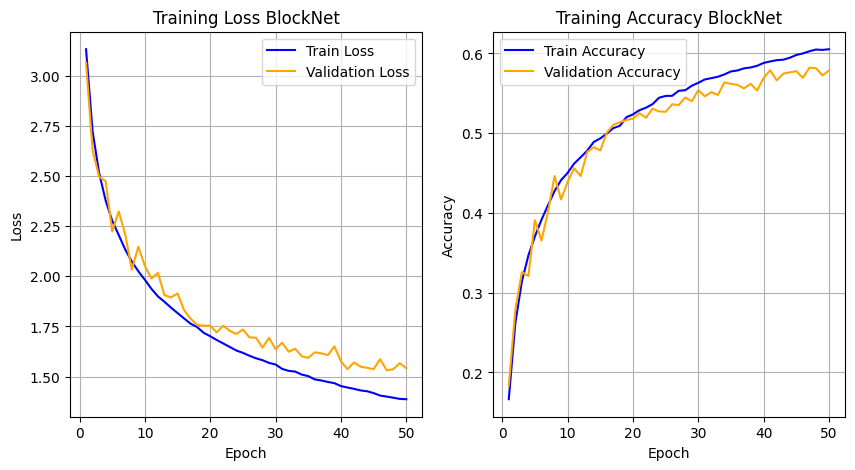

In [75]:
block_model = BlockNet().to(device)
criterion = nn.CrossEntropyLoss()
block_optimizer = torch.optim.AdamW(block_model.parameters(), lr=0.001, weight_decay=1e-4)
block_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(block_optimizer, mode='min', factor=0.1, patience=5)

block_model, block_train_loss, block_train_acc, block_val_loss, block_val_acc = train_and_save_model_early_stopping(
    model=block_model,
    train_loader=ag_trainloader,
    criterion=criterion,
    optimizer=block_optimizer,
    device=device,
    epochs=50,
    validation_loader=ag_valloader,
    save_path_acc="block_best_model_acc.pth",
    save_path_loss="block_best_model_loss.pth",
    scheduler=block_scheduler
)

training_plot(
    epochs=50,
    train_loss=block_train_loss,
    train_acc=block_train_acc,
    val_loss=block_val_loss,
    val_acc=block_val_acc,
    title=" BlockNet"
)

#### Another 30 epochs


In [77]:
block_model, block_train_loss_30, block_train_acc_30, block_val_loss_30, block_val_acc_30 = train_and_save_model_early_stopping(
    model=block_model,
    train_loader=ag_trainloader,
    criterion=criterion,
    optimizer=block_optimizer,
    device=device,
    epochs=30,
    validation_loader=ag_valloader,
    save_path_acc="models/block_best_model_acc_another_30.pth",
    save_path_loss="models/block_best_model_loss_another_30.pth",
    scheduler=block_scheduler
)

Training Epoch [1/30]: 100%|██████████| 551/551 [01:00<00:00,  9.18it/s]


Training -> Loss: 1.3790 - Acc: 60.88%


Validating Epoch [1/30]: 100%|██████████| 138/138 [00:19<00:00,  7.01it/s]


Validation -> Loss: 1.5497 - Acc: 57.77%


Training Epoch [2/30]: 100%|██████████| 551/551 [00:51<00:00, 10.64it/s]


Training -> Loss: 1.3762 - Acc: 60.78%


Validating Epoch [2/30]: 100%|██████████| 138/138 [00:17<00:00,  7.93it/s]


Validation -> Loss: 1.5219 - Acc: 58.51%


Training Epoch [3/30]: 100%|██████████| 551/551 [00:52<00:00, 10.44it/s]


Training -> Loss: 1.3718 - Acc: 61.10%


Validating Epoch [3/30]: 100%|██████████| 138/138 [00:16<00:00,  8.25it/s]


Validation -> Loss: 1.5441 - Acc: 57.85%


Training Epoch [4/30]: 100%|██████████| 551/551 [00:52<00:00, 10.58it/s]


Training -> Loss: 1.3587 - Acc: 61.17%


Validating Epoch [4/30]: 100%|██████████| 138/138 [00:16<00:00,  8.33it/s]


Validation -> Loss: 1.5389 - Acc: 57.97%


Training Epoch [5/30]: 100%|██████████| 551/551 [00:53<00:00, 10.25it/s]


Training -> Loss: 1.3554 - Acc: 61.35%


Validating Epoch [5/30]: 100%|██████████| 138/138 [00:17<00:00,  8.06it/s]


Validation -> Loss: 1.4881 - Acc: 59.25%


Training Epoch [6/30]: 100%|██████████| 551/551 [00:52<00:00, 10.55it/s]


Training -> Loss: 1.3537 - Acc: 61.37%


Validating Epoch [6/30]: 100%|██████████| 138/138 [00:16<00:00,  8.15it/s]


Validation -> Loss: 1.5423 - Acc: 58.06%


Training Epoch [7/30]: 100%|██████████| 551/551 [00:51<00:00, 10.77it/s]


Training -> Loss: 1.3488 - Acc: 61.51%


Validating Epoch [7/30]: 100%|██████████| 138/138 [00:16<00:00,  8.19it/s]


Validation -> Loss: 1.5237 - Acc: 58.27%


Training Epoch [8/30]: 100%|██████████| 551/551 [00:52<00:00, 10.43it/s]


Training -> Loss: 1.3384 - Acc: 61.83%


Validating Epoch [8/30]: 100%|██████████| 138/138 [00:16<00:00,  8.50it/s]


Validation -> Loss: 1.4841 - Acc: 59.63%


Training Epoch [9/30]: 100%|██████████| 551/551 [00:52<00:00, 10.59it/s]


Training -> Loss: 1.3292 - Acc: 62.22%


Validating Epoch [9/30]: 100%|██████████| 138/138 [00:16<00:00,  8.25it/s]


Validation -> Loss: 1.4769 - Acc: 59.60%


Training Epoch [10/30]: 100%|██████████| 551/551 [00:51<00:00, 10.62it/s]


Training -> Loss: 1.3271 - Acc: 62.23%


Validating Epoch [10/30]: 100%|██████████| 138/138 [00:16<00:00,  8.26it/s]


Validation -> Loss: 1.5249 - Acc: 58.26%


Training Epoch [11/30]: 100%|██████████| 551/551 [00:51<00:00, 10.65it/s]


Training -> Loss: 1.3162 - Acc: 62.44%


Validating Epoch [11/30]: 100%|██████████| 138/138 [00:16<00:00,  8.40it/s]


Validation -> Loss: 1.4579 - Acc: 59.88%


Training Epoch [12/30]: 100%|██████████| 551/551 [00:52<00:00, 10.53it/s]


Training -> Loss: 1.3209 - Acc: 62.36%


Validating Epoch [12/30]: 100%|██████████| 138/138 [00:16<00:00,  8.24it/s]


Validation -> Loss: 1.4879 - Acc: 59.22%


Training Epoch [13/30]: 100%|██████████| 551/551 [00:50<00:00, 10.92it/s]


Training -> Loss: 1.3107 - Acc: 62.34%


Validating Epoch [13/30]: 100%|██████████| 138/138 [00:16<00:00,  8.41it/s]


Validation -> Loss: 1.4728 - Acc: 59.61%


Training Epoch [14/30]: 100%|██████████| 551/551 [00:51<00:00, 10.73it/s]


Training -> Loss: 1.3060 - Acc: 62.66%


Validating Epoch [14/30]: 100%|██████████| 138/138 [00:16<00:00,  8.24it/s]


Validation -> Loss: 1.4920 - Acc: 59.22%


Training Epoch [15/30]: 100%|██████████| 551/551 [00:50<00:00, 10.89it/s]


Training -> Loss: 1.3017 - Acc: 62.68%


Validating Epoch [15/30]: 100%|██████████| 138/138 [00:16<00:00,  8.50it/s]


Validation -> Loss: 1.5040 - Acc: 58.96%


Training Epoch [16/30]: 100%|██████████| 551/551 [00:53<00:00, 10.39it/s]


Training -> Loss: 1.3055 - Acc: 62.65%


Validating Epoch [16/30]: 100%|██████████| 138/138 [00:16<00:00,  8.14it/s]


Validation -> Loss: 1.4802 - Acc: 59.35%


Training Epoch [17/30]: 100%|██████████| 551/551 [00:55<00:00,  9.96it/s]


Training -> Loss: 1.2979 - Acc: 62.92%


Validating Epoch [17/30]: 100%|██████████| 138/138 [00:17<00:00,  7.88it/s]


Validation -> Loss: 1.5269 - Acc: 58.99%


Training Epoch [18/30]: 100%|██████████| 551/551 [00:51<00:00, 10.66it/s]


Training -> Loss: 1.2014 - Acc: 65.42%


Validating Epoch [18/30]: 100%|██████████| 138/138 [00:16<00:00,  8.28it/s]


Validation -> Loss: 1.3912 - Acc: 62.05%


Training Epoch [19/30]: 100%|██████████| 551/551 [00:51<00:00, 10.75it/s]


Training -> Loss: 1.1904 - Acc: 65.86%


Validating Epoch [19/30]: 100%|██████████| 138/138 [00:17<00:00,  8.07it/s]


Validation -> Loss: 1.3862 - Acc: 62.01%


Training Epoch [20/30]: 100%|██████████| 551/551 [00:56<00:00,  9.77it/s]


Training -> Loss: 1.1786 - Acc: 66.24%


Validating Epoch [20/30]: 100%|██████████| 138/138 [00:16<00:00,  8.23it/s]


Validation -> Loss: 1.3799 - Acc: 62.25%


Training Epoch [21/30]: 100%|██████████| 551/551 [00:50<00:00, 10.91it/s]


Training -> Loss: 1.1715 - Acc: 66.50%


Validating Epoch [21/30]: 100%|██████████| 138/138 [00:16<00:00,  8.44it/s]


Validation -> Loss: 1.3990 - Acc: 61.86%


Training Epoch [22/30]: 100%|██████████| 551/551 [00:53<00:00, 10.37it/s]


Training -> Loss: 1.1691 - Acc: 66.44%


Validating Epoch [22/30]: 100%|██████████| 138/138 [00:16<00:00,  8.32it/s]


Validation -> Loss: 1.3883 - Acc: 62.11%


Training Epoch [23/30]: 100%|██████████| 551/551 [00:51<00:00, 10.66it/s]


Training -> Loss: 1.1689 - Acc: 66.43%


Validating Epoch [23/30]: 100%|██████████| 138/138 [00:16<00:00,  8.40it/s]


Validation -> Loss: 1.3916 - Acc: 62.14%


Training Epoch [24/30]: 100%|██████████| 551/551 [00:51<00:00, 10.61it/s]


Training -> Loss: 1.1614 - Acc: 66.58%


Validating Epoch [24/30]: 100%|██████████| 138/138 [00:16<00:00,  8.32it/s]


Validation -> Loss: 1.4099 - Acc: 61.44%


Training Epoch [25/30]: 100%|██████████| 551/551 [00:51<00:00, 10.77it/s]


Training -> Loss: 1.1627 - Acc: 66.63%


Validating Epoch [25/30]: 100%|██████████| 138/138 [00:16<00:00,  8.36it/s]


Validation -> Loss: 1.3933 - Acc: 62.00%


Training Epoch [26/30]: 100%|██████████| 551/551 [00:50<00:00, 10.86it/s]


Training -> Loss: 1.1633 - Acc: 66.79%


Validating Epoch [26/30]: 100%|██████████| 138/138 [00:16<00:00,  8.35it/s]


Validation -> Loss: 1.3800 - Acc: 62.35%


Training Epoch [27/30]: 100%|██████████| 551/551 [00:51<00:00, 10.67it/s]


Training -> Loss: 1.1514 - Acc: 67.04%


Validating Epoch [27/30]: 100%|██████████| 138/138 [00:16<00:00,  8.37it/s]


Validation -> Loss: 1.3915 - Acc: 61.92%


Training Epoch [28/30]: 100%|██████████| 551/551 [00:51<00:00, 10.74it/s]


Training -> Loss: 1.1487 - Acc: 67.12%


Validating Epoch [28/30]: 100%|██████████| 138/138 [00:16<00:00,  8.41it/s]


Validation -> Loss: 1.3846 - Acc: 62.03%


Training Epoch [29/30]: 100%|██████████| 551/551 [00:51<00:00, 10.60it/s]


Training -> Loss: 1.1465 - Acc: 67.08%


Validating Epoch [29/30]: 100%|██████████| 138/138 [00:17<00:00,  7.92it/s]


Validation -> Loss: 1.4058 - Acc: 61.66%


Training Epoch [30/30]: 100%|██████████| 551/551 [00:50<00:00, 10.95it/s]


Training -> Loss: 1.1445 - Acc: 67.40%


Validating Epoch [30/30]: 100%|██████████| 138/138 [00:16<00:00,  8.51it/s]

Validation -> Loss: 1.3849 - Acc: 62.15%
 Finished Training
Best ACC model saved to: models/block_best_model_acc_another_30.pth
Best LOSS model saved to: models/block_best_model_loss_another_30.pth


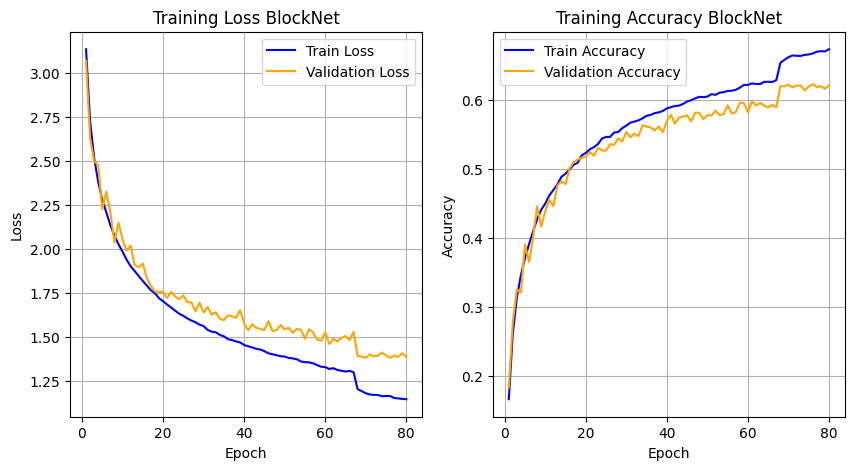


Per-class Accuracy:
Accuracy for class 'acoustic       ': 44.8%
Accuracy for class 'antenna        ': 57.9%
Accuracy for class 'bacteria       ': 66.8%
Accuracy for class 'battery        ': 62.7%
Accuracy for class 'bean           ': 63.1%
Accuracy for class 'beetle         ': 70.5%
Accuracy for class 'bicycle        ': 72.5%
Accuracy for class 'birch          ': 68.7%
Accuracy for class 'bird           ': 32.7%
Accuracy for class 'bomb           ': 59.0%
Accuracy for class 'bread          ': 50.0%
Accuracy for class 'bridge         ': 73.7%
Accuracy for class 'camera         ': 72.1%
Accuracy for class 'carbon         ': 51.0%
Accuracy for class 'cat            ': 65.2%
Accuracy for class 'corn           ': 50.8%
Accuracy for class 'crab           ': 35.9%
Accuracy for class 'crocodilian    ': 57.7%
Accuracy for class 'echinoderm     ': 45.6%
Accuracy for class 'egg            ': 49.4%
Accuracy for class 'elephant       ': 80.1%
Accuracy for class 'fish           ': 52.6%
Accuracy fo

In [78]:
# concatenate the two training results
final_block_train_loss = block_train_loss + block_train_loss_30
final_block_train_acc = block_train_acc + block_train_acc_30
final_block_val_loss = block_val_loss + block_val_loss_30
final_block_val_acc = block_val_acc + block_val_acc_30

training_plot(
    epochs=80,
    train_loss=final_block_train_loss,
    train_acc=final_block_train_acc,
    val_loss=final_block_val_loss,
    val_acc=final_block_val_acc,
    title=" BlockNet"
)
y_true, y_pred = evaluate(block_model, ag_valloader, classes=class_names, device=device)


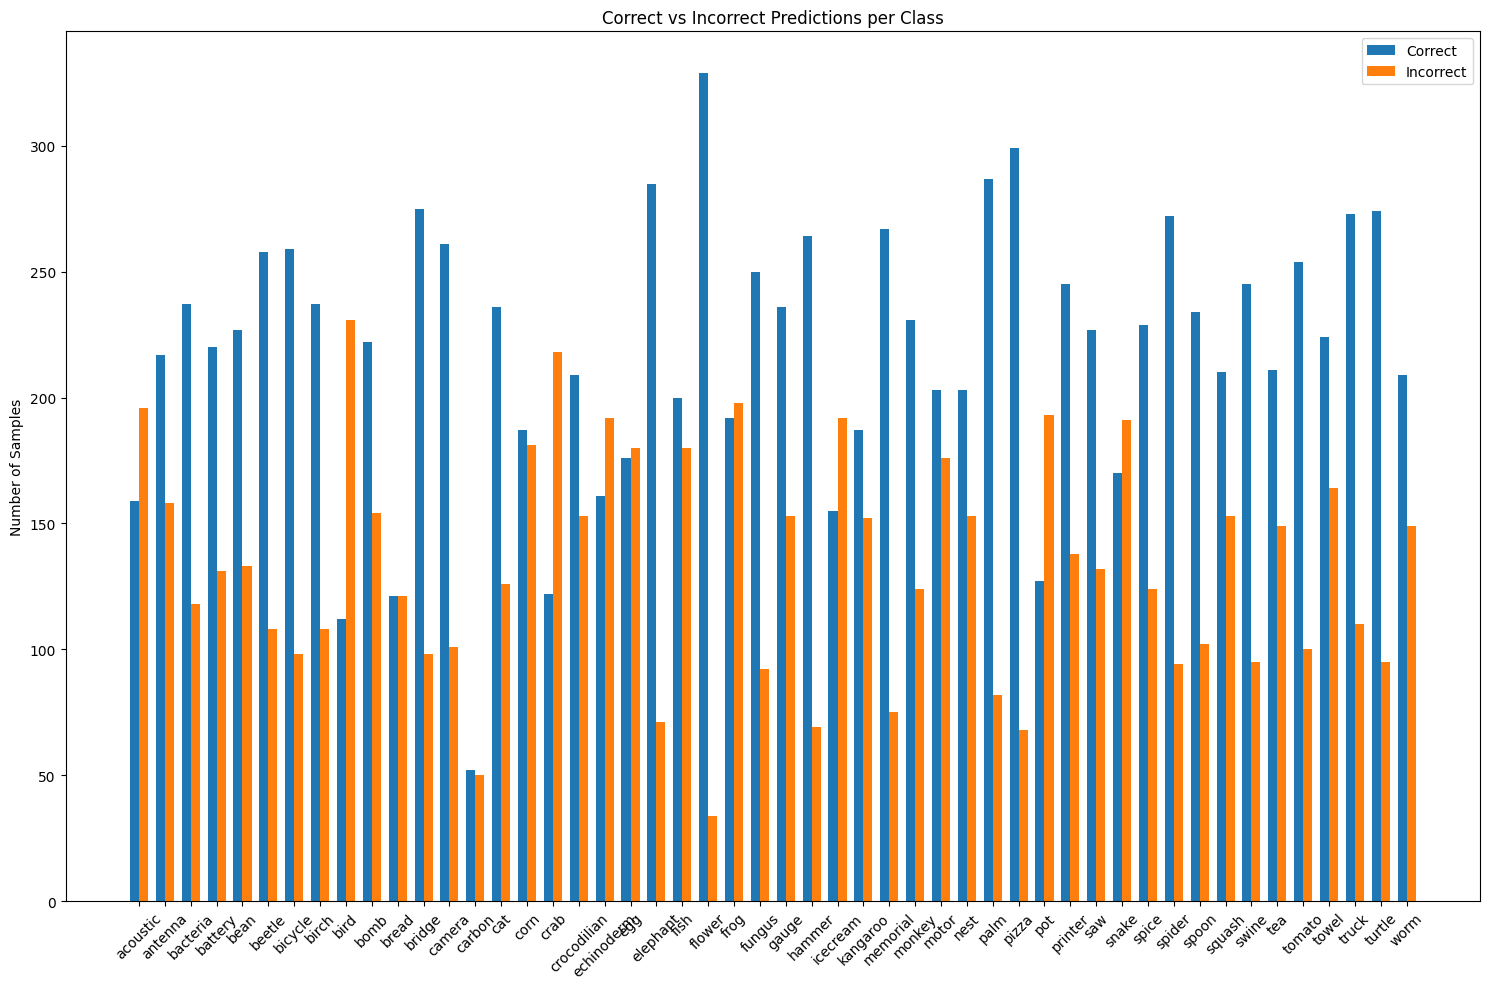

In [79]:
class_bar_plot(y_true, y_pred, class_names)

#### Conclusions 
This model still has potential to learn, but unfortunately I do not have more time to test it

# Predictions

In [ ]:
# model
prediciton_model = AVGPoolNet().to(device)
prediciton_model.load_state_dict(torch.load("models/avg_best_model_acc.pth"))

y_true, y_pred = evaluate(prediciton_model, ag_valloader, classes=class_names, device=device)

C:\Users\barte\AppData\Local\Temp\ipykernel_12164\1517045267.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  prediciton_model.load_state_dict(torch.load("models/avg_best


Per-class Accuracy:
Accuracy for class 'acoustic       ': 56.6%
Accuracy for class 'antenna        ': 64.0%
Accuracy for class 'bacteria       ': 71.8%
Accuracy for class 'battery        ': 65.2%
Accuracy for class 'bean           ': 61.9%
Accuracy for class 'beetle         ': 77.9%
Accuracy for class 'bicycle        ': 83.2%
Accuracy for class 'birch          ': 70.7%
Accuracy for class 'bird           ': 51.0%
Accuracy for class 'bomb           ': 69.7%
Accuracy for class 'bread          ': 53.7%
Accuracy for class 'bridge         ': 76.7%
Accuracy for class 'camera         ': 79.6%
Accuracy for class 'carbon         ': 54.9%
Accuracy for class 'cat            ': 71.5%
Accuracy for class 'corn           ': 51.4%
Accuracy for class 'crab           ': 53.8%
Accuracy for class 'crocodilian    ': 62.7%
Accuracy for class 'echinoderm     ': 60.9%
Accuracy for class 'egg            ': 59.3%
Accuracy for class 'elephant       ': 78.9%
Accuracy for class 'fish           ': 62.1%
Accuracy fo

In [88]:
import os
from PIL import Image
from torch.utils.data import TensorDataset

def load_images_from_folder(folder_path, transform):
    image_tensors = []
    filenames = []

    for fname in os.listdir(folder_path):
        if fname.endswith('.JPEG'):
            img_path = os.path.join(folder_path, fname)
            image = Image.open(img_path).convert('RGB')
            img_tensor = transform(image)
            image_tensors.append(img_tensor)
            filenames.append(fname)

    images_tensor = torch.stack(image_tensors)
    dataset = TensorDataset(images_tensor, torch.arange(len(filenames)))
    return dataset, filenames

normal_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_dataset, test_filenames = load_images_from_folder('test/test_all', normal_transform)

In [98]:
print(f"Number of images in test dataset: {len(test_dataset)}")
print(f"Filenames: {test_filenames[0]}")
print(train_dataset.classes)

Number of images in test dataset: 10000
Filenames: 00013066837824360356.JPEG
['acoustic', 'antenna', 'bacteria', 'battery', 'bean', 'beetle', 'bicycle', 'birch', 'bird', 'bomb', 'bread', 'bridge', 'camera', 'carbon', 'cat', 'corn', 'crab', 'crocodilian', 'echinoderm', 'egg', 'elephant', 'fish', 'flower', 'frog', 'fungus', 'gauge', 'hammer', 'icecream', 'kangaroo', 'memorial', 'monkey', 'motor', 'nest', 'palm', 'pizza', 'pot', 'printer', 'saw', 'snake', 'spice', 'spider', 'spoon', 'squash', 'swine', 'tea', 'tomato', 'towel', 'truck', 'turtle', 'worm']


In [ ]:
eval = []

for i in range(len(test_dataset)):
    img_tensor = test_dataset[i][0].unsqueeze(0).to(device)
    pred = prediciton_model(img_tensor).cpu().detach().numpy()
    pred_class = np.argmax(pred, axis=1)[0]
    eval.append(pred_class)

First 10 predictions  for test dataset: [np.int64(10), np.int64(31), np.int64(2), np.int64(39), np.int64(45), np.int64(2), np.int64(1), np.int64(37), np.int64(41), np.int64(7)]


In [101]:
print(f"First 10 images: {test_filenames[:10]}")
print(f"First 10 predictions  for test dataset: {eval[0:10]}")

First 10 images: ['00013066837824360356.JPEG', '00022240850406751722.JPEG', '0004927347689911432.JPEG', '000563265767796084.JPEG', '0006013938786831874.JPEG', '0006399600638603564.JPEG', '0006465730485515353.JPEG', '0007310156969084769.JPEG', '000912032407904162.JPEG', '0009124332639172117.JPEG']
First 10 predictions  for test dataset: [np.int64(10), np.int64(31), np.int64(2), np.int64(39), np.int64(45), np.int64(2), np.int64(1), np.int64(37), np.int64(41), np.int64(7)]


In [128]:
TEST_SAMPLE = 26
print(test_filenames[TEST_SAMPLE])
print(eval[TEST_SAMPLE])
print(train_dataset.classes[eval[TEST_SAMPLE]])

0029929765775938977.JPEG
36
printer


In [107]:
print(f"All unique classes in predictions : {set(eval)}")
print(f'Amount fo diffrent predictions: {len(set(eval))}')

All unique classes in predictions : {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49)}
Amount fo diffrent predictions: 50


In [105]:
eval_int = [int(i) for i in eval]
print(eval_int[0:10])

[10, 31, 2, 39, 45, 2, 1, 37, 41, 7]


### Saving into csv file

In [125]:
dataframe = pd.DataFrame({
    'filename': test_filenames,
    'predicted_class': eval_int
})

dataframe.to_csv('pred.csv', index=False, header=False)